# **Change Component Analysis (CCA)**
---
Author: Robert Gilmore Pontius Jr, Antonio Fonseca

Institution: Clark University

Email: antfonseca@clarku.edu

Version: 2.0

Updates:

This version includes the new sections:

1.   Heat Maps
2.   Alternation Exchange and Alternation Shift Maps




## **1.Environment Setup**


---



### **1.1 Install Python Libraries**
Run the cell below only if using Google Colab.


In [2]:
%pip -q install \
    rasterio \
    seaborn \
    xlsxwriter \
    matplotlib-scalebar \
    matplotlib-map-utils

Note: you may need to restart the kernel to use updated packages.


### **1.2 Importing Libraries**

In [3]:
# Standard library
import glob
import os
import re
import pickle
import sys
import time
import math
from pathlib import Path

# Typing for annotations
from typing import Dict, List, Optional, Iterable, Tuple

# Third-party
import numba as nb
import numpy as np
import pandas as pd
import rasterio
import xlsxwriter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import matplotlib.ticker as mticker
from numba import prange
from pyproj import Transformer
from pyproj import CRS, Geod, Transformer
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

# Rasterio submodules
from rasterio.plot import show
from rasterio.mask import mask
from rasterio.enums import Resampling
from rasterio.transform import from_origin

# Matplotlib extensions
from matplotlib.ticker import FuncFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib_map_utils import north_arrow
from matplotlib.colors import (
    ListedColormap,
    BoundaryNorm,
    Normalize,
    LinearSegmentedColormap,
)
from matplotlib.patches import Patch, Rectangle, FancyArrowPatch

### **1.3 Mounting Google Drive in Colab**
Run the cell below only if using Google Colab.



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **2.Data Preparation**

### **2.1 Setting Paths to Image Files**

The user must include the year in the raster map name.

In [25]:
# List of input raster paths
image_paths = [

    r"/Users/antoniofonseca/Downloads/ecoregion567_glance_2001.tif",
    r"/Users/antoniofonseca/Downloads/ecoregion567_glance_2002.tif",
    r"/Users/antoniofonseca/Downloads/ecoregion567_glance_2003.tif",
    r"/Users/antoniofonseca/Downloads/ecoregion567_glance_2004.tif",
    r"/Users/antoniofonseca/Downloads/ecoregion567_glance_2005.tif",
    r"/Users/antoniofonseca/Downloads/ecoregion567_glance_2006.tif",
    r"/Users/antoniofonseca/Downloads/ecoregion567_glance_2007.tif",
    r"/Users/antoniofonseca/Downloads/ecoregion567_glance_2008.tif",
    r"/Users/antoniofonseca/Downloads/ecoregion567_glance_2009.tif",
    r"/Users/antoniofonseca/Downloads/ecoregion567_glance_2010.tif",
    r"/Users/antoniofonseca/Downloads/ecoregion567_glance_2011.tif",
    r"/Users/antoniofonseca/Downloads/ecoregion567_glance_2012.tif",
    r"/Users/antoniofonseca/Downloads/ecoregion567_glance_2013.tif",
    r"/Users/antoniofonseca/Downloads/ecoregion567_glance_2014.tif",
    r"/Users/antoniofonseca/Downloads/ecoregion567_glance_2015.tif",
    r"/Users/antoniofonseca/Downloads/ecoregion567_glance_2016.tif",
    r"/Users/antoniofonseca/Downloads/ecoregion567_glance_2017.tif",
    r"/Users/antoniofonseca/Downloads/ecoregion567_glance_2018.tif",
    r"/Users/antoniofonseca/Downloads/ecoregion567_glance_2019.tif"
]

# Set no data value
noData_value = 255

# Check if all files exist
missing_files = [f for f in image_paths if not os.path.exists(f)]

if missing_files:
    print("Missing files:")
    for f in missing_files:
        print(f" - {f}")
else:
    print("All input files found.")

All input files found.


### **2.2 Setting Path to Output Files**

In [26]:
# Output directory path
output_path = r"/Users/antoniofonseca/Downloads/"

# Create folder if it does not exist
if not os.path.exists(output_path):
    os.makedirs(output_path)
    print("Folder created:", output_path)
else:
    print("Folder already exists:", output_path)

Folder already exists: /Users/antoniofonseca/Downloads/


### **2.3 Setting Time Points**

In [27]:
# Years of input rasters
years = list(range(2001, 2020))

### **2.4 Setting Classes Parameters**

In [32]:
# Class ID, names, and colors
class_labels_dict = {

    6: {"name": "Shrublands",  "color": "#28A765"},
    5: {"name": "Tree Cover",  "color": "#336600"},
    2: {"name": "Snow/Ice",    "color": "#FFFFFF"},
    3: {"name": "Developed",   "color": "#FF0000"},
    4: {"name": "Bare",        "color": "#68666B"},
    1: {"name": "Water",       "color": "#386CB0"},
    7: {"name": "Herbaceous",  "color": "#FFFF99"}
}

# Sorted list of renamed class labels
class_labels = [class_labels_dict[key]["name"] for key in sorted(class_labels_dict.keys())]

### **2.5 Display the Maps**

This cell defines and executes a function to visualize a temporal series of classified rasters in a multi-panel grid.

In [ ]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Rectangle
from matplotlib_scalebar.scalebar import ScaleBar
from pyproj import Transformer, Geod
from typing import Dict, List, Optional

def compute_display_pixel_size_km(
    raster_path: str,
    downsample_divisor: float,
) -> float:
    """
    Compute horizontal resolution in kilometers per displayed pixel.

    Parameters
    ----------
    raster_path : str
        Path to a raster file used to derive spatial extent and CRS.
    downsample_divisor : float
        Factor used to downsample the raster width for display.

    Returns
    -------
    float
        Pixel size in kilometers for the downsampled display grid.
    """
    with rasterio.open(raster_path) as src:
        left, bottom, right, top = src.bounds
        lat_mid_src = (top + bottom) / 2.0

        to_ll = Transformer.from_crs(
            src.crs,
            "EPSG:4326",
            always_xy=True,
        )
        lon_l, lat_mid = to_ll.transform(
            left,
            lat_mid_src,
        )
        lon_r, _ = to_ll.transform(
            right,
            lat_mid_src,
        )

        geod = Geod(
            ellps="WGS84",
        )
        _, _, width_m = geod.inv(
            lon_l,
            lat_mid,
            lon_r,
            lat_mid,
        )

        # Ensure we don't divide by zero and handle floats
        cols_disp = max(
            1.0,
            src.width / downsample_divisor,
        )

        return (width_m / cols_disp) / 1_000

Plotting 19 maps. Dynamic downsample factor: 52.13


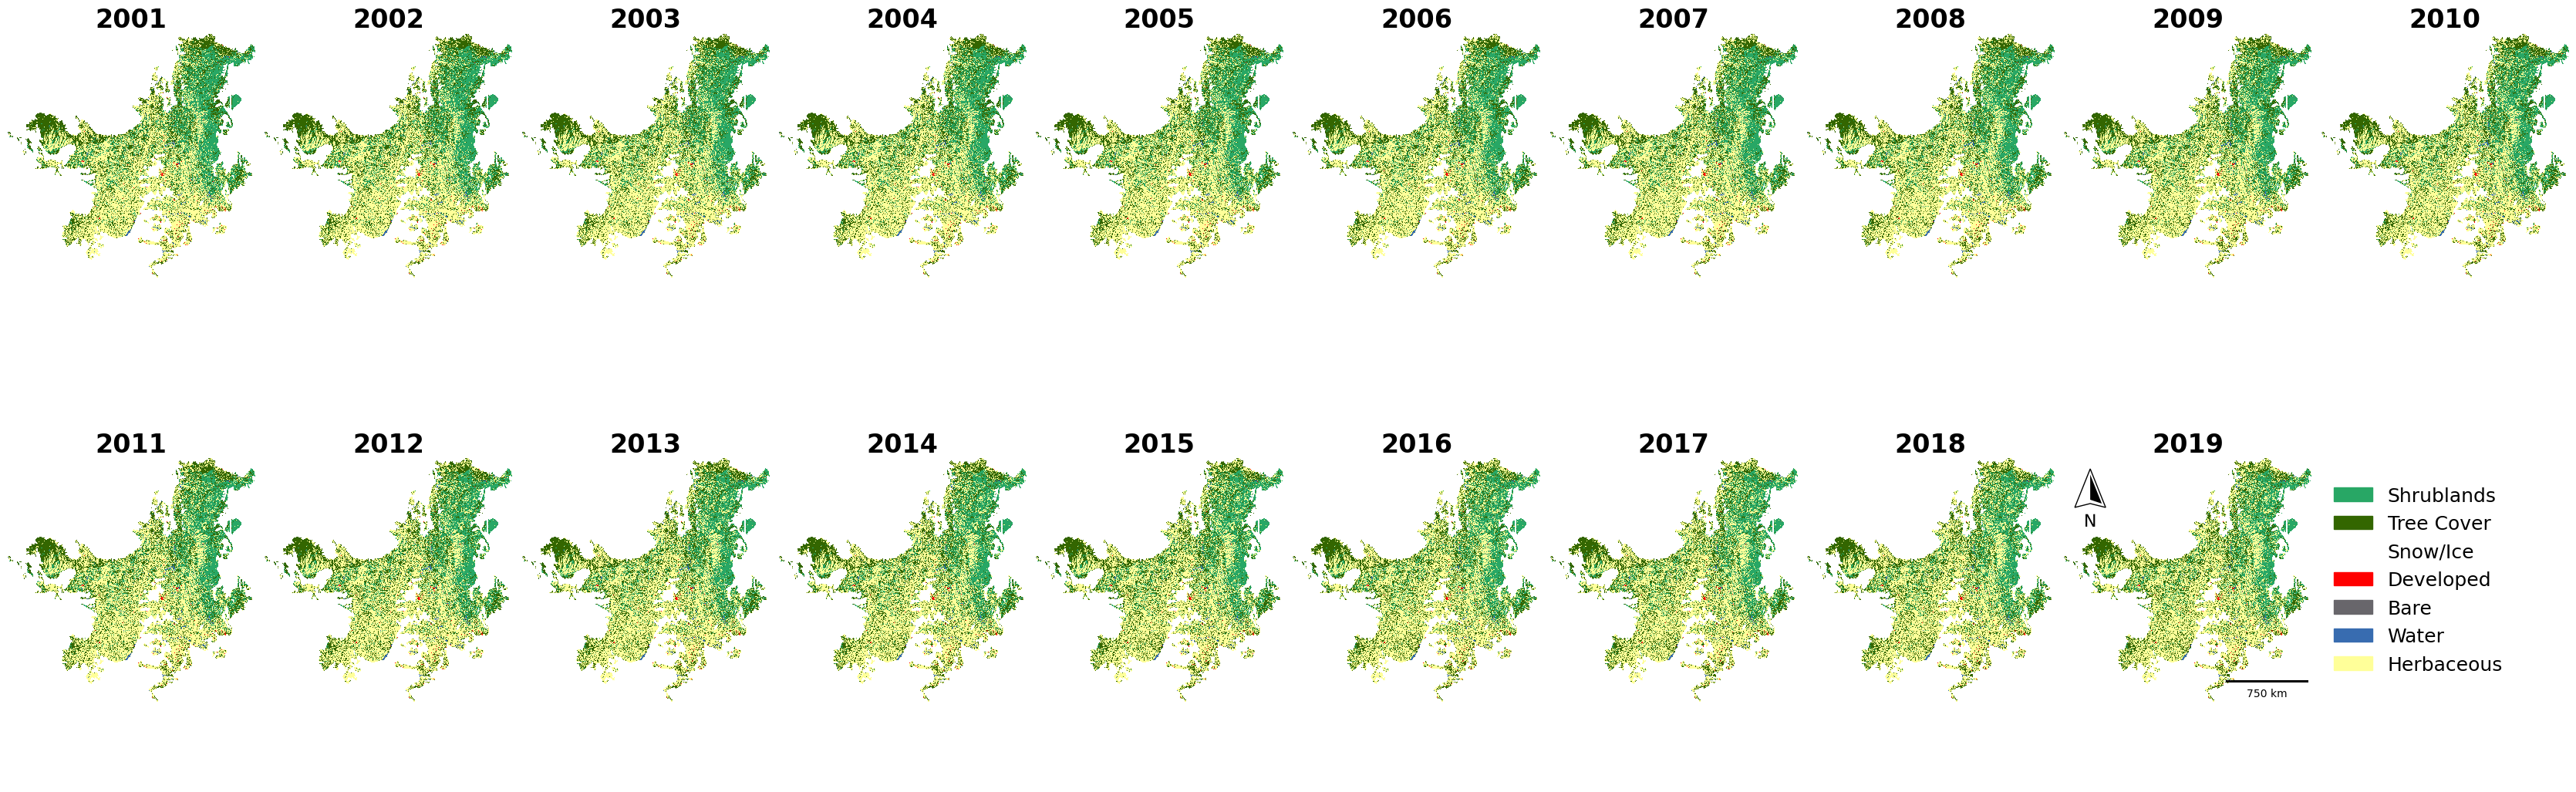

In [33]:
def plot_classified_images(
    class_map: Dict[int, Dict[str, str]],
    years: List[int],
    output_path: str,
    image_paths_arg: List[str],
    nodata_val: int,
    max_display_size: int = 1500, # Replaced fixed divisor with dynamic max size
    panel_size: tuple = (4.0, 6.0),
    dx_km: Optional[float] = None,
    resampling_method: Resampling = Resampling.nearest,
) -> None:
    """
    Plot classified rasters over time with legend, north arrow, and scale bar,
    using dynamic downsampling to prevent out-of-memory errors.

    Parameters
    ----------
    class_map : Dict[int, Dict[str, str]]
        Mapping from class ID to metadata with at least
        ``{"name": str, "color": str}`` for each class.
    years : List[int]
        List of years corresponding to each classified raster.
    output_path : str
        Directory where input rasters are stored and the figure is saved.
    image_paths_arg : List[str]
        List of paths to the raster files.
    nodata_val : int
        Value representing NoData pixels.
    max_display_size : int, optional
        Maximum width/height in pixels for each panel. Larger rasters will be
        downsampled dynamically to this size to save RAM. Default is 1500.
    panel_size : tuple, optional
        Width and height in inches for a single panel, by default (4.0, 6.0).
    dx_km : float, optional
        Pixel size in kilometers for the scale bar. Computed if None.
    resampling_method : Resampling, optional
        Resampling method used when reading rasters, by default
        ``Resampling.nearest``.

    Returns
    -------
    None
        This function saves a multi-panel figure to disk and shows the plot.
    """
    if not image_paths_arg:
        raise ValueError("No image paths provided.")

    image_paths = sorted(image_paths_arg)

    # 1. Calculate Grid and Dynamic Scale Factor
    n_images = len(image_paths)
    max_cols = 10
    ncols = min(
        max_cols,
        n_images,
    )
    nrows = math.ceil(n_images / max_cols)

    # Calculate dynamic downsampling based on the first image
    with rasterio.open(image_paths[0]) as src:
        max_dim = max(src.width, src.height)
        # If image is smaller than max size, scale_factor is 1 (no scaling)
        scale_factor = max(1.0, max_dim / max_display_size)

        # Extent is needed so Matplotlib plots using real map coordinates
        left, bottom, right, top = src.bounds
        extent = [left, right, bottom, top]

    # Derive km per displayed pixel using the calculated scale factor
    if dx_km is None:
        dx_km = compute_display_pixel_size_km(
            raster_path=image_paths[0],
            downsample_divisor=scale_factor,
        )

    # 2. Setup Figure
    fig, axs = plt.subplots(
        nrows,
        ncols,
        figsize=(
            panel_size[0] * ncols,
            panel_size[1] * nrows,
        ),
        sharey=True,
        sharex=True, # Share X too since bounds are identical
        constrained_layout=False,
    )

    plt.subplots_adjust(
        left=0.02,
        right=0.85,
        top=0.95,
        bottom=0.05,
        wspace=0.04,
        hspace=0.04,
    )

    if isinstance(axs, np.ndarray):
        axes = axs.ravel()
    else:
        axes = [axs]

    # 3. Setup Colormap
    class_ids_sorted = sorted(class_map.keys())
    cmap = ListedColormap(
        [
            class_map[k]["color"]
            for k in class_ids_sorted
        ],
    )
    norm = BoundaryNorm(
        class_ids_sorted + [class_ids_sorted[-1] + 1],
        cmap.N,
    )

    # 4. Read and Plot Data
    print(f"Plotting {n_images} maps. Dynamic downsample factor: {scale_factor:.2f}")

    for i, (path, year) in enumerate(
        zip(
            image_paths,
            years,
        ),
    ):
        ax = axes[i]

        with rasterio.open(path) as src:
            # Calculate new shape safely
            new_height = max(1, int(src.height / scale_factor))
            new_width = max(1, int(src.width / scale_factor))

            # Read and resample on the fly
            data = src.read(
                1,
                out_shape=(
                    new_height,
                    new_width,
                ),
                resampling=resampling_method,
            )

        # Apply NoData mask
        data = np.ma.masked_where(data == nodata_val, data)

        ax.imshow(
            data,
            cmap=cmap,
            norm=norm,
            interpolation="nearest"
        )
        ax.set_title(
            f"{year}",
            fontweight="bold",
            fontsize=24,
        )
        ax.axis("off")

    # Disable unused axes
    for j in range(
        n_images,
        len(axes),
    ):
        axes[j].axis("off")

    # 5. Add Legend to the last valid axis
    last_ax = axes[n_images - 1]

    legend_elements = [
        Rectangle(
            (0, 0),
            1,
            1,
            color=class_map[k]["color"],
            label=class_map[k]["name"],
        )
        for k in class_map.keys()
    ]

    last_ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(
            1.02,
            0.5,
        ),
        frameon=False,
        fontsize=18,
    )

    # 6. Add Scale Bar
    scalebar = ScaleBar(
        dx=dx_km,
        units="km",
        length_fraction=0.35,
        location="lower right",
        scale_loc="bottom",
        color="black",
        box_alpha=0,
    )
    last_ax.add_artist(
        scalebar,
    )

    # 7. Add North Arrow
    try:
        north_arrow(
            last_ax,
            location="upper left",
            shadow=False,
            rotation={
                "degrees": 0,
            },
        )
    except NameError:
        print("Note: north_arrow function not found, skipping north arrow.")

    # 8. Save Figure
    out_fig = os.path.join(
        output_path,
        "map_panel_input_maps.png",
    )
    plt.savefig(
        out_fig,
        format="png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()
    plt.close()

# Execution of the plotting function with the defined parameters
plot_classified_images(
    class_map=class_labels_dict,
    years=years,
    output_path=output_path,
    image_paths_arg=image_paths,
    nodata_val=noData_value
)

## **3.Class distribution over time**


---
This cell processes raster data to calculate pixel counts per class over time, generating a stacked bar chart and exporting the statistical results to both a pivot table and a CSV file.

In [38]:
import os
import re
import numpy as np
import pandas as pd
import rasterio

# 1. Processing and Exporting Function
def process_and_export_pixel_counts(
    image_paths: list[str],
    years: list[int],
    class_labels_dict: dict,
    output_dir: str,
    no_data_value: int,
) -> pd.DataFrame:
    """
    Process raster images to count pixels per class and export results to CSV.

    Parameters
    ----------
    image_paths : list[str]
        List of file paths to the raster images.
    years : list[int]
        List of years corresponding to the images.
    class_labels_dict : dict
        Dictionary mapping class IDs to metadata (name and color).
    output_dir : str
        Directory path where the CSV will be saved.
    no_data_value : int
        Pixel value to be treated as NoData.

    Returns
    -------
    pd.DataFrame
        The pivot table containing pixel counts per year and class.
    """
    # 1.1. Validate that input lengths match
    if len(image_paths) != len(years):
        raise ValueError(
            f"Input mismatch: {len(image_paths)} images vs {len(years)} years.",
        )

    records: list[dict] = []

    # 1.2. Iterate through each year and corresponding image path
    print(
        "Counting pixels per class...",
    )
    for year, path in zip(
        years,
        image_paths,
    ):
        # 1.3. Read the raster data
        with rasterio.open(
            path,
        ) as src:
            data = src.read(
                1,
            )

        # 1.4. Count unique pixel values
        values, counts = np.unique(
            data,
            return_counts=True,
        )

        # 1.5. Process counts and map to class names
        for value, count in zip(
            values,
            counts,
        ):
            val_int = int(
                value,
            )

            # Filter out NoData values
            if val_int == no_data_value:
                continue

            # Skip classes not defined in the dictionary
            if val_int not in class_labels_dict:
                continue

            records.append(
                {
                    "Year": year,
                    "ClassID": val_int,
                    "ClassName": class_labels_dict[val_int]["name"],
                    "Pixels": int(
                        count,
                    ),
                },
            )

    # 1.6. Create DataFrame and Pivot Table
    df_pixels = pd.DataFrame(
        records,
    )

    pivot_pixels = (
        df_pixels.pivot_table(
            index="Year",
            columns="ClassName",
            values="Pixels",
            aggfunc="sum",
        )
        .fillna(
            0,
        )
        .astype(
            int,
        )
    )

    # 1.7. Save results to CSV
    csv_output_path = os.path.join(
        output_dir,
        "pixels_per_class_per_year.csv",
    )
    
    pivot_pixels.to_csv(
        csv_output_path,
        index_label="Year",
    )

    print(
        f"CSV file exported successfully to: {csv_output_path}",
    )

    return pivot_pixels


# Execution of the pixel counting and exporting function with the defined parameters

# 2.1. Extract years from filenames using regex
years_from_files = []
for p in image_paths:
    match = re.search(
        r"(\d{4})\.tif$", 
        os.path.basename(
            p,
        ),
    )
    years_from_files.append(
        int(
            match.group(
                1,
            ),
        ) if match else 0
    )

# 2.2. Run the processing and export
df_pixel_counts = process_and_export_pixel_counts(
    image_paths=image_paths,
    years=years_from_files,
    class_labels_dict=class_labels_dict,
    output_dir=output_path,
    no_data_value=noData_value,
)

Counting pixels per class...
CSV file exported successfully to: /Users/antoniofonseca/Downloads/pixels_per_class_per_year.csv


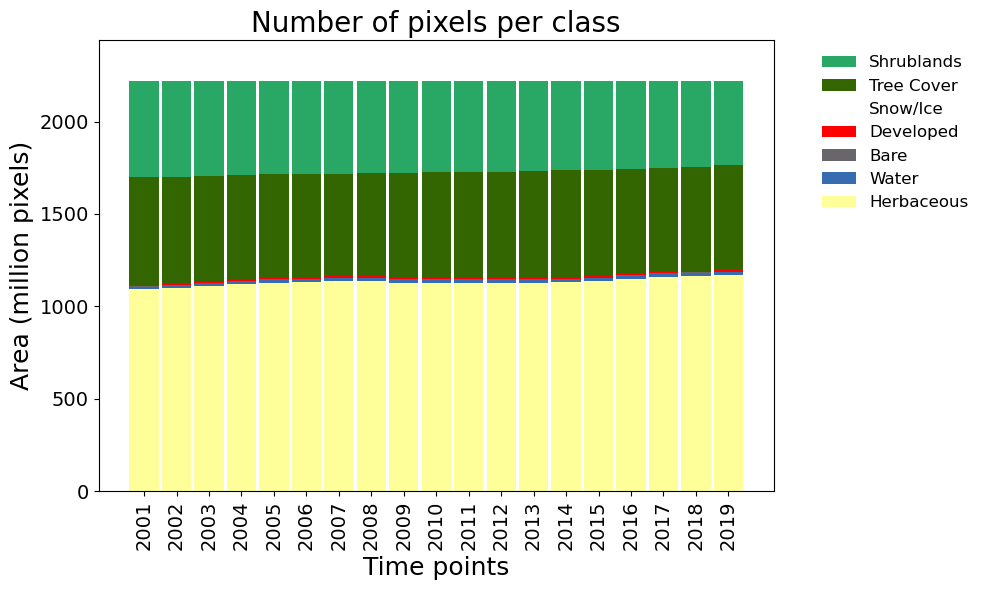

Plot saved successfully to: /Users/antoniofonseca/Downloads/graph_pixel_per_class.png


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# 1. Visualization Function
def plot_pixel_counts_from_csv(
    csv_path: str,
    class_labels_dict: dict,
    output_dir: str,
) -> None:
    """
    Read pixel counts from CSV and generate a formatted stacked bar chart.

    Parameters
    ----------
    csv_path : str
        Path to the CSV file containing pixel counts.
    class_labels_dict : dict
        Mapping of class IDs to metadata (name and color).
    output_dir : str
        Directory where the plot will be saved.

    Returns
    -------
    None
    """
    # 1.1. Load data from CSV
    if not os.path.exists(
        csv_path,
    ):
        raise FileNotFoundError(
            f"CSV file not found at: {csv_path}",
        )

    pivot_pixels = pd.read_csv(
        csv_path,
        index_col="Year",
    )
    years_array = pivot_pixels.index.values

    # 1.2. Determine Y-axis scaling factor and label
    max_val = pivot_pixels.to_numpy().max()

    if max_val >= 1_000_000_000_000:
        scale_factor = 1_000_000_000_000
        y_label = "Change (trillion pixels)"
    elif max_val >= 1_000_000_000:
        scale_factor = 1_000_000_000
        y_label = "Change (billion pixels)"
    elif max_val >= 1_000_000:
        scale_factor = 1_000_000
        y_label = "Change (million pixels)"
    elif max_val >= 1_000:
        scale_factor = 1_000
        y_label = "Change (thousand pixels)"
    elif max_val >= 100:
        scale_factor = 100
        y_label = "Change (hundred pixels)"
    else:
        scale_factor = 1
        y_label = "Change (pixels)"

    pivot_scaled = pivot_pixels / scale_factor

    # 1.3. Prepare color map and sorting logic
    class_ids_plot = sorted(
        class_labels_dict.keys(),
    )

    color_map = {
        class_labels_dict[class_id]["name"]: class_labels_dict[class_id]["color"]
        for class_id in class_ids_plot
    }

    # 1.4. Calculate Net Change for sorting
    first_year = years_array[0]
    last_year = years_array[-1]
    net_change_per_class = (
        pivot_scaled.loc[last_year]
        - pivot_scaled.loc[first_year]
    )

    # Map names back to IDs for tie-breaking
    name_to_id_map = {
        v["name"]: k
        for k, v in class_labels_dict.items()
    }

    df_sorting = net_change_per_class.to_frame(
        name="net_change",
    )
    df_sorting["class_id"] = df_sorting.index.map(
        name_to_id_map,
    )

    # Sort: Net Change (Desc) then Class ID (Desc)
    classes_for_stack = list(
        df_sorting.sort_values(
            by=[
                "net_change",
                "class_id",
            ],
            ascending=[
                False,
                False,
            ],
        ).index,
    )

    # Legend order: Reversed stack order
    classes_for_legend = list(
        reversed(
            classes_for_stack,
        ),
    )

    # 1.5. Generate the Stacked Bar Chart
    fig, ax = plt.subplots(
        figsize=(
            10,
            6,
        ),
    )

    x = np.arange(
        len(
            years_array,
        ),
    )
    width = 0.9
    base = np.zeros(
        len(
            years_array,
        ),
        dtype=float,
    )
    patches_by_class: dict[str, plt.Artist] = {}

    for cls in classes_for_stack:
        if cls not in pivot_scaled.columns:
            continue

        values_cls = pivot_scaled[cls].reindex(
            years_array,
            fill_value=0.0,
        ).values

        bars = ax.bar(
            x,
            values_cls,
            bottom=base,
            width=width,
            label=cls,
            color=color_map.get(
                cls,
                "gray",
            ),
        )
        patches_by_class[cls] = bars[0]
        base += values_cls

    # 1.6. Configure Axes and Labels
    ax.set_xticks(
        x,
    )
    ax.set_xticklabels(
        years_array,
    )

    # Adaptive rotation for X-axis labels
    n_labels = len(
        years_array,
    )
    if n_labels <= 7:
        rotation = 0
        ha = "center"
    elif n_labels <= 12:
        rotation = 45
        ha = "right"
    else:
        rotation = 90
        ha = "center"

    plt.setp(
        ax.get_xticklabels(),
        rotation=rotation,
        ha=ha,
    )

    ax.tick_params(
        axis="both",
        labelsize=14,
    )
    ax.set_ylabel(
        y_label,
        fontsize=18,
    )
    ax.set_xlabel(
        "Time points",
        fontsize=18,
    )
    ax.set_title(
        "Number of pixels per class",
        fontsize=20,
    )

    # 1.7. Y-axis limit and formatting
    y_max_scaled = base.max() * 1.1 if base.max() > 0 else 1.0
    ax.set_ylim(
        0,
        y_max_scaled,
    )
    ax.yaxis.set_major_locator(
        ticker.MaxNLocator(
            nbins=5,
            integer=True,
        ),
    )
    ax.yaxis.set_major_formatter(
        ticker.FormatStrFormatter(
            "%d",
        ),
    )

    # 1.8. Add Legend
    handles = [
        patches_by_class[cls]
        for cls in classes_for_legend
        if cls in patches_by_class
    ]
    labels = [
        cls
        for cls in classes_for_legend
        if cls in patches_by_class
    ]

    ax.legend(
        handles,
        labels,
        bbox_to_anchor=(
            1.05,
            1.0,
        ),
        loc="upper left",
        frameon=False,
        fontsize=12,
    )

    plt.tight_layout()

    # 1.9. Save and Show Figure
    out_fig = os.path.join(
        output_dir,
        "graph_pixel_per_class.png",
    )
    plt.savefig(
        out_fig,
        format="png",
        bbox_inches="tight",
        dpi=300,
    )
    plt.show()

    print(
        f"Plot saved successfully to: {out_fig}",
    )


# Execution of the plotting function with the defined parameters

# 2.1. Run the plotting function using the generated CSV
plot_pixel_counts_from_csv(
    csv_path=os.path.join(
        output_path,
        "pixels_per_class_per_year.csv",
    ),
    class_labels_dict=class_labels_dict,
    output_dir=output_path,
)

## **4.Generate the Transition Matrix**


---
This section performs the core spatial-temporal analysis by first processing multi year rasters into a consistent valid pixel mask. It executes a dual track transition analysis to compute individual interval matrices for step by step changes while simultaneously deriving aggregated components.

The process generates the following aggregated transition matrices:


1. *transition_matrix_sum*: The total sum of all transitions across all time intervals.

2. *transition_matrix_extent*: The end to end transition matrix from the first to the last year.

3. *transition_matrix_allocation_exchange*: Spatial swaps derived from the extent matrix.

4. *transition_matrix_allocation_shift*: Spatial displacement derived from the extent matrix.

5. *transition_matrix_alternation_exchange*: Temporal swaps captured at the pixel level trajectories.

6. *transition_matrix_alternation_shift*: Temporal displacement captured at the pixel level trajectories.

### 4.1 Transition matrix

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import Window
from tqdm import tqdm
import numba as nb

@nb.njit(nogil=True, cache=True)
def _build_lookup_table(
    classes_array: np.ndarray,
    max_val: int
) -> np.ndarray:
    """
    Construct a fast lookup table to map original class values to matrix indices.

    This enables O(1) complexity for finding the matrix index of a pixel value,
    avoiding slow dictionary lookups inside the processing loop.

    Parameters
    ----------
    classes_array : np.ndarray
        Sorted array containing all unique valid class values found in the rasters.
    max_val : int
        The maximum integer value present in the classes_array.

    Returns
    -------
    np.ndarray
        An array where index `i` corresponds to the pixel value, and the value
        at `lut[i]` is the corresponding index in the transition matrix.
        Values not in `classes_array` are set to -1.
    """
    # Initialize with -1 to represent "invalid" or "not in classes list"
    lut = np.full(max_val + 1, -1, dtype=np.int32)

    for idx, class_val in enumerate(classes_array):
        if class_val <= max_val:
            lut[class_val] = idx

    return lut

@nb.njit(nogil=True, cache=True)
def _accumulate_transitions_numba(
    start_pixels: np.ndarray,
    end_pixels: np.ndarray,
    matrix: np.ndarray,
    lut: np.ndarray
) -> None:
    """
    Accumulate transitions between two time steps into the matrix using JIT.

    This function performs the mathematically equivalent operation of:
    `matrix[class_to_idx[start], class_to_idx[end]] += 1`
    but does so at C-level speeds avoiding Python overhead.

    Parameters
    ----------
    start_pixels : np.ndarray
        1D array of pixel values at time T.
    end_pixels : np.ndarray
        1D array of pixel values at time T+1.
    matrix : np.ndarray
        The transition matrix to be updated in-place.
    lut : np.ndarray
        The lookup table mapping pixel values to matrix indices.

    Returns
    -------
    None
        The operation is performed in-place on the `matrix` argument.
    """
    n_pixels = start_pixels.shape[0]

    for i in range(n_pixels):
        val_t0 = start_pixels[i]
        val_t1 = end_pixels[i]

        # Safety check: ensure value is within LUT bounds
        if val_t0 >= len(lut) or val_t1 >= len(lut):
            continue

        # Retrieve matrix indices from LUT
        idx_t0 = lut[val_t0]
        idx_t1 = lut[val_t1]

        # If both pixels correspond to valid known classes, increment count
        if idx_t0 != -1 and idx_t1 != -1:
            matrix[idx_t0, idx_t1] += 1

def calculate_transition_matrices_optimized(
    file_list: list,
    output_dir: str,
    no_data_value: int,
    block_size: int = 1024
) -> tuple:
    """
    Calculate transition matrices for a time series of rasters using optimized
    block processing and Numba acceleration.

    This function reads rasters in spatial chunks to conserve memory and uses
    compiled code to calculate pixel transitions, ensuring both high performance
    and strict mathematical fidelity to standard Markov chain transition counting.

    Parameters
    ----------
    file_list : list of str
        List of file paths to the input raster images.
    output_dir : str
        Directory path where the resulting CSV matrices will be saved.
    no_data_value : int
        The value representing NoData in the input rasters. Pixels with this
        value in *any* year will be excluded from the transition logic for
        that specific spatial location.
    block_size : int, optional
        The size of the spatial window (width and height) for processing.
        Default is 1024.

    Returns
    -------
    tuple
        A tuple containing:
        - interval_matrices (dict): Keys are interval strings (e.g., "2000-2001"),
          values are np.ndarrays of the transition counts.
        - years (list of int): Sorted list of years extracted from filenames.
        - sorted_classes (np.ndarray): Array of unique classes found.

    Raises
    ------
    ValueError
        If the file list is empty or if dimensions mismatch.
    """
    if not file_list:
        raise ValueError("File list is empty.")

    # 1. Sort files and extract years using regex
    image_paths = sorted(file_list)
    years = []
    for path in image_paths:
        # Assumes filename contains a 4-digit year (e.g., "cover_2000.tif")
        match = re.search(r"(\d{4})\.tif$", os.path.basename(path))
        years.append(int(match.group(1)) if match else 0)

    print(f"Processing transition matrices for years: {years}")

    # 2. Open all datasets ONCE to optimize I/O
    # This creates file handles but does not load data into RAM yet.
    srcs = [rasterio.open(p) for p in image_paths]
    height = srcs[0].height
    width = srcs[0].width

    # 3. Smart Class Detection
    # To build the matrix dimensions, we need to know all possible classes.
    # Scanning the first, middle, and last image is a heuristic to avoid reading everything.
    print("Scanning for unique classes...")
    all_classes = set()
    scan_indices = [0, len(srcs) // 2, -1]  # First, Middle, Last

    for idx in scan_indices:
        if idx < len(srcs):
            # Read band 1 to find unique values
            data = srcs[idx].read(1)
            uniques = np.unique(data)
            all_classes.update(uniques)

    # Clean NoData values from the set of valid classes
    all_classes.discard(no_data_value)
    for src in srcs:
        if src.nodata is not None:
            all_classes.discard(src.nodata)

    # Convert to a sorted numpy array of integers for indexing
    sorted_classes = np.array(sorted(list(all_classes)), dtype=np.int32)
    n_classes = len(sorted_classes)
    print(f"Unique classes found: {sorted_classes}")

    if n_classes == 0:
        print("Warning: No valid classes found. Matrices will be empty.")
        for src in srcs:
            src.close()
        return {}, years, sorted_classes

    # Build Numba Lookup Table
    # Determine the size needed for the LUT (max value + 1)
    max_class_val = int(sorted_classes.max())
    # Create the LUT to map [Pixel Value] -> [Matrix Index]
    lut = _build_lookup_table(sorted_classes, max_val=max(255, max_class_val))

    # 4. Initialize result matrices
    # Format: "YearA-YearB"
    intervals = [f"{years[t]}-{years[t + 1]}" for t in range(len(years) - 1)]
    interval_matrices = {
        interval: np.zeros((n_classes, n_classes), dtype=np.float64)
        for interval in intervals
    }

    # 5. Process in Spatial Blocks (Windows)
    rows = range(0, height, block_size)
    cols = range(0, width, block_size)
    total_blocks = len(rows) * len(cols)

    with tqdm(total=total_blocks, desc="Computing Matrices", unit="block") as pbar:
        for r_off in rows:
            for c_off in cols:
                # Define the current window
                window = Window(
                    c_off,
                    r_off,
                    min(block_size, width - c_off),
                    min(block_size, height - r_off)
                )

                # Load data for this window across all years
                stack_list = []
                combined_nodata_mask = None

                for src in srcs:
                    # Read the window
                    data = src.read(1, window=window)

                    # Create mask for this layer
                    # Mask if value is user-defined NoData OR metadata NoData
                    mask = (data == no_data_value)
                    if src.nodata is not None:
                        mask |= (data == src.nodata)

                    # Handle NaNs if data is floating point
                    if np.issubdtype(data.dtype, np.floating):
                        mask |= np.isnan(data)

                    # Accumulate mask (OR logic):
                    # If pixel is NoData in ANY year, it is invalid for the whole series
                    if combined_nodata_mask is None:
                        combined_nodata_mask = mask
                    else:
                        combined_nodata_mask |= mask

                    stack_list.append(data)

                # Determine valid pixels (where NO layer has NoData)
                valid_mask = ~combined_nodata_mask

                # Optimization: Skip empty blocks
                if not np.any(valid_mask):
                    pbar.update(1)
                    continue

                # Flatten arrays using the valid mask
                # This creates 1D arrays containing only valid pixel trajectories
                # We cast to int32 for Numba compatibility with the LUT
                flat_stack = [
                    layer[valid_mask].astype(np.int32) for layer in stack_list
                ]

                # 6. Calculate transitions for consecutive intervals
                for t in range(len(years) - 1):
                    start_pixels = flat_stack[t]
                    end_pixels = flat_stack[t + 1]

                    # Numba Accumulation (In-Place update of the matrix)
                    _accumulate_transitions_numba(
                        start_pixels,
                        end_pixels,
                        interval_matrices[intervals[t]],
                        lut
                    )

                pbar.update(1)

    # 7. Close file handlers
    for src in srcs:
        src.close()

    # 8. Save matrices to CSV automatically
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for interval_name, mat in interval_matrices.items():
        fname = f"transition_matrix_{interval_name}.csv"
        out_csv = os.path.join(output_dir, fname)

        # Create DataFrame for labeled CSV output
        df = pd.DataFrame(
            mat,
            index=sorted_classes,
            columns=sorted_classes
        )
        df.to_csv(out_csv)

    print(f"All transition matrices saved to: {output_dir}")

    return interval_matrices, years, sorted_classes


# --- Execution ---

# Ensure these variables are defined in your notebook:
# image_paths: list of file paths
# output_path: directory to save CSVs
# noData_value: the nodata value (e.g., 0, -9999)

matrices, years_list, classes_found = calculate_transition_matrices_optimized(
    file_list=image_paths,
    output_dir=output_path,
    no_data_value=noData_value
)

Processing transition matrices for years: [2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2014, 2015, 2016, 2017, 2018, 2019]
Scanning for unique classes (heuristic scan)...
Unique classes found: [1 2 3 4 5 6 7]


Computing Matrices: 100%|████████████████████████████████████| 5852/5852 [4:45:46<00:00,  2.93s/block]


All transition matrices saved to: /Users/antoniofonseca/Downloads/


### 4.2 Aggregate matrices

In [ ]:
import os
import re
import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import Window
from tqdm import tqdm
import numba as nb

@nb.njit(
    nogil=True,
    cache=True,
)
def _build_lookup_table(
    classes_array: np.ndarray,
    max_val: int,
) -> np.ndarray:
    """
    Create a fast lookup array to map pixel values to matrix indices.

    Parameters
    ----------
    classes_array : np.ndarray
        1D array containing the unique class identifiers.
    max_val : int
        The maximum pixel value present in the data to define LUT size.

    Returns
    -------
    np.ndarray
        A 1D array where the index is the pixel value and the value 
        is the corresponding matrix index.
    """
    # 1.1. Initialize the Lookup Table (LUT) with -1 (invalid)
    lut = np.full(
        max_val + 1,
        -1,
        dtype=np.int32,
    )

    # 1.2. Map each class value to its positional index
    for idx, class_val in enumerate(
        classes_array,
    ):
        if class_val <= max_val:
            lut[
                class_val
            ] = idx

    return lut

@nb.njit(
    nogil=True,
    parallel=True
)
@nb.njit(
    nogil=True, 
    parallel=True,
)
def _process_block_accumulation(
    stack_data: np.ndarray,
    mat_sum: np.ndarray,
    mat_ext: np.ndarray,
    mat_ax: np.ndarray,
    mat_as: np.ndarray,
    lut: np.ndarray,
    n_classes: int,
) -> None:
    """
    Process a 3D block to calculate and accumulate aggregated transition matrices.

    This function implements the pixel-level decomposition logic:
    1. Construct M_r (Individual Transition) and E_r (End-to-End).
    2. Calculate A_r = M_r - E_r (Alternation).
    3. Decompose A_r into Ax_r (Exchange) and As_r (Shift).
    4. Accumulate results into global matrices.

    Parameters
    ----------
    stack_data : np.ndarray
        3D array of shape (time, height, width) with pixel class values.
    mat_sum : np.ndarray
        Global 2D array to accumulate M_r (Total transitions).
    mat_ext : np.ndarray
        Global 2D array to accumulate E_r (End-to-end transitions).
    mat_ax : np.ndarray
        Global 2D array to accumulate Ax_r (Alternation Exchange).
    mat_as : np.ndarray
        Global 2D array to accumulate As_r (Alternation Shift).
    lut : np.ndarray
        Lookup table to map class values to matrix indices.
    n_classes : int
        Number of unique classes (size of the transition matrices).

    Returns
    -------
    None
        The function updates the global matrices in-place.
    """
    n_pixels = stack_data.shape[0]
    n_times = stack_data.shape[1]

    # We iterate over pixels in parallel
    for i in nb.prange(n_pixels):
        # Extract trajectory for this pixel
        traj = stack_data[i, :]

        # Check if start and end are valid
        val_start = traj[0]
        val_end = traj[n_times - 1]

        if val_start >= len(lut) or val_end >= len(lut):
            continue

        idx_start = lut[val_start]
        idx_end = lut[val_end]

        if idx_start == -1 or idx_end == -1:
            continue

        # --- 1. Calculate M_r (transitions count for this pixel) ---
        # We need a temporary local matrix for this pixel.
        # Since allocating (n,n) inside a loop is expensive, we try to use
        # stack arrays or simple logic. For Numba, explicit loops are fast.

        # To avoid allocating an NxN matrix for EVERY pixel (which kills RAM),
        # we calculate contributions on the fly.

        # A. Accumulate Sum Matrix (M_r contribution)
        # We also need to store M_r locally to calculate Alternation later.
        # For small N (classes < 50), a stack allocation is fine.
        m_r = np.zeros((n_classes, n_classes), dtype=np.int32)

        valid_traj = True
        for t in range(n_times - 1):
            v1 = traj[t]
            v2 = traj[t+1]
            if v1 >= len(lut) or v2 >= len(lut):
                valid_traj = False
                break
            i1 = lut[v1]
            i2 = lut[v2]
            if i1 == -1 or i2 == -1:
                valid_traj = False
                break

            m_r[i1, i2] += 1

        if not valid_traj:
            continue

        # Add M_r to global Sum Matrix (Thread-safe atomic add needed or reduction)
        # Since standard atomic add for 2D arrays isn't straightforward in all Numba versions,
        # and we have many classes, we simply add to the output matrices.
        # Note: parallel=True with array reduction is handled by Numba automatically
        # if we do `mat += ...`. However, for complex logic, standard loops are safer.
        # To keep it simple and correct without race conditions, we use a manual lock
        # or simply rely on Numba's reduction capabilities for the outer loop.

        # B. Calculate E_r (End-to-End)
        # E_r has only ONE entry: [start, end] = 1
        # (Assuming the pixel represents 1 unit of area)

        # C. Calculate A_r = M_r - E_r
        # We do this element-wise.

        # D. Calculate Alternation Components
        # Ax_r_ij = min(A_r_ij, A_r_ji)
        # As_r_ij = A_r_ij - Ax_r_ij

        for r_idx in range(n_classes):
            for c_idx in range(n_classes):
                # Get M_r value
                val_m = m_r[r_idx, c_idx]

                # Get E_r value (1 if it matches start/end, else 0)
                val_e = 0
                if r_idx == idx_start and c_idx == idx_end:
                    val_e = 1

                # Calculate A_r
                val_a = val_m - val_e

                # We need the transpose A_r_ji to calculate Exchange
                # Reconstruct A_r_ji on the fly
                val_m_T = m_r[c_idx, r_idx]
                val_e_T = 0
                if c_idx == idx_start and r_idx == idx_end:
                    val_e_T = 1
                val_a_T = val_m_T - val_e_T

                # Ax = min(A, A.T) -> clamped to 0
                val_ax = 0
                if val_a < val_a_T:
                    val_ax = val_a
                else:
                    val_ax = val_a_T

                if val_ax < 0:
                    val_ax = 0

                # As = A - Ax
                val_as = val_a - val_ax

                # --- ACCUMULATE TO GLOBAL OUTPUTS ---
                # Numba handles the reduction for these array slices in parallel loops
                mat_sum[r_idx, c_idx] += val_m
                mat_ext[r_idx, c_idx] += val_e
                mat_ax[r_idx, c_idx]  += val_ax
                mat_as[r_idx, c_idx]  += val_as


def calculate_aggregated_matrices_optimized(
    file_list,
    output_dir,
    no_data_value,
    all_classes_array,
    block_size=1024,
):
    """
    Calculate aggregated transition matrices using block processing and Numba.

    This function coordinates the accumulation of transitions (Sum), 
    end-to-end change (Extent), and the decomposition of alternation 
    into Exchange and Shift components.

    Parameters
    ----------
    file_list : list of str
        List of paths to the raster files.
    output_dir : str
        Directory to save the resulting transition matrices as CSVs.
    no_data_value : int
        Specific value to be treated as NoData and ignored in calculations.
    all_classes_array : np.ndarray
        Sorted array of all unique classes found in the study area.
    block_size : int, optional
        Size of the square blocks to process at once. Default is 1024.

    Returns
    -------
    dict of np.ndarray
        A dictionary containing the following transition matrices:
        - 'mat_sum': Total individual transitions (M_r).
        - 'mat_ext': End-to-end transitions (E_r).
        - 'mat_ax': Alternation Exchange transitions (Ax_r).
        - 'mat_as': Alternation Shift transitions (As_r).
    """

    # 1. Setup
    image_paths = sorted(file_list)
    srcs = [rasterio.open(p) for p in image_paths]
    height = srcs[0].height
    width = srcs[0].width

    n_classes = len(all_classes_array)
    max_val = int(all_classes_array.max())

    # Build Lookup Table
    lut = _build_lookup_table(all_classes_array.astype(np.int32), max(255, max_val))

    # Initialize global accumulation matrices (Float64 to prevent overflow)
    mat_sum = np.zeros((n_classes, n_classes), dtype=np.float64)
    mat_ext = np.zeros((n_classes, n_classes), dtype=np.float64)
    mat_ax  = np.zeros((n_classes, n_classes), dtype=np.float64)
    mat_as  = np.zeros((n_classes, n_classes), dtype=np.float64)

    # 2. Process Blocks
    rows = range(0, height, block_size)
    cols = range(0, width, block_size)
    total_blocks = len(rows) * len(cols)

    with tqdm(total=total_blocks, desc="Aggregating Matrices", unit="block") as pbar:
        for r_off in rows:
            for c_off in cols:
                window = Window(
                    c_off, r_off,
                    min(block_size, width - c_off),
                    min(block_size, height - r_off)
                )

                # Load block stack
                stack_list = []
                combined_mask = None

                for src in srcs:
                    data = src.read(1, window=window)

                    # Create mask
                    mask = (data == no_data_value)
                    if src.nodata is not None:
                        mask |= (data == src.nodata)

                    if combined_mask is None:
                        combined_mask = mask
                    else:
                        combined_mask |= mask

                    stack_list.append(data)

                # Filter valid pixels
                valid_mask = ~combined_mask
                if not np.any(valid_mask):
                    pbar.update(1)
                    continue

                # Flatten valid pixels: Shape becomes (n_valid_pixels, n_times)
                # Transpose after stacking to get pixels as rows
                flat_stack = np.array([layer[valid_mask] for layer in stack_list]).T.astype(np.int32)

                # Call Numba Function
                _process_block_accumulation(
                    flat_stack,
                    mat_sum,
                    mat_ext,
                    mat_ax,
                    mat_as,
                    lut,
                    n_classes
                )

                pbar.update(1)

    # Close files
    for src in srcs:
        src.close()

    # 3. Final Decomposition for Extent (Aggregate Level)
    # Eq 1 & 2: Decompose Extent into Exchange and Shift (Allocation)
    # Allocation Exchange = min(E, E.T)
    mat_alloc_ex = np.maximum(0, np.minimum(mat_ext, mat_ext.T))
    # Allocation Shift = E - Allocation Exchange
    mat_alloc_sh = mat_ext - mat_alloc_ex

    results = {
        "sum": mat_sum,
        "extent": mat_ext,
        "allocation_exchange": mat_alloc_ex,
        "allocation_shift": mat_alloc_sh,
        "alternation_exchange": mat_ax,
        "alternation_shift": mat_as,
    }

    # 4. Save to CSV
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Extract years for filename
    years = []
    for path in image_paths:
        match = re.search(r"(\d{4})\.tif$", os.path.basename(path))
        years.append(int(match.group(1)) if match else 0)
    interval_str = f"{years[0]}-{years[-1]}"

    for name, mat in results.items():
        fname = f"transition_matrix_{name}_{interval_str}.csv"
        out_csv = os.path.join(output_dir, fname)
        pd.DataFrame(
            mat,
            index=all_classes_array,
            columns=all_classes_array
        ).to_csv(out_csv)

    print(f"Aggregated matrices saved to {output_dir}")
    return results

# Execution of the optimized aggregation function with defined parameters

# Ensure all_classes is a numpy array from previous step
# sorted_classes comes from the previous function's return
aggregated_results = calculate_aggregated_matrices_optimized(
    file_list=image_paths,
    output_dir=output_path,
    no_data_value=noData_value,
    all_classes_array=classes_found # Use the array returned by the previous function
)

Aggregating Matrices: 100%|███████████████████████████████████████████████████████████████████| 5852/5852 [4:51:09<00:00,  2.99s/block]


Aggregated matrices saved to /Users/antoniofonseca/Downloads/


## **5.Heat Maps**


---

### 5.1 Input Setup and Integrity Checks

In [13]:
# 1. Validate global inputs
assert isinstance(
    years,
    (
        list,
        tuple,
    ),
) and len(years) >= 2, "`years` missing or invalid."

assert isinstance(
    output_path,
    str,
) and output_path, "`output_path` missing or invalid."

assert isinstance(
    class_labels_dict,
    dict,
) and class_labels_dict, "`class_labels_dict` missing or invalid."


# 2. Helper to extract year digits for filename matching
def _extract_year_str(
    val,
) -> str:
    """
    Extract the first sequence of digits from a year string or integer.

    Parameters
    ----------
    val : str or int
        The value containing the year (e.g., "time_2000" or 2000).

    Returns
    -------
    str
        The extracted year digits.
    """
    match = re.search(
        r"(\d+)",
        str(val),
    )
    return match.group(1) if match else str(val)


str_y0 = _extract_year_str(
    years[0],
)
str_y1 = _extract_year_str(
    years[-1],
)

# 3. Define paths for all 6 generated matrices
CSV_SUM = os.path.join(
    output_path,
    f"transition_matrix_sum_{str_y0}-{str_y1}.csv",
)
CSV_EXT = os.path.join(
    output_path,
    f"transition_matrix_extent_{str_y0}-{str_y1}.csv",
)
CSV_EXT_EXC = os.path.join(
    output_path,
    f"transition_matrix_allocation_exchange_{str_y0}-{str_y1}.csv",
)
CSV_EXT_SHIFT = os.path.join(
    output_path,
    f"transition_matrix_allocation_shift_{str_y0}-{str_y1}.csv",
)
CSV_ALT_EXC = os.path.join(
    output_path,
    f"transition_matrix_alternation_exchange_{str_y0}-{str_y1}.csv",
)
CSV_ALT_SHIFT = os.path.join(
    output_path,
    f"transition_matrix_alternation_shift_{str_y0}-{str_y1}.csv",
)

# 4. Check for existence of all required files
required_files = [
    CSV_SUM,
    CSV_EXT,
    CSV_EXT_EXC,
    CSV_EXT_SHIFT,
    CSV_ALT_EXC,
    CSV_ALT_SHIFT,
]

for path_csv in required_files:
    if not os.path.exists(path_csv):
        raise FileNotFoundError(
            f"Missing required CSV: {path_csv}",
        )

print(
    "Found all base CSVs.",
)

Found all base CSVs.


### 5.2 Data Transformation and Matrix Alignment

In [14]:
def load_square_matrix(
    csv_path: str,
) -> pd.DataFrame:
    """
    Load a square transition matrix from CSV and align row/column labels.

    Parameters
    ----------
    csv_path : str
        Path to a CSV file where the first column and the header row
        contain class IDs (or labels), and the remaining cells contain
        transition counts.

    Returns
    -------
    pd.DataFrame
        Square DataFrame with string labels on both rows and columns.
        When row and column labels differ, their union is used and
        missing cells are filled with 0.0.
    """
    df = pd.read_csv(
        csv_path,
        index_col=0,
    )
    df.index = df.index.map(str)
    df.columns = df.columns.map(str)

    if list(df.index) != list(df.columns):
        labels = sorted(
            set(df.index).union(df.columns),
            key=lambda x: int(x),
        )
        df = df.reindex(
            index=labels,
            columns=labels,
        ).fillna(0.0)

    if df.shape[0] != df.shape[1]:
        raise ValueError(
            f"Matrix not square after alignment: {csv_path}",
        )

    return df


def label_id_to_name(
    labels: Iterable[str],
) -> list[str]:
    """
    Map class ID strings to human-readable names using ``class_labels_dict``.

    Parameters
    ----------
    labels : Iterable[str]
        Class IDs as strings (e.g. ``["0", "1", "2"]``).

    Returns
    -------
    list[str]
        List of class names mapped from IDs.
    """
    id_to_name = {
        int(k): v.get(
            "rename",
            v.get(
                "name",
                str(k),
            ),
        )
        for k, v in class_labels_dict.items()
    }

    names: list[str] = []
    for lab in labels:
        try:
            cid = int(str(lab))
            names.append(
                id_to_name.get(
                    cid,
                    str(lab),
                ),
            )
        except Exception:
            names.append(str(lab))

    return names


def compute_net_change_from_sum(
    df_sum: pd.DataFrame,
) -> pd.Series:
    """
    Compute net change per class from a SUM transition matrix.

    Parameters
    ----------
    df_sum : pd.DataFrame
        Square transition matrix representing total transitions over
        the full time span.

    Returns
    -------
    pd.Series
        Net change for each class (gains - losses).
    """
    M = df_sum.values.astype(float).copy()

    # Remove persistence on the diagonal for the calculation
    np.fill_diagonal(
        M,
        0.0,
    )

    gains = M.sum(
        axis=0,
    )
    losses = M.sum(
        axis=1,
    )

    net_change = gains - losses

    return pd.Series(
        net_change,
        index=df_sum.index,
    )


def reorder_matrices_by_net_change(
    df_sum: pd.DataFrame,
    df_ext: pd.DataFrame,
    df_ext_exc: pd.DataFrame,
    df_ext_shift: pd.DataFrame,
    df_alt_exc: pd.DataFrame,
    df_alt_shift: pd.DataFrame,
) -> tuple[
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
    pd.DataFrame,
]:
    """
    Reorder rows and columns of all matrices using net change from ``df_sum``.

    Parameters
    ----------
    df_sum : pd.DataFrame
        SUM transition matrix (used for sorting logic).
    df_ext : pd.DataFrame
        Extent matrix.
    df_ext_exc : pd.DataFrame
        Extent Exchange matrix.
    df_ext_shift : pd.DataFrame
        Extent Shift matrix.
    df_alt_exc : pd.DataFrame
        Alternation Exchange matrix.
    df_alt_shift : pd.DataFrame
        Alternation Shift matrix.

    Returns
    -------
    tuple[pd.DataFrame, ...]
        All input dataframes reindexed so that:
        - largest losers (most negative net change) are at the top/left.
        - largest gainers (most positive net change) are at the bottom/right.
    """
    net_change = compute_net_change_from_sum(
        df_sum=df_sum,
    )
    order_labels = (
        net_change.sort_values(
            ascending=True,
        )
        .index.tolist()
    )

    def _reorder(
        df: pd.DataFrame,
    ) -> pd.DataFrame:
        return df.reindex(
            index=order_labels,
            columns=order_labels,
        )

    return (
        _reorder(df_sum),
        _reorder(df_ext),
        _reorder(df_ext_exc),
        _reorder(df_ext_shift),
        _reorder(df_alt_exc),
        _reorder(df_alt_shift),
    )

# 1. Load the base Sum and Extent matrices
df_sum = load_square_matrix(
    CSV_SUM,
)
df_ext = load_square_matrix(
    CSV_EXT,
)

# 2. Load the 4 Decomposed Component Matrices
df_ext_exc = load_square_matrix(
    CSV_EXT_EXC,
)
df_ext_shift = load_square_matrix(
    CSV_EXT_SHIFT,
)
df_alt_exc = load_square_matrix(
    CSV_ALT_EXC,
)
df_alt_shift = load_square_matrix(
    CSV_ALT_SHIFT,
)

# 3. Reorder all matrices based on Net Change (Losers to Gainers)
# This function (defined in the previous cell) ensures all 6 matrices
# share the exact same row/column order for consistent visualization.
(
    df_sum,
    df_ext,
    df_ext_exc,
    df_ext_shift,
    df_alt_exc,
    df_alt_shift,
) = reorder_matrices_by_net_change(
    df_sum=df_sum,
    df_ext=df_ext,
    df_ext_exc=df_ext_exc,
    df_ext_shift=df_ext_shift,
    df_alt_exc=df_alt_exc,
    df_alt_shift=df_alt_shift,
)

print("Successfully loaded and reordered all 6 matrices:",)
print("1. Sum",)
print("2. Extent",)
print("3. Allocation Exchange",)
print("4. Quantity & Allocation Shift",)
print("5. Alternation Exchange",)
print("6. Alternation Shift",)

Successfully loaded and reordered all 6 matrices:
1. Sum
2. Extent
3. Allocation Exchange
4. Quantity & Allocation Shift
5. Alternation Exchange
6. Alternation Shift


### 5.3 Visualization Engine and Heatmap Rendering

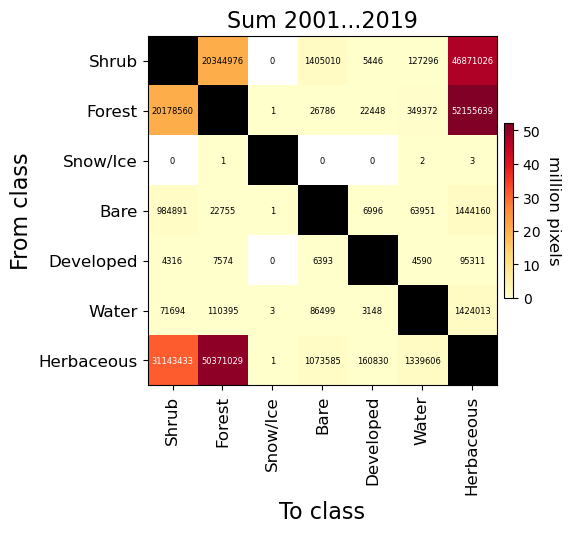

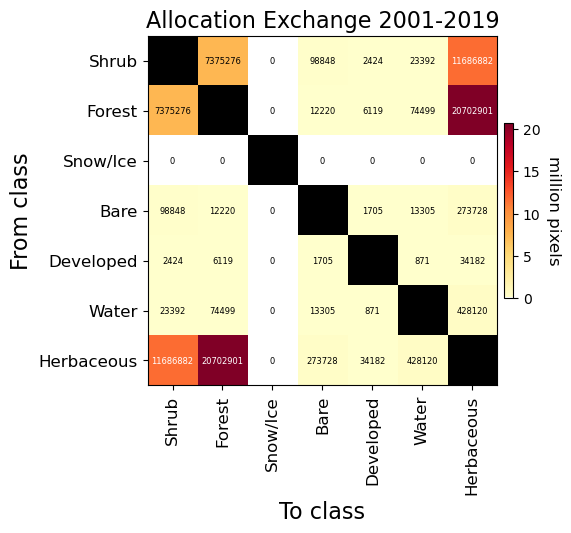

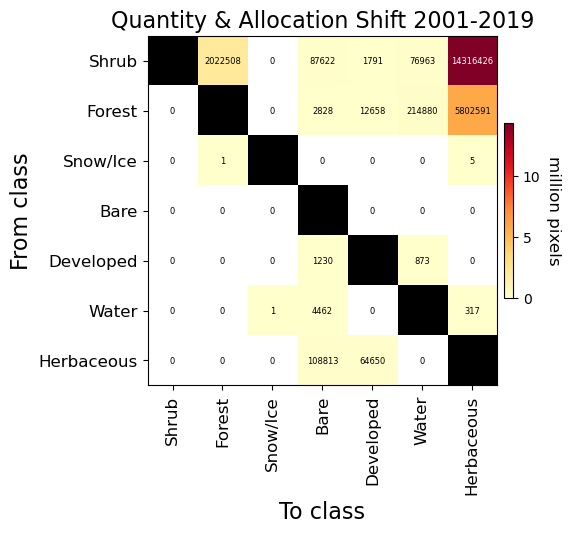

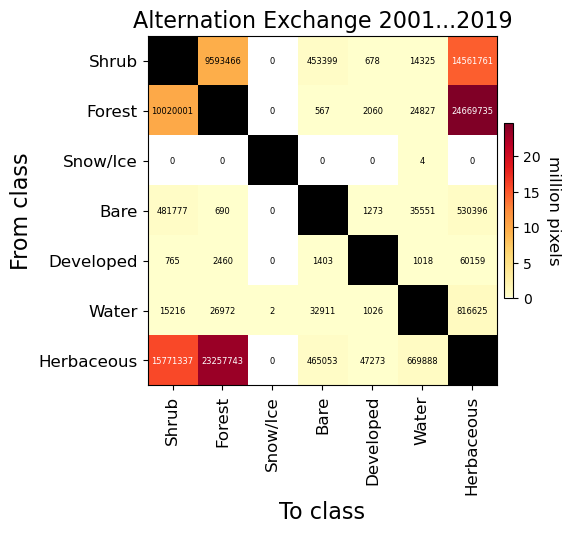

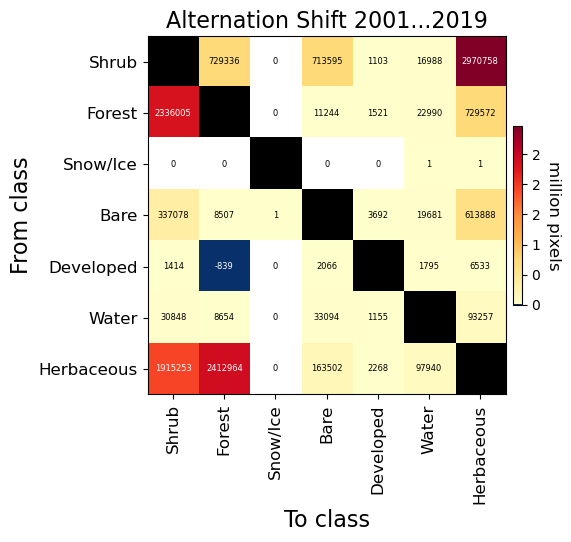

Saved all heat maps:
1. /Users/antoniofonseca/Downloads/heatmap_sum_2001-2019.png
2. /Users/antoniofonseca/Downloads/heatmap_allocation_exchange_2001-2019.png
3. /Users/antoniofonseca/Downloads/heatmap_quantiy_allocation_shift_2001-2019.png
4. /Users/antoniofonseca/Downloads/heatmap_alternation_exchange_2001...2019.png
5. /Users/antoniofonseca/Downloads/heatmap_alternation_shift_2001...2019.png


In [15]:
def annotate_heatmap(
    ax: plt.Axes,
    M: np.ndarray,
    fontsize: int = 8,
) -> None:
    """
    Annotate a heatmap with integer cell values and adaptive text color.

    Parameters
    ----------
    ax : matplotlib.axes.Axes
        The axes object where the heatmap is plotted.
    M : np.ndarray
        The matrix containing the values to display.
    fontsize : int, optional
        The font size of the annotations (default is 8).

    Returns
    -------
    None
    """
    if M.size == 0:
        return

    M_off = M.copy()
    np.fill_diagonal(
        M_off,
        np.nan,
    )
    data_off = M_off[np.isfinite(M_off)]

    has_pos = np.any(data_off > 0)
    has_neg = np.any(data_off < 0)

    max_pos = float(np.nanmax(data_off[data_off > 0])) if has_pos else 0.0
    min_neg = float(np.nanmin(data_off[data_off < 0])) if has_neg else 0.0

    thresh_pos = 0.5 * max_pos if has_pos else np.inf
    thresh_neg = 0.5 * min_neg if has_neg else -np.inf

    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            # Skip diagonal annotation to keep it clean black
            if i == j:
                continue

            v = float(M[i, j])
            txt = f"{int(round(v))}"

            if i == j:
                color = "white"
            else:
                if (
                    has_pos
                    and v >= thresh_pos
                ) or (
                    has_neg
                    and v <= thresh_neg
                ):
                    color = "white"
                else:
                    color = "black"

            ax.text(
                j,
                i,
                txt,
                ha="center",
                va="center",
                fontsize=fontsize,
                color=color,
                clip_on=True,
            )


def _unit_label(
    suffix: str,
    base_label: str = "number of pixels",
) -> str:
    """
    Build a descriptive label for the colorbar based on a unit suffix.

    Parameters
    ----------
    suffix : str
        The suffix for the unit (e.g., 'k', 'M').
    base_label : str, optional
        The base label text (default is "Number of pixels").

    Returns
    -------
    str
        The formatted unit label.
    """
    mapping = {
        "": base_label,
        "hundreds": "hundred pixels",
        "k": "thousand pixels",
        "M": "million pixels",
        "B": "billion pixels",
        "T": "trillion pixels",
    }

    return mapping.get(
        suffix,
        f"{base_label} ({suffix})",
    )


def _unit_formatter(
    factor: float,
    suffix: str,
    decimals: int = 1,
) -> mticker.FuncFormatter:
    """
    Build a tick formatter that scales values and appends a suffix.

    Parameters
    ----------
    factor : float
        The factor to divide the values by (e.g., 1000 for 'k').
    suffix : str
        The string suffix to append to the formatted value.
    decimals : int, optional
        The number of decimal places to include (default is 1).

    Returns
    -------
    matplotlib.ticker.FuncFormatter
        A formatter function for the plot ticks.
    """
    fmt = f"{{:.{decimals}f}}{suffix}"

    def _fmt(
        x: float,
        pos: int,
    ) -> str:
        return fmt.format(x / factor)

    return mticker.FuncFormatter(_fmt)


def plot_heatmap(
    df: pd.DataFrame,
    title: str,
    save_path: Optional[str] = None,
    figsize: Optional[Tuple[float, float]] = None,
    cmap: str = "YlOrRd",
    vmin: float = 0.0,
    vmax: Optional[float] = None,
    rotate_xticks_deg: int = 90,
    cbar_label: str = "Number of pixels",
    annotate: bool = True,
    cell_size_inch: float = 0.8,
    tick_fontsize: Optional[int] = None,
    ann_fontsize: int = 8,
    cbar_fraction: float = 0.025,
    cbar_pad: float = 0.02,
    tick_fontsize_x: Optional[int] = None,
    tick_fontsize_y: Optional[int] = None,
    axis_label_fontsize: Optional[int] = None,
    title_fontsize: Optional[int] = None,
) -> None:
    """
    Plot a square matrix as a heatmap with adaptive integer colorbar and dual scaling.

    Parameters
    ----------
    df : pd.DataFrame
        The square dataframe to plot.
    title : str
        The title of the plot.
    save_path : str, optional
        Path to save the figure image.
    figsize : tuple, optional
        Figure size in inches (width, height).
    cmap : str, optional
        Colormap name (default is "YlOrRd").
    vmin : float, optional
        Minimum value for colormap scaling.
    vmax : float, optional
        Maximum value for colormap scaling.
    rotate_xticks_deg : int, optional
        Rotation angle for x-axis ticks.
    cbar_label : str, optional
        Label for the colorbar.
    annotate : bool, optional
        Whether to annotate cells with values.
    cell_size_inch : float, optional
        Size of each cell in inches used for auto-figsize.
    tick_fontsize : int, optional
        Deprecated; use tick_fontsize_x/y.
    ann_fontsize : int, optional
        Font size for annotations.
    cbar_fraction : float, optional
        Fraction of original axes to use for colorbar.
    cbar_pad : float, optional
        Padding between axes and colorbar.
    tick_fontsize_x : int, optional
        Font size for x-axis ticks.
    tick_fontsize_y : int, optional
        Font size for y-axis ticks.
    axis_label_fontsize : int, optional
        Font size for axis labels.
    title_fontsize : int, optional
        Font size for the title.

    Returns
    -------
    None
    """
    if tick_fontsize_x is None or tick_fontsize_y is None:
        raise ValueError(
            "Set `tick_fontsize_x` and `tick_fontsize_y` explicitly.",
        )

    if axis_label_fontsize is None:
        axis_label_fontsize = 12

    if title_fontsize is None:
        title_fontsize = 14

    labels = list(
        df.index,
    )
    matrix_values = df.values.astype(
        float,
    )

    # Prepare scale ignoring diagonal to highlight transitions
    matrix_scale = matrix_values.copy()
    np.fill_diagonal(
        matrix_scale,
        0.0,
    )
    finite_vals = matrix_scale[
        np.isfinite(
            matrix_scale,
        )
    ]

    # Define effective limits for the color scale
    if finite_vals.size == 0:
        has_negative = False
        vmin_eff, vmax_eff = 0.0, 1.0
    else:
        has_negative = float(np.nanmin(finite_vals)) < 0.0
        min_val = float(np.nanmin(finite_vals))
        max_val = float(np.nanmax(finite_vals))

        if has_negative:
            # Use data bounds for divergent scaling
            vmin_eff, vmax_eff = min_val, max_val
        else:
            vmin_eff = vmin
            vmax_eff = float(max_val) if vmax is None else float(vmax)

        if vmin_eff == vmax_eff:
            vmax_eff += 1.0

    nrows, ncols = df.shape
    if figsize is None:
        figsize = (
            cell_size_inch * ncols,
            cell_size_inch * nrows,
        )

    fig, ax = plt.subplots(
        figsize=figsize,
        constrained_layout=True,
    )

    # Plot layers (Negative in Blues, Positive in YlOrRd)
    cmap_neg = mcolors.LinearSegmentedColormap.from_list("CustomBlues", ["#08306b", "#b3e0ff"])
    if has_negative:
        matrix_pos = np.ma.masked_less_equal(matrix_values, 0.0)
        norm_pos = mcolors.Normalize(vmin=0.0, vmax=vmax_eff)
        ax.imshow(
            matrix_pos,
            aspect="equal",
            cmap=plt.cm.YlOrRd,
            norm=norm_pos,
        )
        matrix_neg = np.ma.masked_where(matrix_values >= 0.0, matrix_values)
        norm_neg = mcolors.Normalize(vmin=vmin_eff, vmax=0.0)
        ax.imshow(
            matrix_neg,
            aspect="equal",
            cmap=cmap_neg,
            norm=norm_neg,
        )
    else:
        matrix_pos = np.ma.masked_equal(matrix_values, 0.0)
        norm_pos = mcolors.Normalize(vmin=vmin_eff, vmax=vmax_eff)
        ax.imshow(
            matrix_pos,
            aspect="equal",
            cmap=plt.cm.YlOrRd,
            norm=norm_pos,
        )

    # Overlay black diagonal
    diag_mask = np.eye(nrows, dtype=bool)
    matrix_diag = np.ma.masked_where(~diag_mask, np.ones_like(matrix_values))
    ax.imshow(
        matrix_diag,
        aspect="equal",
        cmap=mcolors.ListedColormap(["black"]),
        vmin=0,
        vmax=1,
    )

    # Axis formatting
    ax.set_xticks(range(len(labels)))
    ax.set_yticks(range(len(labels)))
    tick_names = label_id_to_name(labels)

    ax.set_xticklabels(
        tick_names,
        rotation=rotate_xticks_deg,
        fontsize=tick_fontsize_x,
    )
    ax.set_yticklabels(
        tick_names,
        fontsize=tick_fontsize_y,
    )
    ax.set_xlabel("To class", fontsize=axis_label_fontsize)
    ax.set_ylabel("From class", fontsize=axis_label_fontsize)
    ax.set_title(title, fontsize=title_fontsize)

    # Build continuous colorbar
    n_bar = 256
    vals = np.linspace(vmin_eff, vmax_eff, n_bar)
    colors_bar = []
    for v in vals:
        if has_negative and v < 0.0:
            # Scale negative values to Blues map
            t = (v - vmin_eff) / (0.0 - vmin_eff) if vmin_eff < 0 else 0
            colors_bar.append(cmap_neg(t))
        elif v == 0:
          colors_bar.append((1.0, 1.0, 1.0, 1.0))
        else:
            # Scale positive values to YlOrRd map
            t = max(0.0, v) / vmax_eff if vmax_eff > 0.0 else 0.0
            colors_bar.append(plt.cm.YlOrRd(t))

    cmap_bar = mcolors.ListedColormap(colors_bar)
    norm_bar = mcolors.Normalize(vmin=vmin_eff, vmax=vmax_eff)
    scalar_mappable = plt.cm.ScalarMappable(cmap=cmap_bar, norm=norm_bar)
    scalar_mappable.set_array([])

    # Create Colorbar
    cbar = fig.colorbar(
        scalar_mappable,
        ax=ax,
        fraction=cbar_fraction,
        pad=cbar_pad,
    )

    # Adaptive unit scaling
    max_abs = float(np.nanmax(np.abs(finite_vals))) if finite_vals.size > 0 else 0.0
    if max_abs >= 1_000_000_000_000:
        factor, suffix = 1_000_000_000_000.0, "T"
    elif max_abs >= 1_000_000_000:
        factor, suffix = 1_000_000_000.0, "B"
    elif max_abs >= 1_000_000:
        factor, suffix = 1_000_000.0, "M"
    elif max_abs >= 1_000:
        factor, suffix = 1_000.0, "k"
    elif max_abs >= 100:
        factor, suffix = 100.0, "hundreds"
    else:
        factor, suffix = 1.0, ""

    # Use Integer Locator correctly for Toy Data and small ranges
    cbar.locator = mticker.MaxNLocator(
        nbins=6,
        integer=True,
        steps=[1, 2, 5, 10],
    )
    cbar.formatter = _unit_formatter(
        factor=factor,
        suffix="",
        decimals=0,
    )
    cbar.set_label(
        _unit_label(suffix, base_label=cbar_label),
        rotation=270,
        labelpad=15,
        fontsize=12,
    )
    cbar.update_ticks()

    if annotate:
        annotate_heatmap(
            ax=ax,
            M=matrix_values,
            fontsize=ann_fontsize,
        )

    if save_path:
        fig.savefig(
            save_path,
            dpi=300,
            bbox_inches="tight",
        )

    plt.show()

# 1. Define start and end years for file naming
Y0 = years[0]
Y1 = years[-1]

# 2. Define Output Paths using os.path.join for consistency
# Sum Matrix
FIG_SUM = os.path.join(
    output_path,
    f"heatmap_sum_{Y0}-{Y1}.png",
)

# Allocation components
FIG_EXT_EXC = os.path.join(
    output_path,
    f"heatmap_allocation_exchange_{Y0}-{Y1}.png",
)
FIG_EXT_SHIFT = os.path.join(
    output_path,
    f"heatmap_quantiy_allocation_shift_{Y0}-{Y1}.png",
)

# Alternation components
FIG_ALT_EXC = os.path.join(
    output_path,
    f"heatmap_alternation_exchange_{Y0}...{Y1}.png",
)
FIG_ALT_SHIFT = os.path.join(
    output_path,
    f"heatmap_alternation_shift_{Y0}...{Y1}.png",
)

# 3. List of matrices to plot
plots_config = [
    (
        df_sum,
        f"Sum {Y0}...{Y1}",
        FIG_SUM,
    ),
    (
        df_ext_exc,
        f"Allocation Exchange {Y0}-{Y1}",
        FIG_EXT_EXC,
    ),
    (
        df_ext_shift,
        f"Quantity & Allocation Shift {Y0}-{Y1}",
        FIG_EXT_SHIFT,
    ),
    (
        df_alt_exc,
        f"Alternation Exchange {Y0}...{Y1}",
        FIG_ALT_EXC,
    ),
    (
        df_alt_shift,
        f"Alternation Shift {Y0}...{Y1}",
        FIG_ALT_SHIFT,
    ),
]

# 4. Iterate and plot each heatmap
for df, title, path in plots_config:
    plot_heatmap(
        df=df,
        title=title,
        save_path=path,
        tick_fontsize_x=12,
        tick_fontsize_y=12,
        axis_label_fontsize=16,
        title_fontsize=16,
        ann_fontsize=6,
        cbar_fraction=0.025,
        cbar_pad=0.02,
    )

print("Saved all heat maps:",)
print(f"1. {FIG_SUM}",)
print(f"2. {FIG_EXT_EXC}",)
print(f"3. {FIG_EXT_SHIFT}",)
print(f"4. {FIG_ALT_EXC}",)
print(f"5. {FIG_ALT_SHIFT}",)


## **6.Components of Change**


---
The code calculates components of change from transition matrices generated in the previous step. It features a ComponentCalculator class that processes matrices to determine the gain and loss of Quantity, Exchange, and Shift. The process_matrix function handles matrices for defined time intervals and the main function systematically processes these matrices for each time interval, aggregates the results, and exports the outcomes to a CSV file.

### 6.1 Compute Components of Change

In [16]:
class ComponentCalculator:
    """
    Compute change components for a matrix.

    Supports pre-decomposed matrices via force_component parameter.
    """

    def __init__(
        self,
        transition_matrix: np.ndarray,
    ) -> None:
        """
        Initialize the calculator with a transition matrix.

        Parameters
        ----------
        transition_matrix : np.ndarray
            Square matrix representing transitions.
        """
        self.matrix = transition_matrix.astype(
            float,
        )
        self.num_classes = transition_matrix.shape[0]
        self.class_components: list[dict] = []

    def calculate_components(
        self,
        force_component: str = None,
    ) -> "ComponentCalculator":
        """
        Calculate gain, loss, exchange, and shift for all classes.

        Parameters
        ----------
        force_component : str, optional
            If set to "Exchange" or "Shift", forces the interpretation of the
            matrix content to that specific component.

        Returns
        -------
        ComponentCalculator
            Returns self for chaining.
        """
        for class_idx in range(
            self.num_classes,
        ):
            gain_sum = np.sum(
                self.matrix[:, class_idx],
            )
            loss_sum = np.sum(
                self.matrix[class_idx, :],
            )

            # Standard net change calculation
            q_gain = max(
                0.0,
                gain_sum - loss_sum,
            )
            q_loss = max(
                0.0,
                loss_sum - gain_sum,
            )

            if force_component == "Exchange":
                # Matrix content is treated purely as exchange
                exchange = loss_sum - self.matrix[class_idx, class_idx]
                shift = 0.0
                q_gain, q_loss = (
                    gain_sum - loss_sum
                ), (
                    loss_sum - gain_sum
                )
            elif force_component == "Shift":
                # Matrix content is treated purely as shift
                exchange = 0.0
                shift = loss_sum - self.matrix[class_idx, class_idx]
                q_gain, q_loss = 0.0, 0.0
            else:
                # Standard Pontius decomposition
                mutual = np.sum(
                    np.minimum(
                        self.matrix[class_idx, :],
                        self.matrix[:, class_idx],
                    ),
                )
                exchange = mutual - self.matrix[class_idx, class_idx]
                total_trans = loss_sum - self.matrix[class_idx, class_idx]
                shift = total_trans - q_loss - exchange

            self.class_components.append(
                {
                    "Quantity_Gain": q_gain,
                    "Quantity_Loss": q_loss,
                    "Exchange_Gain": exchange,
                    "Exchange_Loss": exchange,
                    "Shift_Gain": shift,
                    "Shift_Loss": shift,
                },
            )
        return self


def process_matrix(
    matrix_type,
    output_path,
    years_list,
    start_year=None,
    end_year=None,
):
    """
    Search for a transition matrix file and calculate its change components.

    Parameters
    ----------
    matrix_type : str
        Type of matrix ("interval", "extent", "sum", etc.).
    output_path : str
        Directory where CSV files are stored.
    years_list : list
        List of all years in the timeline.
    start_year : str or int, optional
        Start year for interval matrices.
    end_year : str or int, optional
        End year for interval matrices.

    Returns
    -------
    list[dict]
        List of dictionaries containing component values per class.
    """
    results = []

    # 1. Determine naming patterns to search for (Short vs Long names)
    patterns = []

    if matrix_type == "interval":
        # Try "time_0-time_1" AND "0-1"
        s_str, e_str = str(start_year), str(end_year)
        patterns.append(
            f"transition_matrix_{s_str}-{e_str}.csv",
        )
        patterns.append(
            f"transition_matrix_{s_str.replace('time_', '')}-{e_str.replace('time_', '')}.csv",
        )
        label_time = f"{s_str}-{e_str}"
    else:
        # Try "sum_time_0-time_2" AND "sum_0-2"
        y0_str, yN_str = str(years_list[0]), str(years_list[-1])
        patterns.append(
            f"transition_matrix_{matrix_type}_{y0_str}-{yN_str}.csv",
        )
        patterns.append(
            f"transition_matrix_{matrix_type}_{y0_str.replace('time_', '')}-{yN_str.replace('time_', '')}.csv",
        )
        label_time = matrix_type

    # 2. Find the existing file
    full_path = None
    for p in patterns:
        path = os.path.join(
            output_path,
            p,
        )
        if os.path.exists(path):
            full_path = path
            break

    if not full_path:
        return []

    # 3. Process components
    force_comp = (
        "Exchange"
        if "exchange" in matrix_type
        else ("Shift" if "shift" in matrix_type else None)
    )

    df_mat = pd.read_csv(
        full_path,
        index_col=0,
    )
    calc = ComponentCalculator(
        df_mat.values,
    ).calculate_components(
        force_component=force_comp,
    )

    for idx, class_id in enumerate(
        [int(c) for c in df_mat.index],
    ):
        # Use simple "Class X" if class_labels_dict is missing or generic
        cls_name = class_labels_dict.get(
            class_id,
            {},
        ).get(
            "name",
            f"Class {class_id}",
        )
        comp_vals = calc.class_components[idx]

        for comp_name in ["Quantity", "Exchange", "Shift"]:
            # Standardize component labels for the plot
            label_comp = comp_name
            if matrix_type in ["extent", "sum"]:
                label_comp = f"Allocation_{comp_name}"
            if "alternation" in matrix_type:
                label_comp = f"Alternation_{comp_name}"

            results.append(
                {
                    "Time_Interval": label_time,
                    "Class": cls_name,
                    "Component": label_comp,
                    "Gain": comp_vals[f"{comp_name}_Gain"],
                    "Loss": comp_vals[f"{comp_name}_Loss"],
                },
            )
    return results


def main(
    output_path,
):
    """
    Main execution function to process all interval and aggregate matrices.

    Parameters
    ----------
    output_path : str
        Path to the output directory.
    """
    all_results = []
    # 1) Annual Intervals
    for i in range(
        len(years) - 1,
    ):
        # Apply Item 6: Clean year extraction for intervals
        # Assuming _extract_year_str is defined in previous cells
        y_start = _extract_year_str(
            years[i],
        )
        y_end = _extract_year_str(
            years[i + 1],
        )

        all_results.extend(
            process_matrix(
                "interval",
                output_path,
                years,
                y_start,
                y_end,
            ),
        )

    # 2) Aggregated Matrices
    for mtype in [
        "extent",
        "sum",
        "alternation_exchange",
        "alternation_shift",
    ]:
        all_results.extend(
            process_matrix(
                mtype,
                output_path,
                years,
            ),
        )

    df_out = pd.DataFrame(
        all_results,
    )
    output_file = os.path.join(
        output_path,
        "change_components.csv",
    )
    df_out.to_csv(
        output_file,
        index=False,
    )
    print(
        f"Success! Final components saved to {output_file}",
    )


# Execute main function
main(
    output_path=output_path,
)

Success! Final components saved to /Users/antoniofonseca/Downloads/change_components.csv


### 6.2 Plot graphics




In [17]:
# Read change components CSV
csv_path = os.path.join(
    output_path,
    "change_components.csv",
)

# Validate path
if not os.path.exists(csv_path):
    raise FileNotFoundError(
        f"CSV not found: {csv_path}",
    )

print(f"Loaded change components from: {csv_path}")

# Load into DataFrame
df = pd.read_csv(
    csv_path,
)

Loaded change components from: /Users/antoniofonseca/Downloads/change_components.csv


#### 6.2.1 Change Components by Time Interval

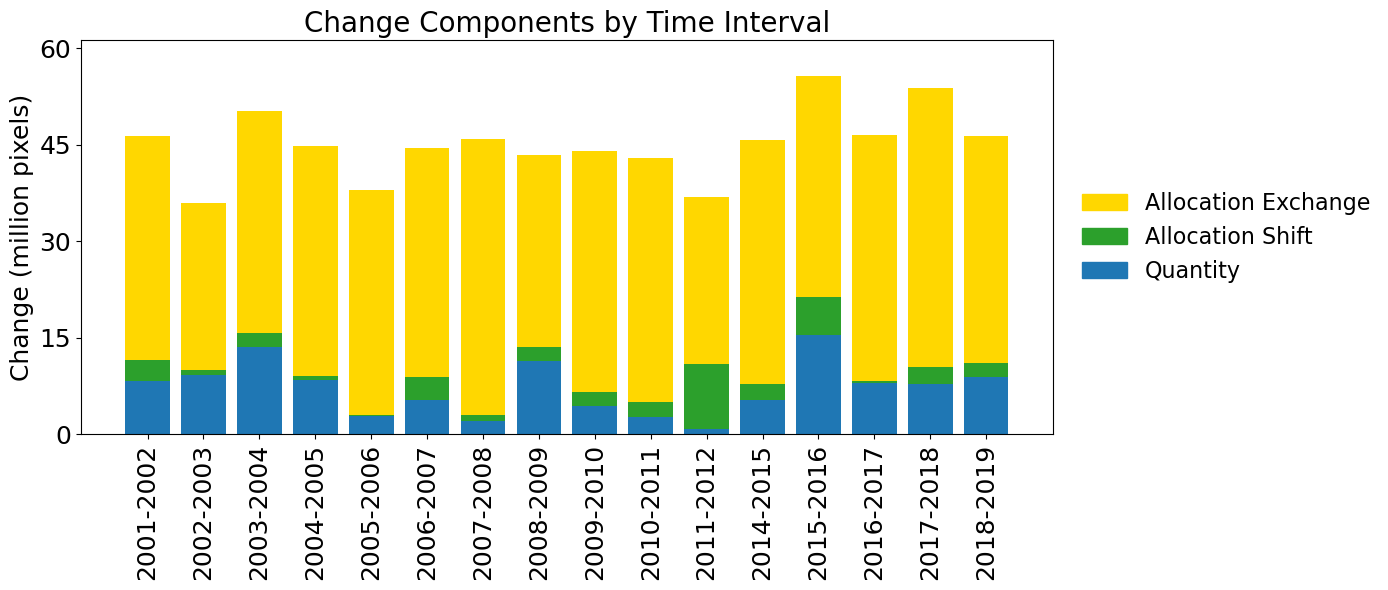

In [18]:
# Filter only time intervals
time_df = df[
    df["Time_Interval"].str.contains("-")
]

# Aggregate totals per interval and component (Gain)
totals = (
    time_df.groupby(
        ["Time_Interval", "Component"],
    )["Gain"]
    .sum()
    .unstack()
)

# Choose scale automatically based on max value
max_val = totals[["Quantity", "Shift", "Exchange"]].to_numpy().max()

if max_val >= 1_000_000_000_000:
    scale_factor = 1_000_000_000_000
    y_label = "Change (trillion pixels)"
elif max_val >= 1_000_000_000:
    scale_factor = 1_000_000_000
    y_label = "Change (billion pixels)"
elif max_val >= 1_000_000:
    scale_factor = 1_000_000
    y_label = "Change (million pixels)"
elif max_val >= 1_000:
    scale_factor = 1_000
    y_label = "Change (thousand pixels)"
elif max_val >= 100:
    scale_factor = 100
    y_label = "Change (hundred pixels)"
else:
    scale_factor = 1
    y_label = "Change (pixels)"

# Scaled totals per component for plotting
scaled_totals = totals[
    [
        "Quantity",
        "Shift",
        "Exchange",
    ]
] / scale_factor

# Maximum stacked height (Quantity + Exchange + Shift)
stacked_max = scaled_totals.sum(
    axis=1,
).max()

# Create figure and axis
fig, ax = plt.subplots(
    figsize=(
        14,
        6,
    ),
)

# Colors
colors = [
    "#1f77b4",  # Quantity
    "#2ca02c",  # Shift
    "#ffd700",  # Exchange

]
components_color = {
    "Quantity": "#1f77b4",
    "Shift": "#2ca02c",
    "Exchange": "#ffd700"

}

# Stacked bars using scaled values
for idx, comp in enumerate(
    [
        "Quantity",
        "Shift",
        "Exchange",
    ],
):
    bottom_values = (
        scaled_totals.iloc[:, :idx].sum(
            axis=1,
        )
        if idx > 0
        else 0
    )
    ax.bar(
        totals.index,
        scaled_totals[comp],
        label=comp,
        color=colors[idx],
        edgecolor="none",
        bottom=bottom_values,
    )

# Axes formatting
ax.set_ylabel(
    y_label,
    fontsize=18,
)
ax.set_title(
    "Change Components by Time Interval",
    fontsize=20,
)
ax.tick_params(
    axis="both",
    which="major",
    labelsize=18,
)

# Adaptive rotation for x-axis tick labels
labels = ax.get_xticklabels()
n_labels = len(labels)

if n_labels <= 6:
    rotation = 0
    ha = "center"
elif n_labels <= 12:
    rotation = 45
    ha = "right"
else:
    rotation = 90
    ha = "center"

plt.setp(
    labels,
    rotation=rotation,
    ha=ha,
)

# Y-axis limits and ticks based on stacked maximum
y_max_scaled = stacked_max * 1.1
ax.set_ylim(
    0,
    y_max_scaled,
)
ax.yaxis.set_major_locator(
    ticker.MaxNLocator(
        nbins=5,
    ),
)

# Legend (custom labels)
legend_elements = [
    plt.Rectangle(
        (0, 0),
        1,
        1,
        color=components_color["Exchange"],
        label="Allocation Exchange",
    ),
    plt.Rectangle(
        (0, 0),
        1,
        1,
        color=components_color["Shift"],
        label="Allocation Shift",
    ),
    plt.Rectangle(
        (0, 0),
        1,
        1,
        color=components_color["Quantity"],
        label="Quantity",
    ),
]
ax.legend(
    handles=legend_elements,
    loc="center left",
    bbox_to_anchor=(
        1.01,
        0.5,
    ),
    fontsize=16,
    frameon=False,
)

# Save and show
plt.tight_layout()
plt.savefig(
    os.path.join(
        output_path,
        "graphic_change_components_time_interval.png",
    ),
    bbox_inches="tight",
    format="png",
    dpi=300,
)
plt.show()


#### 6.2.2 Change Components Overall

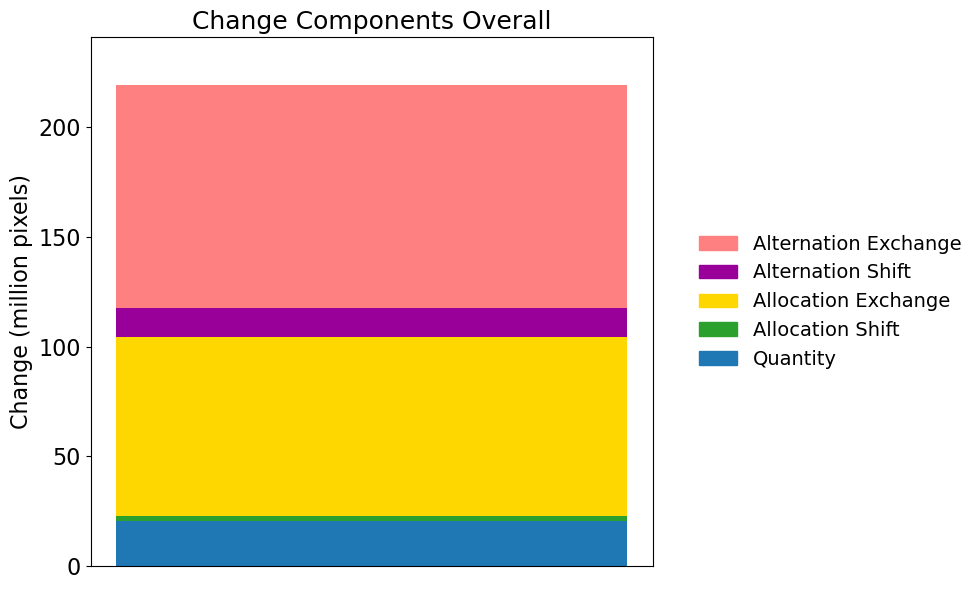

In [19]:
def plot_components_with_alternation(
    csv_path: str,
    output_path: str,
) -> None:
    """
    Plot overall change components as a single stacked bar with auto-scaled y-axis for Real Data.

    Parameters
    ----------
    csv_path : str
        Path to the CSV file containing change components.
    output_path : str
        Directory where the output figure will be saved.
    """
    # 1. Load data
    df = pd.read_csv(
        csv_path,
    )

    # 2. Define Colors and component order
    components_color = {
        "Quantity": "#1f77b4",
        "Allocation_Exchange": "#ffd700",
        "Alternation_Exchange": "#ff8080",
        "Allocation_Shift": "#2ca02c",
        "Alternation_Shift": "#990099",
    }

    component_order = [
        "Quantity",
        "Allocation_Shift",
        "Allocation_Exchange",
        "Alternation_Shift",
        "Alternation_Exchange",
    ]

    # 3. Aggregate totals per component
    component_totals = {
        "Quantity": df[
            (df["Component"] == "Allocation_Quantity")
            & (df["Time_Interval"] == "extent")
        ]["Gain"].sum(),
        "Allocation_Exchange": df[
            (df["Component"] == "Allocation_Exchange")
            & (df["Time_Interval"] == "extent")
        ]["Gain"].sum(),
        "Allocation_Shift": df[
            (df["Component"] == "Allocation_Shift")
            & (df["Time_Interval"] == "extent")
        ]["Gain"].sum(),
        "Alternation_Exchange": df[
            (df["Time_Interval"] == "alternation_exchange")
        ]["Gain"].sum(),
        "Alternation_Shift": df[
            (df["Time_Interval"] == "alternation_shift")
        ]["Gain"].sum(),
    }

    # 4. Automatic scale based on the sum of all stacked components
    total_change = sum(
        component_totals.values(),
    )

    if max_val >= 1_000_000_000_000:
        scale_factor = 1_000_000_000_000
        y_label = "Change (trillion pixels)"
    elif max_val >= 1_000_000_000:
        scale_factor = 1_000_000_000
        y_label = "Change (billion pixels)"
    elif max_val >= 1_000_000:
        scale_factor = 1_000_000
        y_label = "Change (million pixels)"
    elif max_val >= 1_000:
        scale_factor = 1_000
        y_label = "Change (thousand pixels)"
    elif max_val >= 100:
        scale_factor = 100
        y_label = "Change (hundred pixels)"
    else:
        scale_factor = 1
        y_label = "Change (pixels)"

    # 5. Initialize figure and axis
    fig, ax = plt.subplots(
        figsize=(
            10,
            6,
        ),
    )

    # 6. Plot each component in a stacked bar at a single x-position
    bottom = 0.0
    for component in component_order:
        value = (
            component_totals.get(
                component,
                0.0,
            )
            / scale_factor
        )
        ax.bar(
            x=0,
            height=value,
            bottom=bottom,
            color=components_color[component],
            edgecolor="none",
            width=0.8,
        )
        bottom += value

    # 7. Axes formatting and labels
    ax.set_ylabel(
        y_label,
        fontsize=16,
    )
    ax.set_title(
        "Change Components Overall",
        fontsize=18,
    )
    ax.xaxis.set_visible(
        False,
    )
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=16,
    )

    # 8. Set y-axis limits and major tick locators
    y_max_scaled = bottom * 1.1 if bottom > 0 else 1.0
    ax.set_ylim(
        0,
        y_max_scaled,
    )

    ax.yaxis.set_major_locator(
        mticker.MaxNLocator(
            nbins=5,
            integer=True,
        ),
    )

    ax.yaxis.set_major_formatter(
        mticker.FormatStrFormatter(
            "%d",
        ),
    )

    # 9. Configure visible spines for the plot frame
    for spine in [
        "top",
        "right",
        "left",
        "bottom",
    ]:
        ax.spines[spine].set_visible(
            True,
        )

    # 10. Define custom legend elements
    legend_elements = [
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Alternation_Exchange"],
            label="Alternation Exchange",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Alternation_Shift"],
            label="Alternation Shift",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Allocation_Exchange"],
            label="Allocation Exchange",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Allocation_Shift"],
            label="Allocation Shift",
        ),
        plt.Rectangle(
            (0, 0),
            1,
            1,
            color=components_color["Quantity"],
            label="Quantity",
        ),
    ]

    ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(
            1.05,
            0.5,
        ),
        fontsize=14,
        frameon=False,
    )

    # 11. Final layout adjustment and export
    plt.tight_layout()
    plt.savefig(
        os.path.join(
            output_path,
            "graphic_change_components_overall.png",
        ),
        bbox_inches="tight",
        format="png",
        dpi=300,
    )
    plt.show()


# 12. Specify paths and execute the plotting function
csv_components_path = os.path.join(
    output_path,
    "change_components.csv",
)

plot_components_with_alternation(
    csv_path=csv_components_path,
    output_path=output_path,
)

#### 6.2.3 Change Componentes by Class

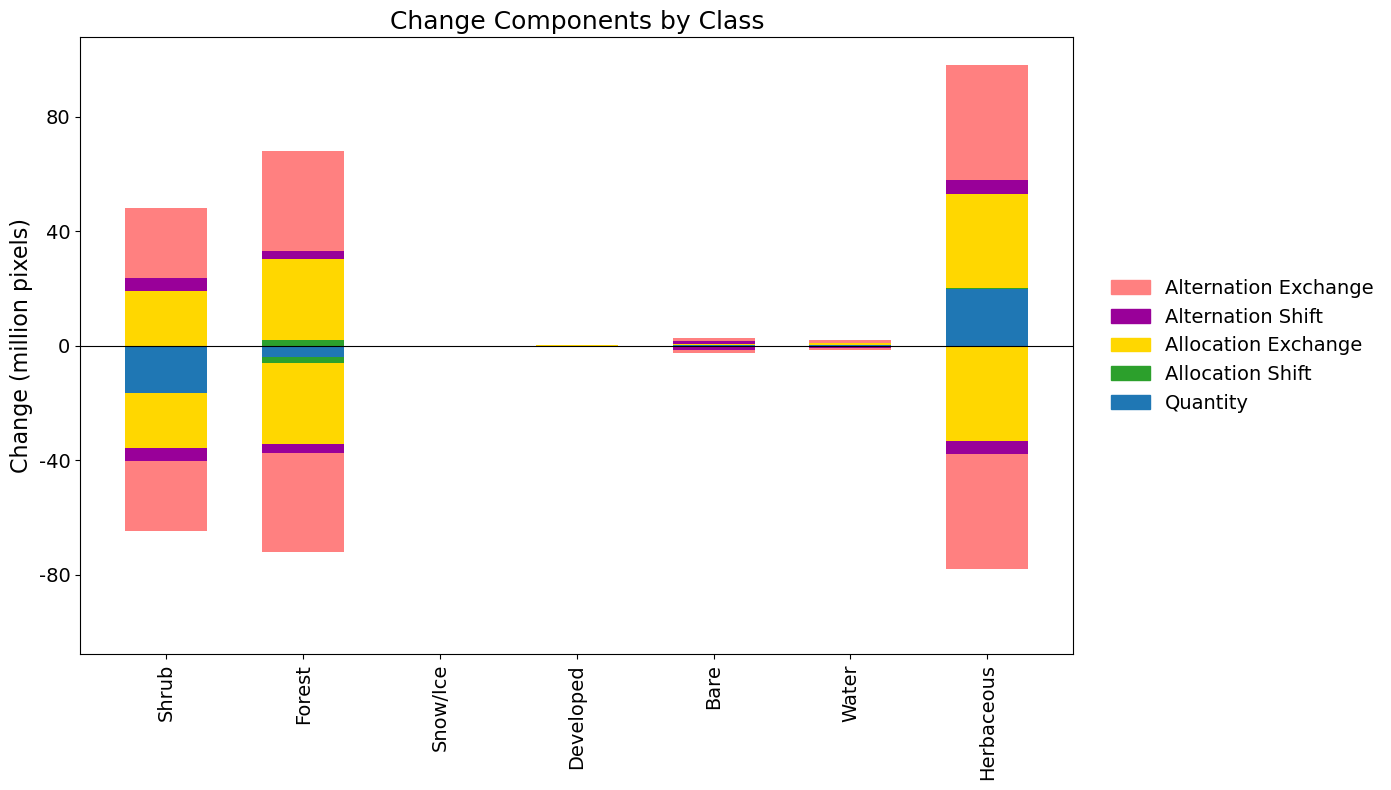

In [20]:
class ComponentVisualizer:
    """
    Visualize change components by class.

    Handles negative correction terms in alternation components correctly.
    """

    @staticmethod
    def plot_gain_loss_stacked(
        df: pd.DataFrame,
        class_labels_dict: dict,
        title: str,
        output_path: str,
    ) -> None:
        """
        Plot per-class gains and losses as stacked bars with auto-scaled y-axis.

        Parameters
        ----------
        df : pd.DataFrame
            DataFrame containing the change components per class.
        class_labels_dict : dict
            Dictionary mapping class IDs to names/metadata.
        title : str
            Title of the plot.
        output_path : str
            Directory to save the output figure.
        """
        # 1. Filter and Prepare Data
        target_intervals = [
            "extent",
            "alternation_shift",
            "alternation_exchange",
        ]

        # Select rows
        df_sub = df[
            df["Time_Interval"].isin(
                target_intervals,
            )
        ].copy()

        # Rename 'Allocation_Quantity' to 'Quantity' for consistency
        df_sub["Component"] = df_sub["Component"].str.replace(
            "Allocation_Quantity",
            "Quantity",
        )

        # 2. Colors and Order
        components_map = {
            "Quantity": "#1f77b4",
            "Allocation_Exchange": "#ffd700",
            "Alternation_Exchange": "#ff8080",
            "Allocation_Shift": "#2ca02c",
            "Alternation_Shift": "#990099",
        }

        # We process these groups separately to handle the math
        comp_groups = [
            "Quantity",
            "Allocation_Shift",
            "Allocation_Exchange",
        ]

        # 3. Identify Classes and Sort by Net Quantity Change
        classes = sorted(
            df_sub["Class"].unique(),
        )

        # Calculate Net Quantity for Sorting
        class_stats = []
        for cls in classes:
            c_data = df_sub[
                df_sub["Class"] == cls
            ]
            qty_gain = c_data[
                c_data["Component"] == "Quantity"
            ]["Gain"].sum()

            qty_loss = c_data[
                c_data["Component"] == "Quantity"
            ]["Loss"].sum()

            class_stats.append(
                (
                    cls,
                    qty_gain - qty_loss,
                ),
            )

        # Sort classes
        ordered_classes = [
            x[0]
            for x in sorted(
                class_stats,
                key=lambda x: x[1],
            )
        ]

        # 4. Prepare Plot Data (Handling the Net Logic)
        plot_data = []
        max_val = 0.0

        for cls in ordered_classes:
            c_data = df_sub[
                df_sub["Class"] == cls
            ]

            # --- GAINS ---
            # Standard Components
            gains = {}
            for comp in comp_groups:
                gains[comp] = c_data[
                    c_data["Component"] == comp
                ]["Gain"].sum()

            # Alternation Logic (Consolidate Exchange + Shift)
            raw_alt_exc = c_data[
                c_data["Component"] == "Alternation_Exchange"
            ]["Gain"].sum()

            raw_alt_shift = c_data[
                c_data["Component"] == "Alternation_Shift"
            ]["Gain"].sum()

            net_alt = raw_alt_exc + raw_alt_shift

            # If Net Alternation is effectively 0, plot neither.
            # If positive, attribute to Exchange first if valid, else Shift.
            adj_alt_exc = 0.0
            adj_alt_shift = 0.0

            if net_alt > 0.0001:
                # If raw exchange is positive, keep it
                if raw_alt_exc > 0:
                    adj_alt_exc = raw_alt_exc
                    adj_alt_shift = max(
                        0,
                        net_alt - raw_alt_exc,
                    )
                else:
                    # If raw exchange is negative, hide it inside Shift
                    adj_alt_exc = 0
                    adj_alt_shift = net_alt

            gains["Alternation_Exchange"] = adj_alt_exc
            gains["Alternation_Shift"] = adj_alt_shift

            # --- LOSSES (Logic is identical but using Loss column) ---
            losses = {}
            for comp in comp_groups:
                losses[comp] = c_data[
                    c_data["Component"] == comp
                ]["Loss"].sum()

            raw_alt_exc_l = c_data[
                c_data["Component"] == "Alternation_Exchange"
            ]["Loss"].sum()

            raw_alt_shift_l = c_data[
                c_data["Component"] == "Alternation_Shift"
            ]["Loss"].sum()

            net_alt_l = raw_alt_exc_l + raw_alt_shift_l

            adj_alt_exc_l = 0.0
            adj_alt_shift_l = 0.0

            if net_alt_l > 0.0001:
                if raw_alt_exc_l > 0:
                    adj_alt_exc_l = raw_alt_exc_l
                    adj_alt_shift_l = max(
                        0,
                        net_alt_l - raw_alt_exc_l,
                    )
                else:
                    adj_alt_exc_l = 0
                    adj_alt_shift_l = net_alt_l

            losses["Alternation_Exchange"] = adj_alt_exc_l
            losses["Alternation_Shift"] = adj_alt_shift_l

            # Track max height for scaling
            total_g = sum(
                gains.values(),
            )
            total_l = sum(
                losses.values(),
            )
            max_val = max(
                max_val,
                total_g,
                total_l,
            )

            plot_data.append(
                {
                    "class": cls,
                    "gains": gains,
                    "losses": losses,
                },
            )

        # 5. Determine Scale Factor
        if max_val >= 1_000_000_000_000:
            scale_factor = 1_000_000_000_000
            y_label = "Change (trillion pixels)"
        elif max_val >= 1_000_000_000:
            scale_factor = 1_000_000_000
            y_label = "Change (billion pixels)"
        elif max_val >= 1_000_000:
            scale_factor = 1_000_000
            y_label = "Change (million pixels)"
        elif max_val >= 1_000:
            scale_factor = 1_000
            y_label = "Change (thousand pixels)"
        elif max_val >= 100:
            scale_factor = 100
            y_label = "Change (hundred pixels)"
        else:
            scale_factor = 1
            y_label = "Change (pixels)"

        # 6. Plotting
        fig, ax = plt.subplots(
            figsize=(
                14,
                8,
            ),
        )
        fig.subplots_adjust(
            left=0.1,
            right=0.75,
        )

        x_pos = np.arange(
            len(ordered_classes),
        )
        width = 0.6

        # Order for stacking: Quantity at bottom, then Alloc, then Alt
        stack_order = [
            "Quantity",
            "Allocation_Shift",
            "Allocation_Exchange",
            "Alternation_Shift",
            "Alternation_Exchange",
        ]

        for idx, item in enumerate(
            plot_data,
        ):
            # Gains (Upwards)
            bottom_g = 0.0
            for comp in stack_order:
                val = item["gains"][comp] / scale_factor
                if val > 0:
                    ax.bar(
                        x_pos[idx],
                        val,
                        width,
                        bottom=bottom_g,
                        color=components_map[
                            comp
                        ],
                        edgecolor="none",
                    )
                    bottom_g += val

            # Losses (Downwards)
            bottom_l = 0.0
            for comp in stack_order:
                val = item["losses"][comp] / scale_factor
                if val > 0:
                    ax.bar(
                        x_pos[idx],
                        -val,
                        width,
                        bottom=bottom_l,
                        color=components_map[
                            comp
                        ],
                        edgecolor="none",
                    )
                    bottom_l -= val

        # 7. Formatting
        class_names = [
            class_labels_dict.get(
                int(c) if str(c).isdigit() else c,
                {},
            ).get(
                "name",
                str(c),
            )
            for c in ordered_classes
        ]

        ax.set_xticks(
            x_pos,
        )
        ax.set_xticklabels(
            class_names,
            rotation=90,
            ha="center",
            fontsize=14,
        )
        ax.axhline(
            0,
            color="black",
            linewidth=0.8,
        )

        ax.set_ylabel(
            y_label,
            fontsize=16,
        )
        ax.set_title(
            title,
            fontsize=18,
        )
        ax.tick_params(
            axis="both",
            labelsize=14,
        )

        # Y-Axis Limits and Integer Ticks
        limit = max_val / scale_factor * 1.1 if max_val > 0 else 1.0
        ax.set_ylim(
            -limit,
            limit,
        )
        ax.yaxis.set_major_locator(
            ticker.MaxNLocator(
                integer=True,
                nbins=6,
            ),
        )
        ax.yaxis.set_major_formatter(
            ticker.FormatStrFormatter(
                "%d",
            ),
        )

        # Legend
        handles = [
            plt.Rectangle(
                (0, 0),
                1,
                1,
                color=components_map[
                    c
                ],
                label=c.replace(
                    "_",
                    " ",
                ),
            )
            for c in reversed(
                stack_order,
            )  # Top to bottom order in legend
        ]

        ax.legend(
            handles=handles,
            loc="center left",
            bbox_to_anchor=(
                1.02,
                0.5,
            ),
            fontsize=14,
            frameon=False,
        )

        plt.tight_layout()
        plt.savefig(
            os.path.join(
                output_path,
                "graphic_change_component_change_class.png",
            ),
            bbox_inches="tight",
            format="png",
            dpi=300
        )
        plt.show()


# Execution
ComponentVisualizer.plot_gain_loss_stacked(
    df=df,
    class_labels_dict=class_labels_dict,
    title="Change Components by Class",
    output_path=output_path,
)

## **7. Number of Changes**

### 7.1 Compute Number of Changes

In [21]:
import os
import numpy as np
import rasterio
from rasterio.windows import Window
from tqdm import tqdm

def number_of_changes_raster_optimized(
    file_list: list,
    output_dir: str,
    nodata_val: int,
    block_size: int = 1024,
) -> None:
    """
    Compute and save a raster representing the total number of class changes
    per pixel, using optimized block processing (files kept open).

    Parameters
    ----------
    file_list : list of str
        List of paths to the input raster images (sorted temporally).
    output_dir : str
        Directory to save the output raster.
    nodata_val : int
        Value representing NoData pixels to be ignored in comparisons.
    block_size : int, optional
        Size of the square blocks to process at once (default is 1024).
    """
    image_paths = sorted(
        file_list,
    )

    out_raster_path = os.path.join(
        output_dir,
        "number_of_changes.tif",
    )

    print(
        f"Computing number of changes across {len(image_paths)} raster maps...",
    )

    # 1. Open all datasets ONCE to avoid I/O overhead during the loop
    # This is much faster than opening/closing inside the block loop
    srcs = [
        rasterio.open(
            path,
        ) for path in image_paths
    ]

    # 2. Extract metadata from the first source
    height = srcs[0].height
    width = srcs[0].width
    meta = srcs[0].profile.copy()

    # 3. Update profile for the output raster (optimized for chunks)
    meta.update(
        {
            "driver": "GTiff",
            "count": 1,
            "nodata": nodata_val,
            "compress": "lzw",
            "tiled": True,
            "blockxsize": 256,
            "blockysize": 256,
        }
    )

    # 4. Open output file and iterate by spatial blocks
    with rasterio.open(
        out_raster_path,
        "w",
        **meta,
    ) as dst:

        rows = range(
            0,
            height,
            block_size,
        )
        cols = range(
            0,
            width,
            block_size,
        )
        total_blocks = len(rows) * len(cols)

        with tqdm(
            total=total_blocks,
            desc="Processing blocks",
            unit="block",
        ) as pbar:

            for r_off in rows:
                for c_off in cols:
                    window = Window(
                        c_off,
                        r_off,
                        min(
                            block_size,
                            width - c_off,
                        ),
                        min(
                            block_size,
                            height - r_off,
                        ),
                    )

                    # 5. Read the block from the first year
                    data_prev = srcs[0].read(
                        1,
                        window=window,
                    )

                    cumulative_nodata_mask = (data_prev == nodata_val)

                    total_changes = np.zeros(
                        data_prev.shape,
                        dtype=data_prev.dtype,
                    )

                    # 6. Iterate through the already opened datasets
                    for i in range(
                        1,
                        len(srcs),
                    ):
                        data_curr = srcs[i].read(
                            1,
                            window=window,
                        )

                        cumulative_nodata_mask |= (data_curr == nodata_val)

                        change_mask = (
                            (data_prev != data_curr)
                            & (data_prev != nodata_val)
                            & (data_curr != nodata_val)
                        )

                        total_changes += change_mask.astype(
                            data_prev.dtype,
                        )

                        data_prev = data_curr

                    total_changes[cumulative_nodata_mask] = nodata_val

                    # 7. Write the computed block to disk
                    dst.write(
                        total_changes,
                        1,
                        window=window,
                    )

                    pbar.update(1)

    # 8. Close all datasets to free up file descriptors
    for src in srcs:
        src.close()

    print(
        f"Number of changes raster saved to: {out_raster_path}",
    )

# --- Execution ---

number_of_changes_raster_optimized(
    file_list=image_paths,
    output_dir=output_path,
    nodata_val=noData_value,
)

Computing number of changes across 18 raster maps...


Processing blocks: 100%|██████████████████████████████████████████████████████████████████████| 5852/5852 [4:41:47<00:00,  2.89s/block]


Number of changes raster saved to: /Users/antoniofonseca/Downloads/number_of_changes.tif


### 7.2 Plot Number of Changes Map

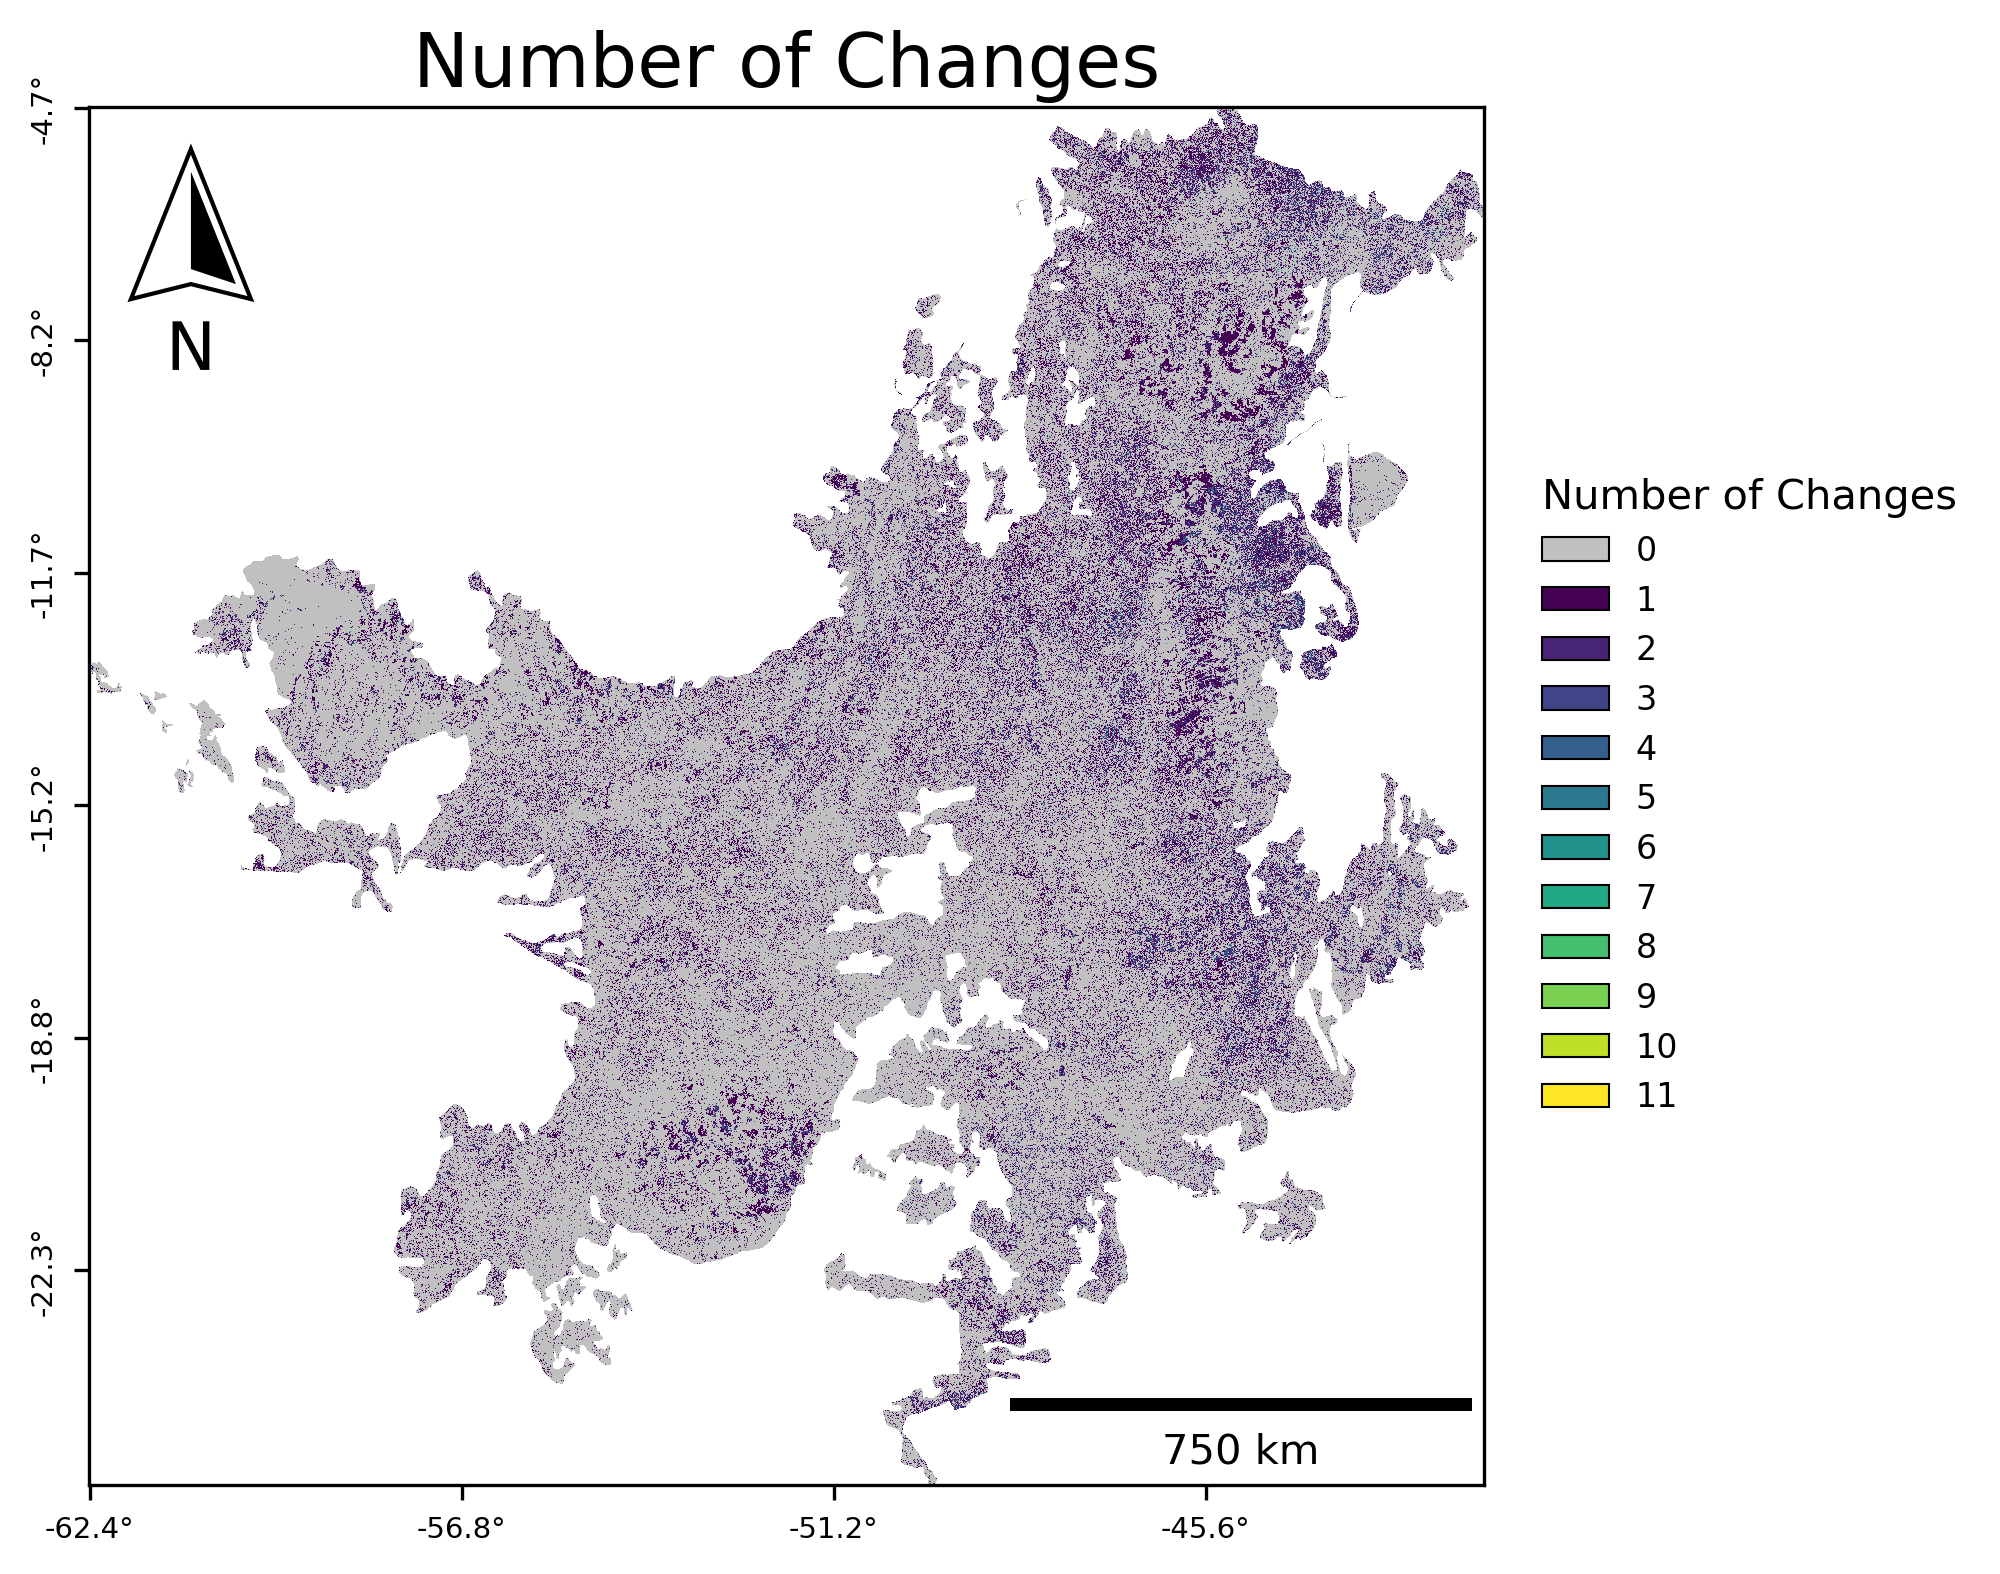

Map figure saved successfully to: /Users/antoniofonseca/Downloads/map_number_of_changes.png


In [22]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import rasterio
from rasterio.enums import Resampling
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from pyproj import Transformer

def plot_number_of_changes_map(
    output_dir: str,
    nodata_val: int,
    raster_filename: str = "number_of_changes.tif",
    max_display_size: int = 1500, # Added dynamic downsampling parameter
) -> None:
    """
    Plot the Number of Changes raster map with cartographic elements.

    Parameters
    ----------
    output_dir : str
        Directory containing the raster file and where the map will be saved.
    nodata_val : int
        Value representing NoData in the raster to be masked out.
    raster_filename : str, optional
        Name of the raster file to plot (default is "number_of_changes.tif").
    max_display_size : int, optional
        Maximum width/height in pixels for the generated plot to prevent
        RAM overflow. Default is 1500.

    Returns
    -------
    None
        This function does not return a value; it saves a PNG file to disk
        and displays the plot.

    Raises
    ------
    FileNotFoundError
        If the specified raster file does not exist in the output directory.
    """

    # 1) Input raster path
    raster_to_plot_path = os.path.join(
        output_dir,
        raster_filename,
    )

    if not os.path.exists(raster_to_plot_path):
        raise FileNotFoundError(
            f"Raster not found: {raster_to_plot_path}",
        )

    # Calculate dynamic scale factor based on max display size
    with rasterio.open(raster_to_plot_path) as src:
        max_dim = max(src.width, src.height)
        scale_factor = max(1.0, max_dim / max_display_size)

        left, bottom, right, top = src.bounds
        src_crs = src.crs
        transform = src.transform

    # Get the exact pixel size in km for the scalebar
    pixel_size_km = compute_display_pixel_size_km(
        raster_path=raster_to_plot_path,
        downsample_divisor=scale_factor,
    )

    # 2) Read raster and basic metadata
    with rasterio.open(
        raster_to_plot_path,
    ) as src:

        # Calculate new shape safely
        new_height = max(1, int(src.height / scale_factor))
        new_width = max(1, int(src.width / scale_factor))

        data = src.read(
            1,
            out_shape=(
                new_height,
                new_width,
            ),
            resampling=Resampling.nearest,
        )

        # Force masking using the provided variable
        data = np.ma.masked_equal(
            data,
            nodata_val,
        )

    # 3) Figure
    fig, ax = plt.subplots(
        figsize=(
            6,
            8,
        ),
        dpi=300,
    )

    # Data range
    min_val = int(
        np.ma.min(
            data,
        ),
    )
    max_val = int(
        np.ma.max(
            data,
        ),
    )

    # 4) Colormap (gray for 0 + jet for 1..max)
    original_cmap = plt.get_cmap(
        "viridis",
    )
    color_list = [
        "#c0c0c0",
    ] + [
        original_cmap(i)
        for i in np.linspace(
            0,
            1,
            max_val,
        )
    ]
    cmap = ListedColormap(
        color_list,
    )

    # Discrete normalization
    bounds = np.arange(
        min_val,
        max_val + 2,
    ) - 0.5
    norm = BoundaryNorm(
        bounds,
        cmap.N,
    )

    # 5) Plot raster in downsampled pixel coordinates
    ax.imshow(
        data,
        cmap=cmap,
        interpolation="nearest",
        norm=norm,
    )

    # 6) Discrete box legend
    legend_elements = []
    for i in range(
        min_val,
        max_val + 1,
    ):
        legend_elements.append(
            Patch(
                facecolor=cmap(
                    norm(i),
                ),
                edgecolor="black",
                linewidth=0.5,
                label=str(i),
            ),
        )

    ax.legend(
        handles=legend_elements,
        title="Number of Changes",
        loc="center left",
        bbox_to_anchor=(
            1.02,
            0.5,
        ),
        frameon=False,
        fontsize=8,
        title_fontsize=10,
        alignment="left",
    )

    # 7) Cartographic elements
    scalebar = ScaleBar(
        dx=pixel_size_km,
        units="km",
        length_fraction=0.35,
        location="lower right",
        box_alpha=0.0,
        scale_formatter=lambda value, _: f"{int(value)} km",
    )
    ax.add_artist(
        scalebar,
    )

    try:
        north_arrow(
            ax,
            location="upper left",
            shadow=False,
            rotation={
                "degrees": 0,
            },
        )
    except NameError:
        print("Note: north_arrow function not found, skipping.")

    # 8) Axes styling (with Lat/Lon labels)
    ax.set_title(
        "Number of Changes",
        fontsize=18,
        pad=5,
    )
    ax.set_aspect(
        "equal",
    )

    # Initialize Transformer (Native CRS -> Lat/Lon)
    to_latlon = Transformer.from_crs(
        src_crs,
        "EPSG:4326",
        always_xy=True,
    )

    # Get dimensions from the loaded DOWNSAMPLED data
    height, width = data.shape

    def format_lon(
        x,
        pos,
    ):
        """
        Convert a pixel column index to a formatted Longitude string.
        """
        x = np.clip(
            x,
            0,
            width - 1,
        )
        # Multiply by scale_factor to get the original unscaled pixel position
        original_x = x * scale_factor
        original_y = (height // 2) * scale_factor

        x_proj, y_proj = rasterio.transform.xy(
            transform,
            original_y,
            original_x,
        )
        lon, lat = to_latlon.transform(
            x_proj,
            y_proj,
        )
        return f"{lon:.1f}°"

    def format_lat(
        y,
        pos,
    ):
        """
        Convert a pixel row index to a formatted Latitude string.
        """
        y = np.clip(
            y,
            0,
            height - 1,
        )
        # Multiply by scale_factor to get the original unscaled pixel position
        original_y = y * scale_factor
        original_x = (width // 2) * scale_factor

        x_proj, y_proj = rasterio.transform.xy(
            transform,
            original_y,
            original_x,
        )
        lon, lat = to_latlon.transform(
            x_proj,
            y_proj,
        )
        return f"{lat:.1f}°"

    # Apply the custom formatters
    ax.xaxis.set_major_formatter(
        FuncFormatter(
            format_lon,
        ),
    )
    ax.yaxis.set_major_formatter(
        FuncFormatter(
            format_lat,
        ),
    )

    # Limit ticks to avoid overcrowding
    ax.xaxis.set_major_locator(
        mticker.MaxNLocator(
            nbins=4,
        ),
    )
    ax.yaxis.set_major_locator(
        mticker.MaxNLocator(
            nbins=6,
        ),
    )

    # Final styling for ticks
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=7,
        pad=4,
    )
    plt.setp(
        ax.get_yticklabels(),
        rotation=90,
        va="center",
    )

    # 9) Save
    output_figure_path = os.path.join(
        output_dir,
        "map_number_of_changes.png",
    )
    plt.savefig(
        output_figure_path,
        dpi=300,
        bbox_inches="tight",
        format="png",
        pad_inches=0.5,
    )
    plt.show()

    print(
        f"Map figure saved successfully to: {output_figure_path}",
    )


# Execute the function
plot_number_of_changes_map(
    output_dir=output_path,
    nodata_val=noData_value
)

## **8. Trajectory Classification**


---
This section provides a framework for processing and classifying pixel trajectories in raster datasets.


### 8.1 Compute Trajectory Analysis
This section processes and visualizes raster data by scaling, applying a color map, and adding graphical elements like legends, scale bars, and north arrows. The output is a high-resolution image of the classified raster data.

In [23]:
import os
import numpy as np
import rasterio
from rasterio.windows import Window
from tqdm import tqdm
import numba as nb
from numba import prange

# --- Numba Optimized Functions ---

@nb.njit(
    nogil=True,
)
def classify_pixel(
    pixel_series: np.ndarray,
    nodata_val: int,
):
    """
    Classify a single pixel trajectory into four categories based on temporal changes.

    Parameters
    ----------
    pixel_series : np.ndarray
        A 1D numpy array representing the land cover class values
        of a single pixel over time.
    nodata_val : int
        Value representing NoData pixels.

    Returns
    -------
    int
        An integer representing the trajectory class:
        nodata_val: NoData (Background)
        1: Stable (No change)
        2: Alternation (Change occurs, but Start Class == End Class)
        3: Step (Start != End, and a direct transition exists)
        4: Complex (Start != End, and no direct transition exists)
    """
    if pixel_series[0] == nodata_val:
        return nodata_val

    start = pixel_series[
        0
    ]
    end = pixel_series[
        -1
    ]

    has_variation = False
    direct_transition = False

    for i in range(
        len(
            pixel_series,
        )
        - 1,
    ):
        current = pixel_series[
            i
        ]
        next_val = pixel_series[
            i + 1
        ]

        if current == nodata_val or next_val == nodata_val:
            return nodata_val

        if current != next_val:
            has_variation = True
            if (current == start) and (next_val == end):
                direct_transition = True

    if not has_variation:
        return 1

    if start == end:
        return 2

    if direct_transition:
        return 3

    return 4


@nb.njit(
    nogil=True,
    parallel=True,
)
def process_stack_block_parallel(
    stack: np.ndarray,
    nodata_val: int,
):
    """
    Apply pixel classification to a 3D raster block using parallel processing.

    Parameters
    ----------
    stack : np.ndarray
        A 3D numpy array of shape (height, width, time) containing
        the stacked raster data.
    nodata_val : int
        Value representing NoData pixels.

    Returns
    -------
    np.ndarray
        A 2D numpy array of shape (height, width) containing the
        classified trajectory codes, inheriting the input's data type.
    """
    height = stack.shape[0]
    width = stack.shape[1]

    # Initialize output array with the exact input dtype to preserve custom nodata
    result = np.full(
        (
            height,
            width,
        ),
        nodata_val,
        dtype=stack.dtype,
    )

    for y in prange(
        height,
    ):
        for x in range(
            width,
        ):
            # The pixel series is extracted across the time axis (last dimension)
            result[
                y,
                x,
            ] = classify_pixel(
                stack[
                    y,
                    x,
                    :,
                ],
                nodata_val,
            )

    return result

# --- Main Processing Function ---

def generate_trajectory_raster_optimized(
    file_list: list,
    output_dir: str,
    nodata_val: int,
    block_size: int = 1024,
) -> str:
    """
    Load time-series rasters from directory, classify trajectories, and save the result
    using memory-efficient chunking and parallel Numba processing.

    Parameters
    ----------
    file_list : list of str
        The list containing paths to input rasters.
    output_dir : str
        The directory path where the output file will be saved.
    nodata_val : int
        Value representing NoData pixels.
    block_size : int, optional
        Size of the square blocks to process at once (default is 1024).

    Returns
    -------
    str
        The full file path to the generated trajectory raster.

    Raises
    ------
    ValueError
        If no images are found in the file list.
    """
    if not file_list:
        raise ValueError(
            "The provided file list is empty.",
        )

    image_paths = sorted(
        file_list,
    )

    out_file = os.path.join(
        output_dir,
        "trajectory.tif",
    )

    print(
        f"Classifying trajectories across {len(image_paths)} raster maps...",
    )

    # 1. Open all datasets ONCE to avoid I/O overhead during the loop
    srcs = [
        rasterio.open(
            path,
        ) for path in image_paths
    ]

    # 2. Extract metadata from the first source
    height = srcs[0].height
    width = srcs[0].width
    meta = srcs[0].profile.copy()

    # 3. Update profile for the output raster
    # Notice we keep the original dtype so nodata_val fits perfectly
    meta.update(
        {
            "driver": "GTiff",
            "count": 1,
            "nodata": nodata_val,
            "compress": "lzw",
            "tiled": True,
            "blockxsize": 256,
            "blockysize": 256,
        }
    )

    # 4. Open output file and iterate by spatial blocks
    with rasterio.open(
        out_file,
        "w",
        **meta,
    ) as dst:

        rows = range(
            0,
            height,
            block_size,
        )
        cols = range(
            0,
            width,
            block_size,
        )
        total_blocks = len(rows) * len(cols)

        with tqdm(
            total=total_blocks,
            desc="Processing trajectory blocks",
            unit="block",
        ) as pbar:

            for r_off in rows:
                for c_off in cols:
                    window = Window(
                        c_off,
                        r_off,
                        min(
                            block_size,
                            width - c_off,
                        ),
                        min(
                            block_size,
                            height - r_off,
                        ),
                    )

                    # 5. Load stack for this block from all opened datasets
                    stack_list = []
                    for src in srcs:
                        data = src.read(
                            1,
                            window=window,
                        )
                        stack_list.append(
                            data,
                        )

                    # 6. Convert to 3D array and restructure for speed
                    # New shape: (Height, Width, Time) -> best for pixel-level loops
                    stack_data = np.array(
                        stack_list,
                    )
                    stack_data = np.moveaxis(
                        stack_data,
                        0,
                        -1,
                    )

                    # 7. Apply Numba-accelerated classification on the block
                    trajectory_block = process_stack_block_parallel(
                        stack_data,
                        nodata_val,
                    )

                    # 8. Write the processed block to disk
                    dst.write(
                        trajectory_block,
                        1,
                        window=window,
                    )

                    pbar.update(1)

    # 9. Close all open datasets
    for src in srcs:
        src.close()

    print(
        f"Trajectory map saved successfully to: {out_file}",
    )

    return out_file

# --- Execution ---

trajectory_file = generate_trajectory_raster_optimized(
    file_list=image_paths,
    output_dir=output_path,
    nodata_val=noData_value,
)

Classifying trajectories across 18 raster maps...


Processing trajectory blocks: 100%|███████████████████████████████████████████████████████████| 5852/5852 [4:27:32<00:00,  2.74s/block]

Trajectory map saved successfully to: /Users/antoniofonseca/Downloads/trajectory.tif


### 8.2 Plot Trajectory Analysis Graphic

Unique values in raster: [1 2 3 4]
Computed Percentages: 2: 6%, 3: 16%, 4: 1%


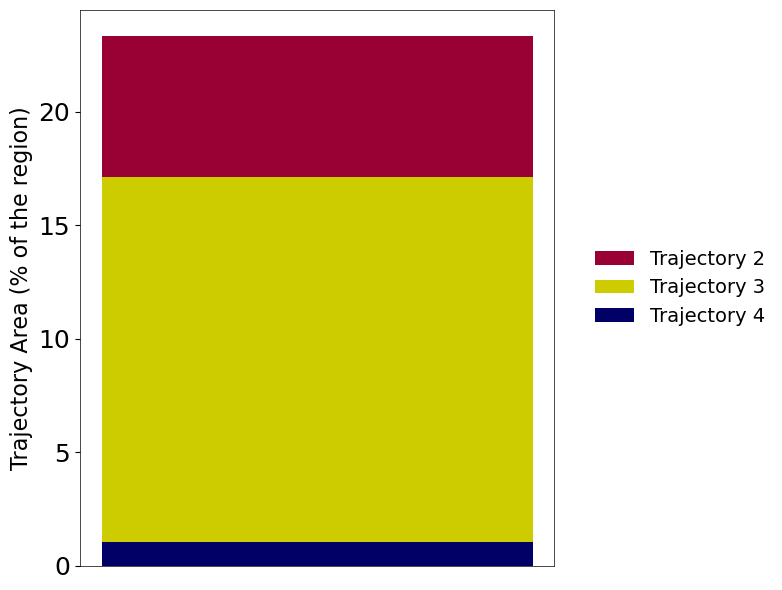

In [24]:
def plot_trajectory_distribution(
    output_path: str,
) -> None:
    """
    Generate and save a stacked bar chart of trajectory class distributions.

    This function reads a 'trajectory.tif' raster from the specified directory,
    calculates the percentage of the area covered by trajectory classes 2, 3,
    and 4, and plots these as a stacked bar chart. The resulting figure is
    saved as a JPEG file.

    Parameters
    ----------
    output_path : str
        Directory path containing the input 'trajectory.tif' raster.
        The output image 'graphic_trajectory_distribution.jpeg' will also
        be saved here.

    Returns
    -------
    None
        The function saves the plot to disk and displays it.

    Raises
    ------
    FileNotFoundError
        If 'trajectory.tif' is not found in the provided ``output_path``.
    """

    raster_path = os.path.join(
        output_path,
        "trajectory.tif",
    )

    with rasterio.open(
        raster_path,
    ) as src:
        traj_data = src.read(
            1,
        )
        nodata = src.nodata

    masked_traj = np.ma.masked_where(
        traj_data == nodata,
        traj_data,
    )

    unique_vals, counts = np.unique(
        masked_traj.compressed(),
        return_counts=True,
    )

    data_counts = dict(
        zip(
            unique_vals,
            counts,
        ),
    )

    total_pixels = sum(
        data_counts.values(),
    )

    print(
        f"Unique values in raster: {unique_vals}",
    )

    # Convert to native python float to avoid 'np.float64' in print
    percentages = {
        i: float(
            (
                data_counts.get(
                    i,
                    0,
                )
                / total_pixels
            )
            * 100.0
        )
        for i in [
            2,
            3,
            4,
        ]
    }

    formatted_msg = ", ".join(f"{k}: {v:.0f}%" for k, v in percentages.items())

    print(
        f"Computed Percentages: {formatted_msg}",
    )

    ordered_trajs = [
        4,
        3,
        2,
    ]
    colors = {
        4: "#000066",  # Dark Blue
        3: "#cccc00",  # Yellow
        2: "#990033",  # Dark Red
    }

    fig, ax = plt.subplots(
        figsize=(
            8,
            6,
        ),
    )

    bottom = 0.0
    for traj in ordered_trajs:
        val = percentages[
            traj
        ]
        ax.bar(
            0,
            val,
            bottom=bottom,
            color=colors[
                traj
            ],
            width=0.4,
            edgecolor="none",
        )
        bottom += val

    ax.set_ylabel(
        "Trajectory Area (% of the region)",
        fontsize=16,
    )

    for spine in [
        "top",
        "right",
        "bottom",
        "left",
    ]:
        ax.spines[
            spine
        ].set_visible(
            True,
        )
        ax.spines[
            spine
        ].set_color(
            "black",
        )
        ax.spines[
            spine
        ].set_linewidth(
            0.5,
        )

    ax.tick_params(
        axis="y",
        which="major",
        labelsize=18,
    )

    # Remove x-axis ticks to leave it blank
    ax.set_xticks(
        [],
    )

    ax.set_ylim(
        0,
        bottom * 1.05,
    )

    # Use mticker for consistency
    ax.yaxis.set_major_locator(
        mticker.MaxNLocator(
            nbins=5,
        ),
    )
    ax.yaxis.set_major_formatter(
        mticker.FormatStrFormatter(
            "%d",
        ),
    )

    # Legend with Original Names
    legend_elements = [
        Patch(
            facecolor=colors[
                2
            ],
            label="Trajectory 2",
        ),
        Patch(
            facecolor=colors[
                3
            ],
            label="Trajectory 3",
        ),
        Patch(
            facecolor=colors[
                4
            ],
            label="Trajectory 4",
        ),
    ]

    ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(
            1.05,
            0.5,
        ),
        fontsize=14,
        frameon=False,
    )

    plt.tight_layout()

    # Save the figure
    out_fig_path = os.path.join(
        output_path,
        "graphic_trajectory_distribution.jpeg",
    )
    plt.savefig(
        out_fig_path,
        dpi=300,
        bbox_inches="tight",
        format="jpeg",
    )
    plt.show()


# Execution
plot_trajectory_distribution(
    output_path=output_path,
)

### 8.3 Plot Trajectory Analysis Map

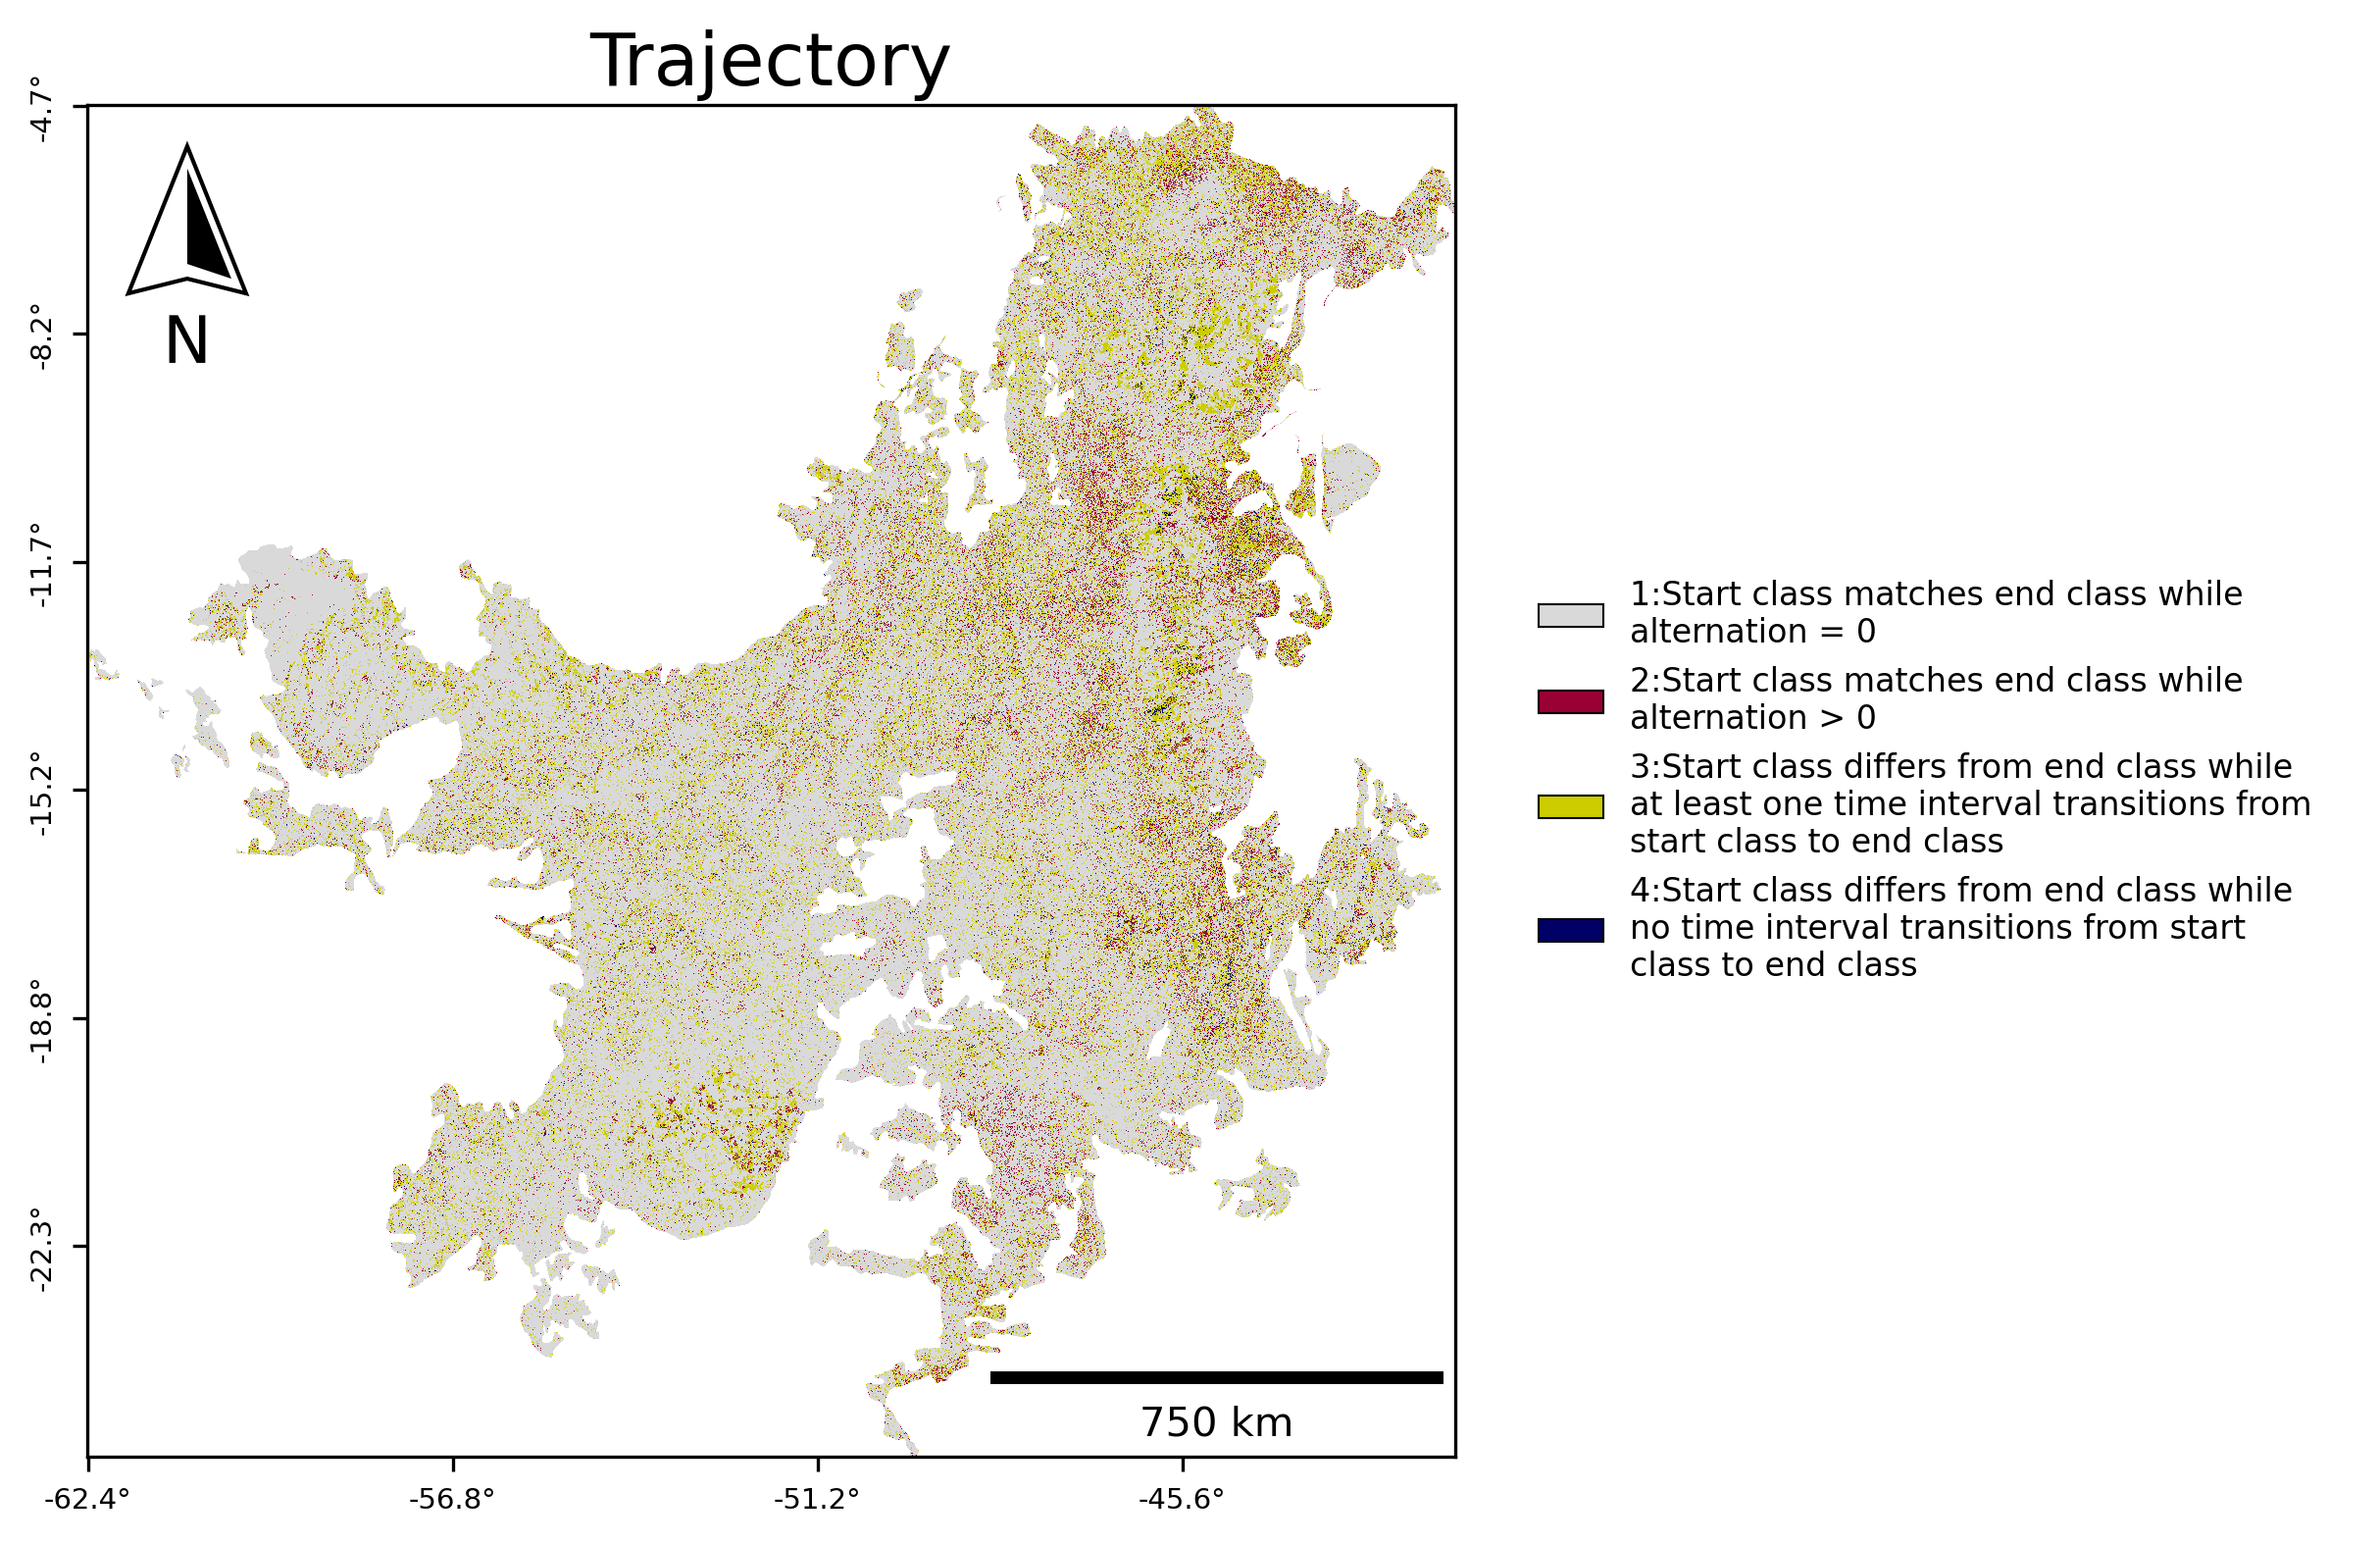

Trajectory map saved successfully to: /Users/antoniofonseca/Downloads/map_trajectories.png


In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import rasterio
from rasterio.enums import Resampling
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from pyproj import Transformer

def plot_trajectory_map(
    output_dir: str,
    raster_filename: str = "trajectory.tif",
    max_display_size: int = 1500, # Adicionado o parâmetro de segurança de RAM
) -> None:
    """
    Plot the Trajectory raster map with specific categorical coloring and full descriptions.

    Parameters
    ----------
    output_dir : str
        Directory containing the raster file and where the map will be saved.
    raster_filename : str, optional
        Name of the raster file to plot (default is "trajectory.tif").
    max_display_size : int, optional
        Maximum width/height in pixels for the generated plot to prevent
        RAM overflow. Default is 1500.

    Returns
    -------
    None
        This function does not return a value; it saves a PNG file to disk
        and displays the plot.

    Raises
    ------
    FileNotFoundError
        If the specified raster file does not exist in the output directory.
    """

    # 1) Input raster path
    raster_path = os.path.join(
        output_dir,
        raster_filename,
    )

    if not os.path.exists(raster_path):
        raise FileNotFoundError(
            f"Raster not found: {raster_path}",
        )

    # 2) Calculate dynamic scale factor
    with rasterio.open(raster_path) as src:
        max_dim = max(src.width, src.height)
        scale_factor = max(1.0, max_dim / max_display_size)

        left, bottom, right, top = src.bounds
        src_crs = src.crs
        transform = src.transform

    # Get the exact pixel size in km for the scalebar using the scale_factor
    pixel_size_km = compute_display_pixel_size_km(
        raster_path=raster_path,
        downsample_divisor=scale_factor,
    )

    # 3) Read raster and apply downsampling
    with rasterio.open(
        raster_path,
    ) as src:

        new_height = max(1, int(src.height / scale_factor))
        new_width = max(1, int(src.width / scale_factor))

        data = src.read(
            1,
            out_shape=(
                new_height,
                new_width,
            ),
            resampling=Resampling.nearest,
        )

        nodata_val = src.nodata
        if nodata_val is not None:
             data = np.ma.masked_equal(data, nodata_val)

    # 4) Figure
    fig, ax = plt.subplots(
        figsize=(
            6,
            8,
        ),
        dpi=300,
    )

    # 5) Colormap (categorical: 1–4)
    cmap = ListedColormap(
        [
            "#d9d9d9",  # 1
            "#990033",  # 2
            "#cccc00",  # 3
            "#000066",  # 4
        ],
    )
    bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
    norm = BoundaryNorm(bounds, cmap.N)

    # 6) Plot raster in downsampled pixel coordinates (No 'extent' used here)
    ax.imshow(
        data,
        cmap=cmap,
        norm=norm,
        interpolation="nearest"
    )

    # 7) Legend
    legend_elements = [
        Patch(
            facecolor="#d9d9d9",
            label=(
                "1:Start class matches end class while\n"
                "alternation = 0"
            ),
            edgecolor="black",
            linewidth=0.5,
        ),
        Patch(
            facecolor="#990033",
            label=(
                "2:Start class matches end class while\n"
                "alternation > 0"
            ),
            edgecolor="black",
            linewidth=0.5,
        ),
        Patch(
            facecolor="#cccc00",
            label=(
                "3:Start class differs from end class while\n"
                "at least one time interval transitions from\n"
                "start class to end class"
            ),
            edgecolor="black",
            linewidth=0.5,
        ),
        Patch(
            facecolor="#000066",
            label=(
                "4:Start class differs from end class while\n"
                "no time interval transitions from start\n"
                "class to end class"
            ),
            edgecolor="black",
            linewidth=0.5,
        ),
    ]

    ax.legend(
        handles=legend_elements,
        loc="center left",
        bbox_to_anchor=(
            1.02,
            0.5,
        ),
        frameon=False,
        fontsize=8,
        borderpad=1.2,
        handletextpad=0.8,
        columnspacing=2,
    )

    # 8) Cartographic elements
    scalebar = ScaleBar(
        dx=pixel_size_km,
        units="km",
        length_fraction=0.35,
        location="lower right",
        box_alpha=0.0,
        scale_formatter=lambda value, _: f"{int(value)} km",
    )
    ax.add_artist(
        scalebar,
    )

    try:
        north_arrow(
            ax,
            location="upper left",
            shadow=False,
            rotation={
                "degrees": 0,
            },
        )
    except NameError:
        print("Note: north_arrow function not found, skipping north arrow.")

    # 9) Axes styling (with Lat/Lon labels)
    ax.set_title(
        "Trajectory",
        fontsize=18,
        pad=5,
    )
    ax.set_aspect(
        "equal",
    )

    # Initialize Transformer (Native CRS -> Lat/Lon)
    to_latlon = Transformer.from_crs(
        src_crs,
        "EPSG:4326",
        always_xy=True,
    )

    # Get dimensions from the loaded DOWNSAMPLED data
    height, width = data.shape

    def format_lon(
        x,
        pos,
    ):
        """Convert a pixel column index to a formatted Longitude string."""
        x = np.clip(
            x,
            0,
            width - 1,
        )
        # Multiply by scale_factor to map back to original pixels
        original_x = x * scale_factor
        original_y = (height // 2) * scale_factor

        x_proj, y_proj = rasterio.transform.xy(
            transform,
            original_y,
            original_x,
        )
        lon, lat = to_latlon.transform(
            x_proj,
            y_proj,
        )
        return f"{lon:.1f}°"

    def format_lat(
        y,
        pos,
    ):
        """Convert a pixel row index to a formatted Latitude string."""
        y = np.clip(
            y,
            0,
            height - 1,
        )
        # Multiply by scale_factor to map back to original pixels
        original_y = y * scale_factor
        original_x = (width // 2) * scale_factor

        x_proj, y_proj = rasterio.transform.xy(
            transform,
            original_y,
            original_x,
        )
        lon, lat = to_latlon.transform(
            x_proj,
            y_proj,
        )
        return f"{lat:.1f}°"

    # Apply the custom formatters
    ax.xaxis.set_major_formatter(
        FuncFormatter(
            format_lon,
        ),
    )
    ax.yaxis.set_major_formatter(
        FuncFormatter(
            format_lat,
        ),
    )

    # Limit ticks to avoid overcrowding
    ax.xaxis.set_major_locator(
        mticker.MaxNLocator(
            nbins=4,
        ),
    )
    ax.yaxis.set_major_locator(
        mticker.MaxNLocator(
            nbins=6,
        ),
    )

    # Final styling for ticks
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=7,
        pad=4,
    )
    plt.setp(
        ax.get_yticklabels(),
        rotation=90,
        va="center",
    )

    # 10) Save
    output_figure_path = os.path.join(
        output_dir,
        "map_trajectories.png",
    )
    plt.savefig(
        output_figure_path,
        format="png",
        dpi=300,
        bbox_inches="tight",
        pad_inches=0.5,
    )
    plt.show()

    print(
        f"Trajectory map saved successfully to: {output_figure_path}",
    )


# Execute the function
plot_trajectory_map(
    output_dir=output_path,
)

### **8.4 Trajectory contributions per Time Interval**

In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.windows import Window
import numba as nb
from tqdm.auto import tqdm

# 1. Numba Optimized Function
@nb.njit(
    nogil=True,
    fastmath=True,
    cache=True,
)
def compute_trajectory_changes_numba(
    trajectory_window: np.ndarray,
    stack_window: np.ndarray,
    nodata: int,
) -> np.ndarray:
    """
    Count pixels per trajectory type changing in each time interval using Numba.

    Parameters
    ----------
    trajectory_window : np.ndarray
        2D array (block_height, block_width) with trajectory IDs.
    stack_window : np.ndarray
        3D array (time, block_height, block_width) with pixel values.
    nodata : int
        Value to ignore.

    Returns
    -------
    np.ndarray
        2D array of shape (n_intervals, 5) containing change counts.
    """
    n_times = stack_window.shape[0]
    height = stack_window.shape[1]
    width = stack_window.shape[2]
    n_intervals = n_times - 1

    # 1.1. Initialize counts array: rows=intervals, cols=trajectory_ids(0-4)
    counts = np.zeros(
        (
            n_intervals,
            5,
        ),
        dtype=np.int64,
    )

    # 1.2. Iterate over pixels in the current window
    for y in range(
        height,
    ):
        for x in range(
            width,
        ):
            traj_id = trajectory_window[
                y,
                x,
            ]

            # 1.3. Filter: We only care about Alternation(2), Step(3), Complex(4)
            if traj_id < 2 or traj_id > 4:
                continue

            # 1.4. Check changes across all time intervals
            for t in range(
                n_intervals,
            ):
                val_from = stack_window[
                    t,
                    y,
                    x,
                ]
                val_to = stack_window[
                    t + 1,
                    y,
                    x,
                ]

                # 1.5. Check validity and detect change
                if (
                    val_from != nodata
                    and val_to != nodata
                    and val_from != val_to
                ):
                    counts[
                        t,
                        traj_id,
                    ] += 1

    return counts


# 2. Main Processing Function with Windowed Reading
def analyze_trajectory_intervals_windowed(
    image_paths: list[str],
    output_path: str,
    years: list[int],
    nodata_val: int,
    block_size: int = 2048,
) -> pd.DataFrame:
    """
    Load data in windows, compute trajectory contributions, and save CSV.

    Parameters
    ----------
    image_paths : list[str]
        List of paths to input rasters.
    output_path : str
        Base directory containing the trajectory raster.
    years : list[int]
        List of years corresponding to the images.
    nodata_val : int
        NoData value to ignore.
    block_size : int, optional
        Size of the window to process at a time. Default is 2048.

    Returns
    -------
    pd.DataFrame
        DataFrame containing the counts per interval and trajectory type.
    """
    # 2.1. Define path to the trajectory map
    traj_path = os.path.join(
        output_path,
        "trajectory.tif",
    )

    if not os.path.exists(
        traj_path,
    ):
        raise FileNotFoundError(
            f"Trajectory raster not found at: {traj_path}",
        )

    print(
        "Initializing windowed processing...",
    )

    # 2.2. Setup Windows and Accumulators
    with rasterio.open(
        traj_path,
    ) as src_traj:
        height = src_traj.height
        width = src_traj.width

        windows = []
        for row_off in range(
            0,
            height,
            block_size,
        ):
            h = min(
                block_size,
                height - row_off,
            )
            for col_off in range(
                0,
                width,
                block_size,
            ):
                w = min(
                    block_size,
                    width - col_off,
                )
                windows.append(
                    Window(
                        col_off,
                        row_off,
                        w,
                        h,
                    ),
                )

    # 2.3. Initialize global counter array
    n_intervals = len(image_paths) - 1
    total_counts = np.zeros(
        (
            n_intervals,
            5,
        ),
        dtype=np.int64,
    )

    # 2.4. Determine dtype from the first image
    with rasterio.open(
        image_paths[0],
    ) as tmp:
        dtype_img = tmp.profile[
            "dtype"
        ]

    # 2.5. Iterate over Windows
    print(
        f"Processing {len(windows)} blocks...",
    )
    for window in tqdm(
        windows,
        desc="Processing Blocks",
    ):
        # 2.6. Read Trajectory Map for current window
        with rasterio.open(
            traj_path,
        ) as src_traj:
            traj_window = src_traj.read(
                1,
                window=window,
            )

        # 2.7. Skip window if no relevant trajectories are found
        if not np.any(
            (traj_window >= 2) & (traj_window <= 4)
        ):
            continue

        # 2.8. Pre-allocate stack chunk (Time, H, W)
        stack_chunk = np.zeros(
            (
                len(image_paths),
                int(window.height),
                int(window.width),
            ),
            dtype=dtype_img,
        )

        # 2.9. Fill the stack chunk by reading each image
        for t, img_p in enumerate(
            image_paths,
        ):
            with rasterio.open(
                img_p,
            ) as src_img:
                stack_chunk[
                    t,
                    :,
                    :,
                ] = src_img.read(
                    1,
                    window=window,
                )

        # 2.10. Compute Counts for this chunk using Numba
        chunk_counts = compute_trajectory_changes_numba(
            trajectory_window=traj_window,
            stack_window=stack_chunk,
            nodata=nodata_val,
        )

        # 2.11. Accumulate results
        total_counts += chunk_counts

    # 2.12. Format Results into DataFrame
    print(
        "Formatting results...",
    )

    # 2.13. Generate labels based on the actual number of intervals (n_intervals)
    # This solves the dimension mismatch if 'years' length differs from 'image_paths'
    interval_labels = [
        f"{years[i]}-{years[i+1]}"
        for i in range(
            n_intervals,
        )
    ]

    df_results = pd.DataFrame(
        total_counts[
            :,
            2:5,
        ],
        index=interval_labels,
        columns=[
            2,
            3,
            4,
        ],
    )

    # 2.14. Rename axes for clarity
    df_results.index.name = "Interval"
    df_results.columns.name = "Trajectory_Class"

    # 2.15. Save to CSV
    output_csv = os.path.join(
        output_path,
        "trajectory_contributions_per_interval.csv",
    )
    df_results.to_csv(
        output_csv,
    )

    print(
        f"Results saved to: {output_csv}",
    )

    return df_results


# 3. Execution using the optimized function
df_trajectory_intervals = analyze_trajectory_intervals_windowed(
    image_paths=image_paths,
    output_path=output_path,
    years=years,
    nodata_val=noData_value,
    block_size=2048,
)

Initializing windowed processing...
Processing 1482 blocks...


Processing Blocks:   0%|          | 0/1482 [00:00<?, ?it/s]

Formatting results...
Results saved to: /Users/antoniofonseca/Downloads/trajectory_contributions_per_interval.csv

Trajectory Contributions per Time Interval:
Trajectory_Class         2         3        4
Interval                                     
2001-2002         11562394  31862033  2983730
2002-2003          9623309  24303296  2108689
2003-2004         14605646  32597892  3101325
2004-2005         15478795  26351334  3021515
2005-2006         14518280  21010180  2485619
2006-2007         18307475  23280838  2887230
2007-2008         18667987  24344432  2863899
2008-2009         18390175  22284657  2744126
2009-2010         18227399  22906165  2866167
2010-2011         17378745  22740511  2799753
2011-2012         14514262  19989697  2344535
2012-2013         30744476  44161825  5151217
2013-2014         18196330  24621214  2938808
2014-2015         23591587  28807705  3296600
2015-2016         19470650  24199001  2931692
2016-2017         23483466  27126206  3210069
2017-2018    

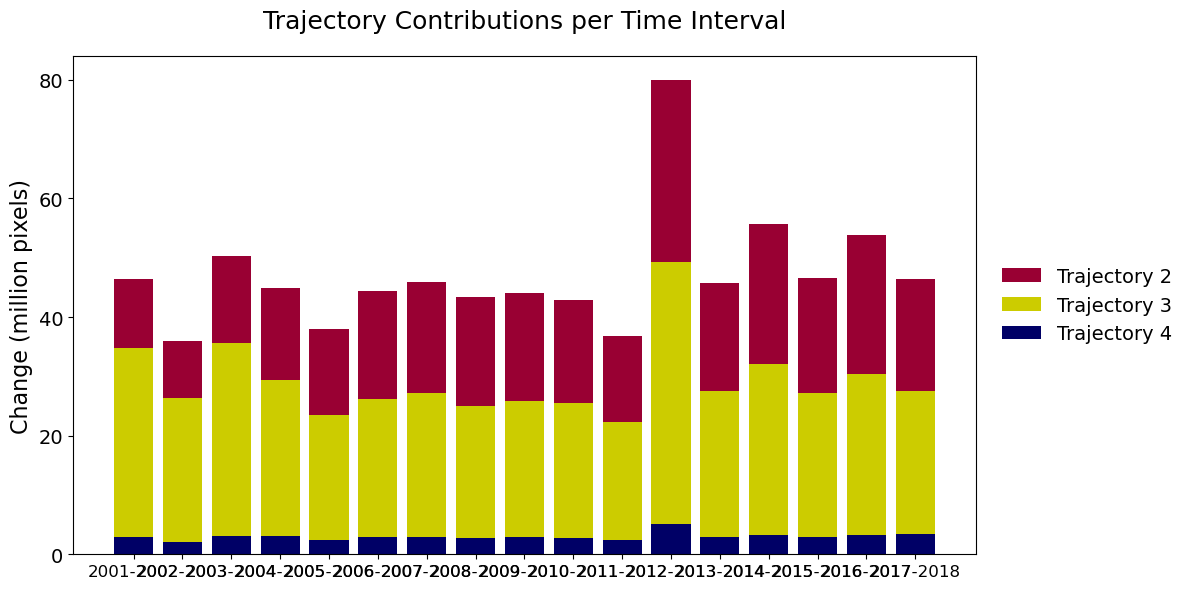

Figure saved to: /Users/antoniofonseca/Downloads/graphic_trajectory_contributions_stacked_bar.png


In [ ]:
def plot_trajectory_contributions(
    df: pd.DataFrame,
    output_path: str,
) -> None:
    """
    Create stacked bar chart for trajectory contributions per interval.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame with intervals as index and trajectory IDs (2, 3, 4) as columns.
    output_path : str
        Path to output directory for saving figure.
    """
    # 0. Ensure columns are integers to match logic
    df = df.copy()
    df.columns = df.columns.astype(
        int,
    )

    # 1. Calculate the maximum value to determine scale factor
    max_val = df.sum(
        axis=1,
    ).max()

    if max_val >= 1_000_000_000_000:
        scale_factor = 1_000_000_000_000
        y_label = "Change (trillion pixels)"
    elif max_val >= 1_000_000_000:
        scale_factor = 1_000_000_000
        y_label = "Change (billion pixels)"
    elif max_val >= 1_000_000:
        scale_factor = 1_000_000
        y_label = "Change (million pixels)"
    elif max_val >= 1_000:
        scale_factor = 1_000
        y_label = "Change (thousand pixels)"
    elif max_val >= 100:
        scale_factor = 100
        y_label = "Change (hundred pixels)"
    else:
        scale_factor = 1
        y_label = "Change (pixels)"

    # Apply scaling
    df_scaled = df / scale_factor

    # 2. Define colors and stacking order
    colors = {
        2: "#990033",
        3: "#cccc00",
        4: "#000066",
    }

    # Stacking order: 4 (bottom), 3 (middle), 2 (top)
    stack_order = [
        4,
        3,
        2,
    ]

    # 3. Create figure and axis
    fig, ax = plt.subplots(
        figsize=(
            12,
            6,
        ),
    )

    # 4. Plot stacked bars
    bottom = pd.Series(
        0.0,
        index=df_scaled.index,
    )

    for traj_id in stack_order:
        if traj_id in df_scaled.columns:
            values = df_scaled[
                traj_id
            ]
            ax.bar(
                df_scaled.index,
                values,
                label=f"Trajectory {traj_id}",
                bottom=bottom,
                color=colors[
                    traj_id
                ],
                edgecolor="none",
                width=0.8,
            )
            bottom += values

    # 5. Customize axes and labels
    ax.set_ylabel(
        y_label,
        fontsize=16,
    )
    ax.set_title(
        "Trajectory Contributions per Time Interval",
        fontsize=18,
        pad=20,
    )

    # X-Axis formatting: Horizontal labels
    ax.tick_params(
        axis="x",
        labelsize=12,
        rotation=0,
    )

    # Y-Axis formatting (mticker)
    ax.tick_params(
        axis="y",
        labelsize=14,
    )
    ax.yaxis.set_major_locator(
        mticker.MaxNLocator(
            integer=True,
            nbins=5,
        ),
    )
    ax.yaxis.set_major_formatter(
        mticker.FormatStrFormatter(
            "%d",
        ),
    )

    # Spines visible, NO GRID
    for spine in [
        "top",
        "right",
        "left",
        "bottom",
    ]:
        ax.spines[
            spine
        ].set_visible(
            True,
        )

    # 6. Legend
    handles, labels = ax.get_legend_handles_labels()

    if handles:
        # Reorder handles to match 2, 3, 4
        legend_order_map = {
            "Trajectory 2": 0,
            "Trajectory 3": 1,
            "Trajectory 4": 2,
        }

        # Sort handles based on labels
        sorted_pairs = sorted(
            zip(
                handles,
                labels,
            ),
            key=lambda x: legend_order_map.get(
                x[1],
                99,
            ),
        )
        sorted_handles, sorted_labels = zip(
            *sorted_pairs,
        )

        ax.legend(
            sorted_handles,
            sorted_labels,
            loc="center left",
            bbox_to_anchor=(
                1.01,
                0.5,
            ),
            fontsize=14,
            frameon=False,
        )

    plt.tight_layout()

    # 7. Save figure
    output_fig = os.path.join(
        output_path,
        "graphic_trajectory_contributions_stacked_bar.png",
    )
    plt.savefig(
        output_fig,
        dpi=300,
        bbox_inches="tight",
        format="png",
    )
    plt.show()

    print(
        f"Figure saved to: {output_fig}",
    )


# Executtion u
plot_trajectory_contributions(
    df=df_trajectory_intervals,
    output_path=output_path,
)

## **9. Alternation Maps**

### 9.1 Alternation Exchange

#### 9.1.1 Compute Alternation Exchange Map

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.windows import Window
from tqdm import tqdm
from numba import jit

@jit(nopython=True)
def _compute_exchange_block_numba(
    stack_data,
    input_nodata,
    output_nodata,
):
    """
    Calculate the Alternation Exchange metric pixel-by-pixel using JIT compilation.

    This function runs at C-speed, avoiding the slow Python loops. The mathematical
    logic remains strictly identical to the original specification.

    Parameters
    ----------
    stack_data : np.ndarray
        3D array of shape (Height, Width, Time) containing the pixel trajectories.
    input_nodata : int or float
        The NoData value present in the input rasters.
    output_nodata : int or float
        The value to assign to invalid pixels in the output.

    Returns
    -------
    np.ndarray
        2D array (Height, Width) inheriting the input dtype containing the exchange values.
    """
    rows, cols, time_steps = stack_data.shape

    # Initialize output array using the EXACT same data type as the input stack.
    # This ensures that negative NoData values (like -9999) fit perfectly.
    output_array = np.full(
        (
            rows,
            cols,
        ),
        output_nodata,
        dtype=np.uint8,
    )

    # Pre-allocate a small buffer for unique classes to avoid dynamic allocation in loop
    classes_buffer = np.zeros(
        50,
        dtype=np.int16,
    )

    for r in range(rows):
        for c in range(cols):
            # Extract trajectory for the current pixel
            traj = stack_data[
                r,
                c,
                :,
            ]

            # 1. Check for Input NoData (Strict Masking)
            is_valid = True
            for t in range(time_steps):
                if traj[t] == input_nodata:
                    is_valid = False
                    break

            if not is_valid:
                continue

            # 2. Identify unique classes manually
            n_classes = 0
            for t in range(time_steps):
                val = traj[t]
                found = False
                for k in range(n_classes):
                    if classes_buffer[k] == val:
                        found = True
                        break

                if not found:
                    if n_classes < 50:
                        classes_buffer[n_classes] = val
                        n_classes += 1

            # If no change possible (0 or 1 class), result is 0
            if n_classes <= 1:
                output_array[
                    r,
                    c,
                ] = 0
                continue

            # 3. Build Local Transition Matrix
            mat = np.zeros(
                (
                    n_classes,
                    n_classes,
                ),
                dtype=np.int16,
            )

            for t in range(time_steps - 1):
                s_val = traj[t]
                e_val = traj[t + 1]

                if s_val == e_val:
                    continue

                # Find indices in our local buffer
                s_idx = -1
                e_idx = -1
                for k in range(n_classes):
                    if classes_buffer[k] == s_val:
                        s_idx = k
                    if classes_buffer[k] == e_val:
                        e_idx = k

                if s_idx >= 0 and e_idx >= 0:
                    mat[
                        s_idx,
                        e_idx,
                    ] += 1

            # 4. Calculate Alternation Exchange: Sum(min(M, M.T))
            exchange_sum = 0
            for i in range(n_classes):
                for j in range(n_classes):
                    v1 = mat[
                        i,
                        j,
                    ]
                    v2 = mat[
                        j,
                        i,
                    ]
                    if v1 < v2:
                        exchange_sum += v1
                    else:
                        exchange_sum += v2

            # Assign value to output
            output_array[
                r,
                c,
            ] = exchange_sum

    return output_array

# --- Main Processing Function ---

def generate_alternation_exchange_map_optimized(
    file_list,
    output_dir,
    input_nodata_val,
    output_filename="map_alternation_exchange.tif",
    block_size=1024,
):
    """
    Generate the Alternation Exchange map using Numba acceleration and
    optimized I/O block processing (keeping files open).

    Parameters
    ----------
    file_list : list of str
        List of paths to the raster files (sorted by time).
    output_dir : str
        Directory to save the output raster.
    input_nodata_val : int or float
        The NoData value used in the input rasters.
    output_filename : str, optional
        Name of the output file.
    block_size : int, optional
        Size of the processing window (default is 1024).
    """
    output_path = os.path.join(
        output_dir,
        output_filename,
    )

    # We use the user's NoData variable directly
    output_nodata_val = input_nodata_val

    print(
        f"Starting optimized generation of Alternation Exchange map: {output_path}",
    )

    # 1. Open all datasets ONCE to avoid I/O overhead during the loop
    srcs = [
        rasterio.open(
            path,
        ) for path in file_list
    ]

    # 2. Extract metadata from the first source
    height = srcs[0].height
    width = srcs[0].width
    profile = srcs[0].profile.copy()

    # 3. Update profile for the output raster
    # Notice: 'dtype' is intentionally omitted here to inherit the input's dtype,
    # ensuring the custom NoData value fits perfectly.
    profile.update(
        {
            "driver": "GTiff",
            "dtype": rasterio.uint8,
            "count": 1,
            "nodata": output_nodata_val,
            "compress": "lzw",
            "tiled": True,
            "blockxsize": 256,
            "blockysize": 256,
        }
    )

    # 4. Create output file and iterate blocks
    with rasterio.open(
        output_path,
        "w+",
        **profile,
    ) as dst:

        rows = range(
            0,
            height,
            block_size,
        )
        cols = range(
            0,
            width,
            block_size,
        )
        total_blocks = len(rows) * len(cols)

        with tqdm(
            total=total_blocks,
            desc="Processing Blocks",
            unit="block",
        ) as pbar:

            for r_off in rows:
                for c_off in cols:
                    window = Window(
                        c_off,
                        r_off,
                        min(
                            block_size,
                            width - c_off,
                        ),
                        min(
                            block_size,
                            height - r_off,
                        ),
                    )

                    # 5. Read the block from the ALREADY OPEN datasets
                    stack_list = []

                    for src in srcs:
                        data = src.read(
                            1,
                            window=window,
                        )
                        stack_list.append(
                            data,
                        )

                    # 6. Prepare data for Numba (Height, Width, Time)
                    stack_data = np.array(
                        stack_list,
                    )
                    stack_data = np.moveaxis(
                        stack_data,
                        0,
                        -1,
                    )

                    # 7. Execute Numba Optimized Computation
                    output_block = _compute_exchange_block_numba(
                        stack_data,
                        input_nodata_val,
                        output_nodata_val,
                    )

                    # 8. Write result to disk
                    dst.write(
                        output_block,
                        1,
                        window=window,
                    )

                    pbar.update(1)

    # 9. Close all datasets to free up file descriptors
    for src in srcs:
        src.close()

    print(
        f"Process completed successfully. Alternation Exchange map saved to: {output_path}",
    )

# Execution using the optimized function

generate_alternation_exchange_map_optimized(
    file_list=image_paths,
    output_dir=output_path,
    input_nodata_val=noData_value,
)

Starting optimized generation of Alternation Exchange map: /Users/antoniofonseca/Downloads/map_alternation_exchange.tif


Processing Blocks: 100%|██████████████████████████████████████████████████████████████████████| 5852/5852 [4:31:26<00:00,  2.78s/block]

Process completed successfully. Alternation Exchange map saved to: /Users/antoniofonseca/Downloads/map_alternation_exchange.tif


#### 9.1.2 Plot Alternation Exchange map

Reading Alternation Exchange map for plotting: /content/drive/MyDrive/Assessments/cca/output/glance/map_alternation_exchange.tif


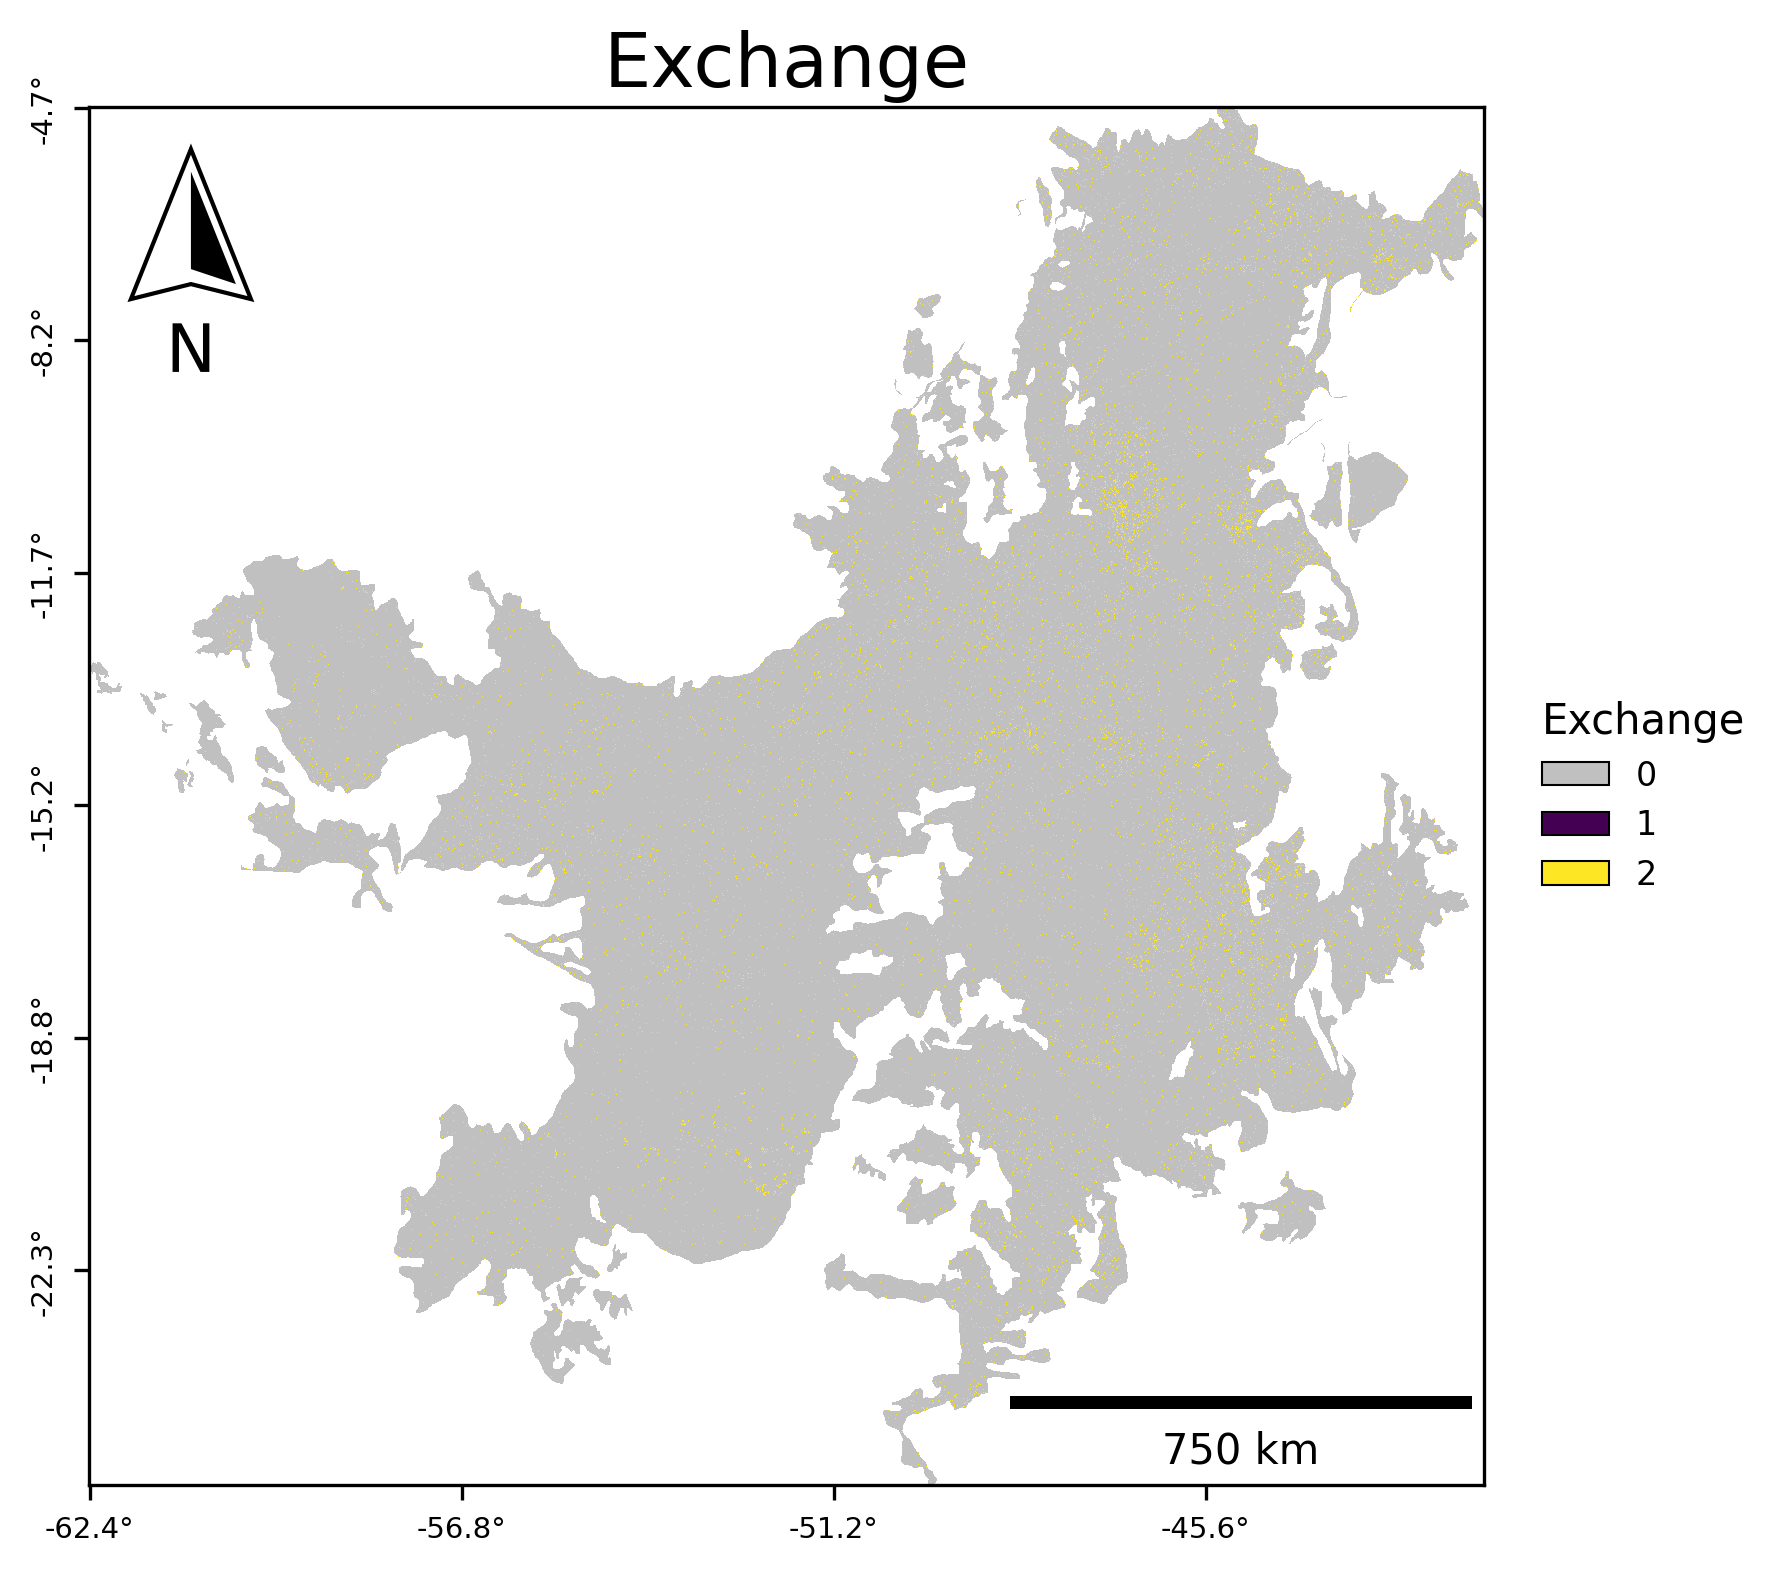

Map successfully saved to: /content/drive/MyDrive/Assessments/cca/output/glance/map_alternation_exchange.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import rasterio
from rasterio.enums import Resampling
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from pyproj import Transformer

def plot_alternation_exchange_discrete_map(
    output_dir: str,
    nodata_val: int,
    raster_filename: str = "map_alternation_exchange.tif",
    max_display_size: int = 1500, # Added dynamic downsampling parameter
) -> None:
    """
    Plot the Alternation Exchange map using a discrete integer scale,
    incorporating dynamic downsampling to prevent memory overflow.

    The visualization uses a specific color logic where the value 0 is
    represented in gray (indicating stability or absence of exchange),
    while values greater than or equal to 1 are represented by a
    gradient color scale (e.g., from pink to dark red) to indicate
    the intensity of the exchange.

    Parameters
    ----------
    output_dir : str
        The directory path containing the input raster file and where
        the output image will be saved.
    nodata_val : int
        Value representing NoData pixels to be masked.
    raster_filename : str, optional
        The filename of the raster to be plotted (default is
        "map_alternation_exchange.tif").
    max_display_size : int, optional
        Maximum width/height in pixels for the generated plot to prevent
        RAM overflow. Default is 1500.

    Returns
    -------
    None
        The function saves a PNG image to the output directory and
        displays the plot.

    Raises
    ------
    FileNotFoundError
        If the specified raster file does not exist in the output directory.
    """
    # 1. Input Validation and Path Setup
    raster_path = os.path.join(
        output_dir,
        raster_filename,
    )

    if not os.path.exists(
        raster_path,
    ):
        raise FileNotFoundError(
            f"Raster not found: {raster_path}",
        )

    print(
        f"Reading Alternation Exchange map for plotting: {raster_path}",
    )

    # Calculate dynamic scale factor based on max display size
    with rasterio.open(raster_path) as src:
        max_dim = max(src.width, src.height)
        scale_factor = max(1.0, max_dim / max_display_size)

        src_crs = src.crs
        transform = src.transform

    # Get the exact pixel size in km for the scalebar using the scale_factor
    pixel_size_km = compute_display_pixel_size_km(
        raster_path=raster_path,
        downsample_divisor=scale_factor,
    )

    # 2. Data Loading and Masking with Downsampling
    with rasterio.open(
        raster_path,
    ) as src:

        # Calculate new shape safely
        new_height = max(1, int(src.height / scale_factor))
        new_width = max(1, int(src.width / scale_factor))

        data = src.read(
            1,
            out_shape=(
                new_height,
                new_width,
            ),
            resampling=Resampling.nearest,
        )

        # Force masking using the provided variable
        data_masked = np.ma.masked_equal(
            data,
            nodata_val,
        )

    # Determine the integer range for the color scale
    data_max = int(
        data_masked.max(),
    )

    # Ensure at least 1 to prevent errors if the map is empty/flat
    if data_max == 0:
        data_max = 1

    # 3. Discrete Colormap Configuration
    original_cmap = plt.get_cmap("viridis")
    # Define the color for value 0 (Background/Gray)
    colors_list = ["#c0c0c0"] + [
        original_cmap(i) for i in np.linspace(0, 1, data_max)
    ]

    # Create the custom discrete colormap
    cmap = ListedColormap(
        colors_list,
    )

    # 4. Define Boundaries (Bins) for Integers
    # Create boundaries for every integer from 0 to max + 1
    bounds = np.arange(
        0,
        data_max + 2,
    ) - 0.5
    norm = BoundaryNorm(
        bounds,
        cmap.N,
    )

    # 5. Plotting the Figure
    fig, ax = plt.subplots(
        figsize=(
            6,
            8,
        ),
        dpi=300,
    )

    im = ax.imshow(
        data_masked,
        cmap=cmap,
        norm=norm,
        interpolation="nearest",
    )

    # 6. Legend Configuration
    legend_elements = []
    for i in range(0, data_max + 1):
        legend_elements.append(
            Patch(
                facecolor=cmap(norm(i)),
                edgecolor="black",
                linewidth=0.5,
                label=str(i),
            ),
        )

    ax.legend(
        handles=legend_elements,
        title="Exchange",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False,
        fontsize=8,
        title_fontsize=10,
        alignment="left",
    )

    # 7. Cartographic Elements
    scalebar = ScaleBar(
        dx=pixel_size_km,
        units="km",
        length_fraction=0.35,
        location="lower right",
        box_alpha=0.0,
        scale_formatter=lambda value, _: f"{int(value)} km",
    )
    ax.add_artist(
        scalebar,
    )

    # 8. North Arrow
    try:
        north_arrow(
            ax,
            location="upper left",
            shadow=False,
            rotation={
                "degrees": 0,
            },
        )
    except NameError:
        print("Note: north_arrow function not found, skipping.")

    # 9) Axes styling (with Lat/Lon labels)
    ax.set_title(
        "Exchange",
        fontsize=18,
        pad=5,
    )
    ax.set_aspect(
        "equal",
    )

    # Initialize Transformer (Native CRS -> Lat/Lon)
    to_latlon = Transformer.from_crs(
        src_crs,
        "EPSG:4326",
        always_xy=True,
    )

    # Get dimensions from the loaded DOWNSAMPLED data
    height, width = data_masked.shape

    def format_lon(
        x,
        pos,
    ):
        """
        Convert a pixel column index to a formatted Longitude string.
        """
        x = np.clip(
            x,
            0,
            width - 1,
        )
        # Multiply by scale_factor to map back to original pixels
        original_x = x * scale_factor
        original_y = (height // 2) * scale_factor

        x_proj, y_proj = rasterio.transform.xy(
            transform,
            original_y,
            original_x,
        )
        lon, lat = to_latlon.transform(
            x_proj,
            y_proj,
        )
        return f"{lon:.1f}°"

    def format_lat(
        y,
        pos,
    ):
        """
        Convert a pixel row index to a formatted Latitude string.
        """
        y = np.clip(
            y,
            0,
            height - 1,
        )
        # Multiply by scale_factor to map back to original pixels
        original_y = y * scale_factor
        original_x = (width // 2) * scale_factor

        x_proj, y_proj = rasterio.transform.xy(
            transform,
            original_y,
            original_x,
        )
        lon, lat = to_latlon.transform(
            x_proj,
            y_proj,
        )
        return f"{lat:.1f}°"

    # Apply the custom formatters
    ax.xaxis.set_major_formatter(
        FuncFormatter(
            format_lon,
        ),
    )
    ax.yaxis.set_major_formatter(
        FuncFormatter(
            format_lat,
        ),
    )

    # Limit ticks to avoid overcrowding
    ax.xaxis.set_major_locator(
        mticker.MaxNLocator(
            nbins=4,
        ),
    )
    ax.yaxis.set_major_locator(
        mticker.MaxNLocator(
            nbins=6,
        ),
    )

    # Final styling for ticks
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=7,
        pad=4,
    )
    plt.setp(
        ax.get_yticklabels(),
        rotation=90,
        va="center",
    )

    output_figure_path = os.path.join(
        output_dir,
        "map_alternation_exchange.png",
    )

    plt.savefig(
        output_figure_path,
        dpi=300,
        format="png",
        bbox_inches="tight",
        pad_inches=0.5,
    )
    plt.show()

    print(
        f"Map successfully saved to: {output_figure_path}",
    )

# Execution of the plotting function
plot_alternation_exchange_discrete_map(
    output_path,
    nodata_val=noData_value,
)

### 9.2 Alternation Shift Map

#### 9.2.1 Compute Alternation Shift raster map

In [ ]:
import os
import numpy as np
import rasterio
from rasterio.windows import Window
from tqdm import tqdm
from numba import jit

# --- Numba Optimized Function ---

@jit(nopython=True)
def _compute_shift_block_numba(
    stack_data,
    input_nodata,
):
    """
    Calculate the Alternation Shift metric pixel-by-pixel using JIT compilation.

    Shift is defined as: Total Changes - Net Extension - Total Exchange.

    Parameters
    ----------
    stack_data : np.ndarray
        3D array of shape (Height, Width, Time) containing pixel trajectories.
    input_nodata : int or float
        The NoData value present in the input rasters.

    Returns
    -------
    np.ndarray
        2D array (Height, Width) inheriting the input dtype containing the calculated shift values.
    """
    rows, cols, time_steps = stack_data.shape

    # Initialize output array with the user's NoData value
    output_array = np.full(
        (
            rows,
            cols,
        ),
        input_nodata,
        dtype=stack_data.dtype,
    )

    # Pre-allocate buffer for unique classes to avoid dynamic allocation
    classes_buffer = np.zeros(
        50,
        dtype=np.int16,
    )

    for r in range(rows):
        for c in range(cols):
            traj = stack_data[
                r,
                c,
                :,
            ]

            # 1. Check for Input NoData (Strict Masking)
            is_valid = True
            for t in range(time_steps):
                if traj[t] == input_nodata:
                    is_valid = False
                    break

            if not is_valid:
                continue

            # 2. Identify unique classes manually
            n_classes = 0
            for t in range(time_steps):
                val = traj[t]
                found = False
                for k in range(n_classes):
                    if classes_buffer[k] == val:
                        found = True
                        break

                if not found:
                    if n_classes < 50:
                        classes_buffer[n_classes] = val
                        n_classes += 1

            # If no change possible (0 or 1 class), Shift is 0
            if n_classes <= 1:
                output_array[
                    r,
                    c,
                ] = 0
                continue

            # 3. Build Local Transition Matrix
            mat = np.zeros(
                (
                    n_classes,
                    n_classes,
                ),
                dtype=np.int16,
            )

            total_changes = 0

            for t in range(time_steps - 1):
                s_val = traj[t]
                e_val = traj[t + 1]

                if s_val == e_val:
                    continue

                # Increment total changes count directly
                total_changes += 1

                # Find indices in buffer
                s_idx = -1
                e_idx = -1
                for k in range(n_classes):
                    if classes_buffer[k] == s_val:
                        s_idx = k
                    if classes_buffer[k] == e_val:
                        e_idx = k

                if s_idx >= 0 and e_idx >= 0:
                    mat[
                        s_idx,
                        e_idx,
                    ] += 1

            # 4. Calculate Net Extension Amount
            # If start != end, extension is 1, else 0
            extension_amount = 0
            if traj[0] != traj[time_steps - 1]:
                extension_amount = 1

            # 5. Calculate Total Exchange: Sum(min(M, M.T))
            total_exchange = 0
            for i in range(n_classes):
                for j in range(n_classes):
                    v1 = mat[
                        i,
                        j,
                    ]
                    v2 = mat[
                        j,
                        i,
                    ]
                    if v1 < v2:
                        total_exchange += v1
                    else:
                        total_exchange += v2

            # 6. Calculate Scalar Shift
            # Formula: Shift = Total Changes - Extension - Exchange
            shift_val = total_changes - extension_amount - total_exchange

            # Clamp negative values to 0 (safety)
            if shift_val < 0:
                shift_val = 0

            output_array[
                r,
                c,
            ] = shift_val

    return output_array

# --- Main Processing Function ---

def generate_alternation_shift_map_optimized(
    file_list,
    output_dir,
    input_nodata_val,
    output_filename="map_alternation_shift.tif",
    block_size=1024,
):
    """
    Generate the Alternation Shift map using Numba acceleration and
    optimized I/O block processing (keeping files open).

    Parameters
    ----------
    file_list : list of str
        List of paths to the raster files (sorted by time).
    output_dir : str
        Directory to save the output raster.
    input_nodata_val : int or float
        The NoData value used in the input rasters.
    output_filename : str, optional
        Name of the output file (default is "map_alternation_shift.tif").
    block_size : int, optional
        Size of the processing window (default is 1024).

    Returns
    -------
    None
        Saves the GeoTIFF to disk.
    """
    output_path = os.path.join(
        output_dir,
        output_filename,
    )

    print(
        f"Starting optimized generation of Alternation Shift map: {output_path}",
    )

    # 1. Open all datasets ONCE to avoid I/O overhead during the loop
    srcs = [
        rasterio.open(
            path,
        ) for path in file_list
    ]

    # 2. Read metadata from the first raster
    height = srcs[0].height
    width = srcs[0].width
    profile = srcs[0].profile.copy()

    # 3. Update profile for efficient output
    # Notice we removed the hardcoded dtype to inherit from the input source
    profile.update(
        {
            "driver": "GTiff",
            "count": 1,
            "nodata": input_nodata_val,
            "compress": "lzw",
            "tiled": True,
            "blockxsize": 256,
            "blockysize": 256,
        }
    )

    # 4. Create output file and iterate blocks
    with rasterio.open(
        output_path,
        "w+",
        **profile,
    ) as dst:

        rows = range(
            0,
            height,
            block_size,
        )
        cols = range(
            0,
            width,
            block_size,
        )
        total_blocks = len(rows) * len(cols)

        with tqdm(
            total=total_blocks,
            desc="Processing Shift Blocks",
            unit="block",
        ) as pbar:

            for r_off in rows:
                for c_off in cols:
                    # Define current window
                    window = Window(
                        c_off,
                        r_off,
                        min(
                            block_size,
                            width - c_off,
                        ),
                        min(
                            block_size,
                            height - r_off,
                        ),
                    )

                    # 5. Load stack for this window only from ALREADY OPEN datasets
                    stack_list = []

                    for src in srcs:
                        data = src.read(
                            1,
                            window=window,
                        )
                        stack_list.append(
                            data,
                        )

                    # 6. Prepare data for Numba (Height, Width, Time)
                    # moveaxis ensures time is the last dimension for contiguous memory access
                    stack_data = np.array(
                        stack_list,
                    )
                    stack_data = np.moveaxis(
                        stack_data,
                        0,
                        -1,
                    )

                    # 7. Execute Numba Optimized Computation
                    output_block = _compute_shift_block_numba(
                        stack_data,
                        input_nodata_val,
                    )

                    # 8. Write result to disk
                    dst.write(
                        output_block,
                        1,
                        window=window,
                    )

                    pbar.update(1)

    # 9. Close all datasets
    for src in srcs:
        src.close()

    print(
        f"Process completed successfully. Shift Map saved to: {output_path}",
    )

# Execution using the optimized function

generate_alternation_shift_map_optimized(
    file_list=image_paths,
    output_dir=output_path,
    input_nodata_val=noData_value,
)

Starting optimized generation of Alternation Shift map: /Users/antoniofonseca/Downloads/map_alternation_shift.tif


Processing Shift Blocks: 100%|████████████████████████████████████████████████████████████████| 5852/5852 [4:40:28<00:00,  2.88s/block]


Process completed successfully. Shift Map saved to: /Users/antoniofonseca/Downloads/map_alternation_shift.tif


#### 9.2.2 Plot Alternation Shift Map

Reading Alternation Shift map for plotting: /Users/antoniofonseca/Downloads/map_alternation_shift.tif


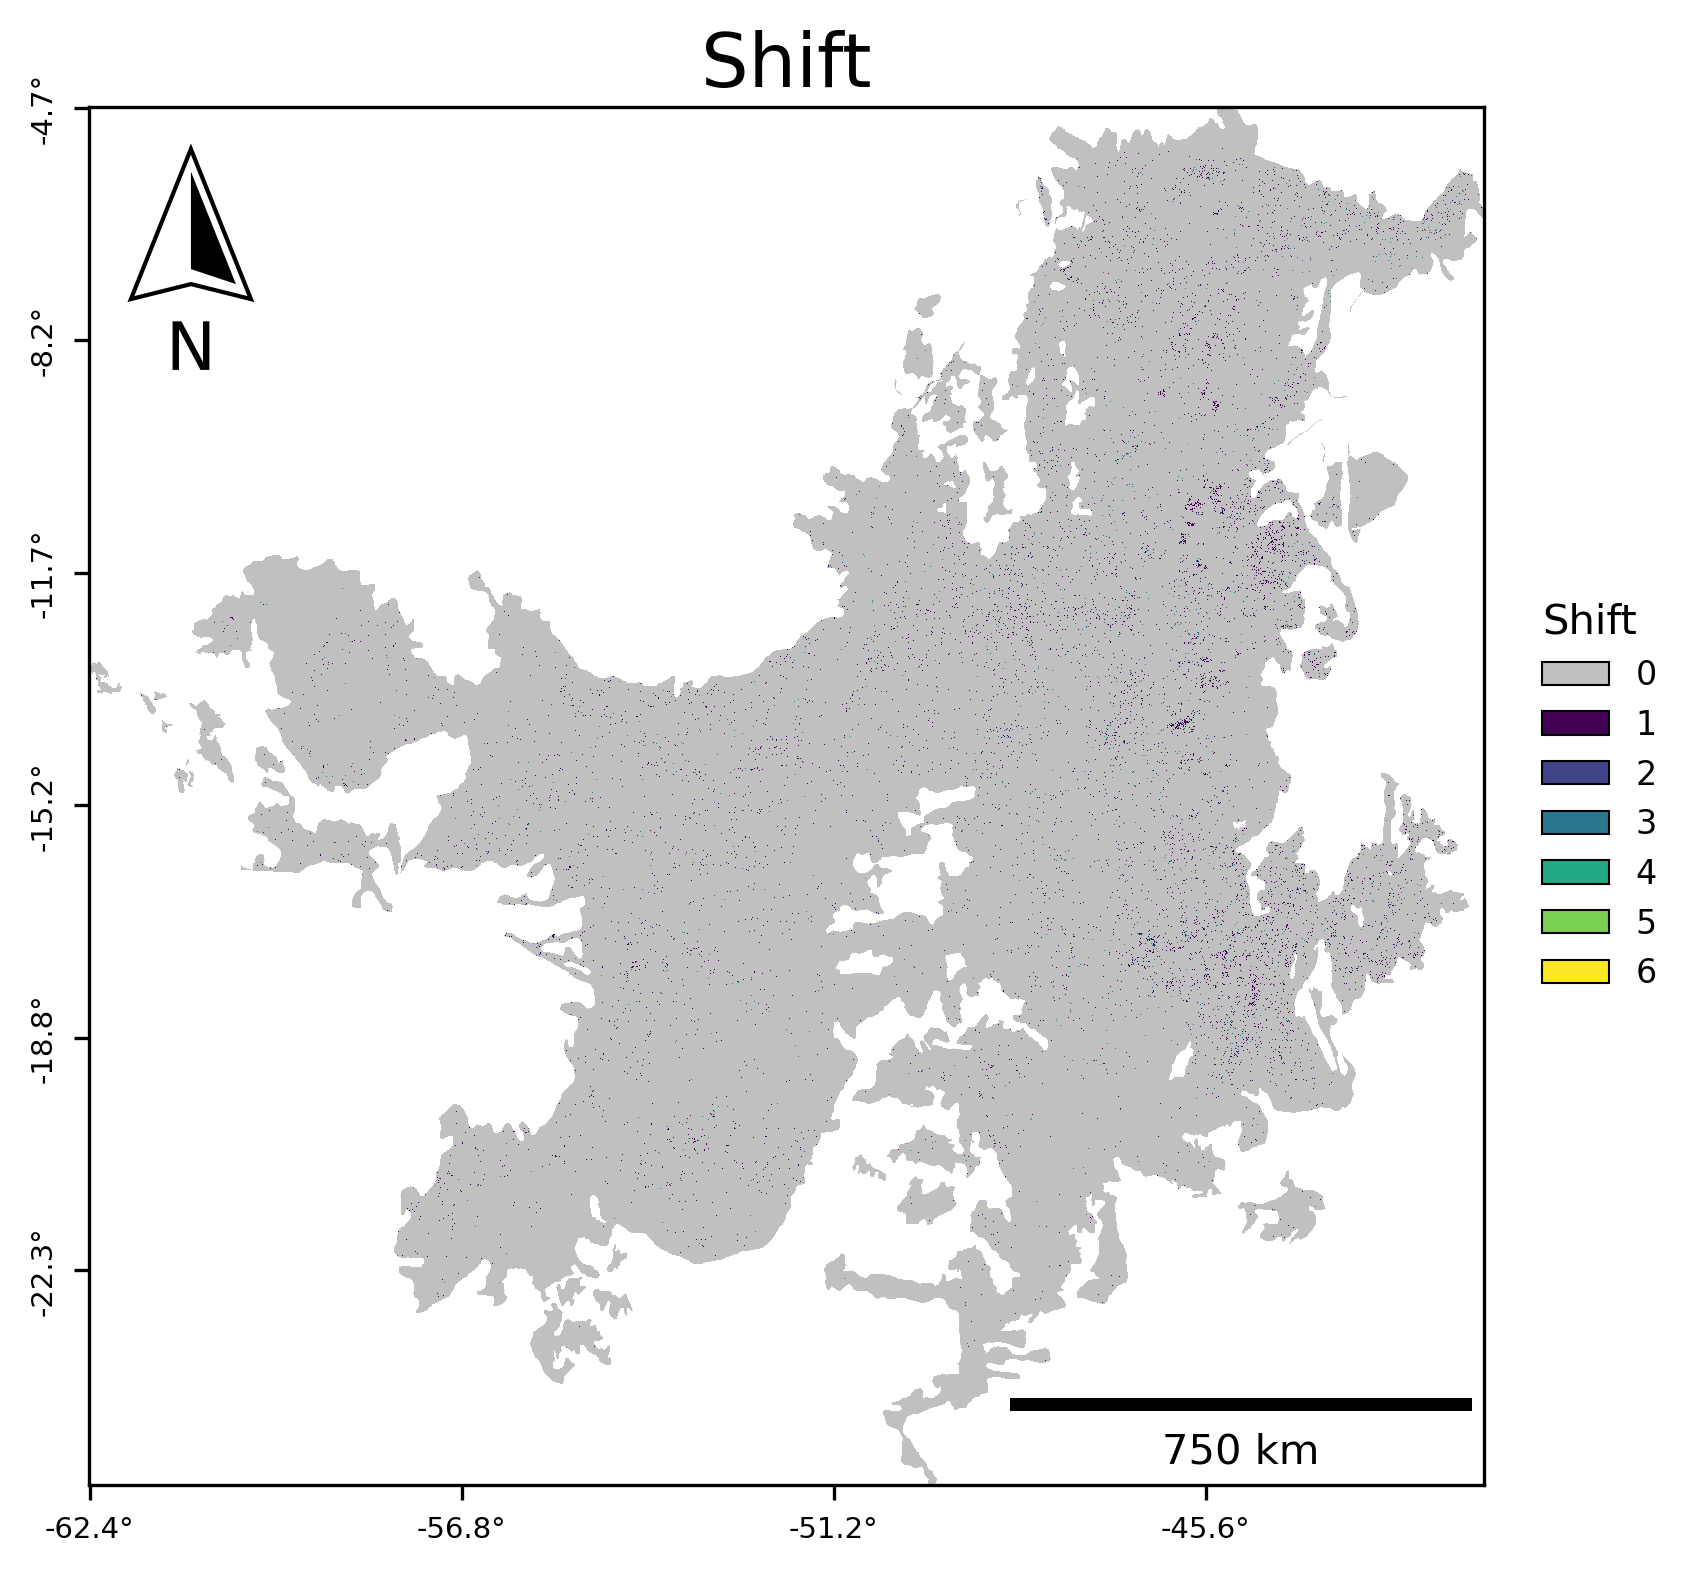

Map saved successfully: /Users/antoniofonseca/Downloads/map_alternation_shift.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import rasterio
from rasterio.enums import Resampling
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from matplotlib.ticker import FuncFormatter
from matplotlib_scalebar.scalebar import ScaleBar
from pyproj import Transformer

def plot_alternation_shift_map(
    output_dir: str,
    nodata_val: int,
    raster_filename: str = "map_alternation_shift.tif",
    max_display_size: int = 1500, # Added dynamic downsampling parameter
) -> None:
    """
    Plot the Alternation Shift map using a discrete integer scale.

    The visualization uses a specific color logic where the value 0 is
    represented in gray (indicating stability or absence of shift),
    while values greater than or equal to 1 are represented by a
    gradient color scale (e.g., from green to dark green) to indicate
    the intensity of the shift.

    Parameters
    ----------
    output_dir : str
        The directory path containing the input raster file and where
        the output image will be saved.
    nodata_val : int
        Value representing NoData pixels to be masked.
    raster_filename : str, optional
        The filename of the raster to be plotted (default is
        "map_alternation_shift.tif").
    max_display_size : int, optional
        Maximum width/height in pixels for the generated plot to prevent
        RAM overflow. Default is 1500.

    Returns
    -------
    None
        The function saves a PNG image to the output directory and
        displays the plot.

    Raises
    ------
    FileNotFoundError
        If the specified raster file does not exist in the output directory.
    """
    # 1. Input Validation and Path Setup
    raster_path = os.path.join(
        output_dir,
        raster_filename,
    )

    if not os.path.exists(
        raster_path,
    ):
        raise FileNotFoundError(
            f"Raster not found: {raster_path}",
        )

    print(
        f"Reading Alternation Shift map for plotting: {raster_path}",
    )

    # Calculate dynamic scale factor based on max display size
    with rasterio.open(raster_path) as src:
        max_dim = max(src.width, src.height)
        scale_factor = max(1.0, max_dim / max_display_size)

        src_crs = src.crs
        transform = src.transform

    # Get the exact pixel size in km for the scalebar using the scale_factor
    pixel_size_km = compute_display_pixel_size_km(
        raster_path=raster_path,
        downsample_divisor=scale_factor,
    )

    # 2. Data Loading and Masking with Downsampling
    with rasterio.open(
        raster_path,
    ) as src:

        # Calculate new shape safely
        new_height = max(1, int(src.height / scale_factor))
        new_width = max(1, int(src.width / scale_factor))

        data = src.read(
            1,
            out_shape=(
                new_height,
                new_width,
            ),
            resampling=Resampling.nearest,
        )

        # Force masking using the provided variable
        data_masked = np.ma.masked_equal(
            data,
            nodata_val,
        )

    # Determine the integer range for the color scale
    data_max = int(
        data_masked.max(),
    )

    # Ensure at least 1 to prevent errors if the map is empty/flat
    if data_max == 0:
        data_max = 1

    # 3. Discrete Colormap Configuration
    original_cmap = plt.get_cmap("viridis")

    colors_list = ["#c0c0c0"] + [
        original_cmap(i) for i in np.linspace(0, 1, data_max)
    ]

    cmap = ListedColormap(
        colors_list,
    )

    # 4. Define Boundaries (Bins) for Integers
    # Create boundaries for every integer from 0 to max + 1
    # Adding -0.5 centers the integer values perfectly inside the color bins
    bounds = np.arange(
        0,
        data_max + 2,
    ) - 0.5

    norm = BoundaryNorm(
        bounds,
        cmap.N,
    )

    # 5. Plotting the Figure
    fig, ax = plt.subplots(
        figsize=(
            6,
            8,
        ),
        dpi=300,
    )

    im = ax.imshow(
        data_masked,
        cmap=cmap,
        norm=norm,
        interpolation="nearest",
    )

    # 6. Legend Configuration
    legend_elements = []
    # Loop from min to max to create a box for each integer
    for i in range(0, data_max + 1):
        legend_elements.append(
            Patch(
                facecolor=cmap(norm(i)),
                edgecolor="black",
                linewidth=0.5,
                label=str(i),
            ),
        )

    ax.legend(
        handles=legend_elements,
        title="Shift",
        loc="center left",
        bbox_to_anchor=(1.02, 0.5),
        frameon=False,
        fontsize=8,
        title_fontsize=10,
        alignment="left",
    )

    # 7. Cartographic Elements
    scalebar = ScaleBar(
        dx=pixel_size_km,
        units="km",
        length_fraction=0.35,
        location="lower right",
        box_alpha=0.0,
        scale_formatter=lambda value, _: f"{int(value)} km",
    )
    ax.add_artist(
        scalebar,
    )

    # 8. North Arrow
    try:
        north_arrow(
            ax,
            location="upper left",
            shadow=False,
            rotation={
                "degrees": 0,
            },
        )
    except NameError:
        print("Note: north_arrow function not found, skipping.")

    # 9) Axes styling (with Lat/Lon labels)
    ax.set_title(
        "Shift",
        fontsize=18,
        pad=5,
    )
    ax.set_aspect(
        "equal",
    )

    # Initialize Transformer (Native CRS -> Lat/Lon)
    to_latlon = Transformer.from_crs(
        src_crs,
        "EPSG:4326",
        always_xy=True,
    )

    # Get dimensions from the loaded DOWNSAMPLED data
    height, width = data_masked.shape

    def format_lon(
        x,
        pos,
    ):
        """
        Convert a pixel column index to a formatted Longitude string.
        """
        x = np.clip(
            x,
            0,
            width - 1,
        )
        # Multiply by scale_factor to map back to original pixels
        original_x = x * scale_factor
        original_y = (height // 2) * scale_factor

        x_proj, y_proj = rasterio.transform.xy(
            transform,
            original_y,
            original_x,
        )
        lon, lat = to_latlon.transform(
            x_proj,
            y_proj,
        )
        return f"{lon:.1f}°"

    def format_lat(
        y,
        pos,
    ):
        """
        Convert a pixel row index to a formatted Latitude string.
        """
        y = np.clip(
            y,
            0,
            height - 1,
        )
        # Multiply by scale_factor to map back to original pixels
        original_y = y * scale_factor
        original_x = (width // 2) * scale_factor

        x_proj, y_proj = rasterio.transform.xy(
            transform,
            original_y,
            original_x,
        )
        lon, lat = to_latlon.transform(
            x_proj,
            y_proj,
        )
        return f"{lat:.1f}°"

    # Apply the custom formatters
    ax.xaxis.set_major_formatter(
        FuncFormatter(
            format_lon,
        ),
    )
    ax.yaxis.set_major_formatter(
        FuncFormatter(
            format_lat,
        ),
    )

    # Limit ticks to avoid overcrowding
    ax.xaxis.set_major_locator(
        mticker.MaxNLocator(
            nbins=4,
        ),
    )
    ax.yaxis.set_major_locator(
        mticker.MaxNLocator(
            nbins=6,
        ),
    )

    # Final styling for ticks
    ax.tick_params(
        axis="both",
        which="major",
        labelsize=7,
        pad=4,
    )
    plt.setp(
        ax.get_yticklabels(),
        rotation=90,
        va="center",
    )

    output_figure_path = os.path.join(
        output_dir,
        "map_alternation_shift.png",
    )

    plt.savefig(
        output_figure_path,
        dpi=300,
        format="png",
        bbox_inches="tight",
        pad_inches=0.5,
    )
    plt.show()

    print(
        f"Map saved successfully: {output_figure_path}",
    )

# Execution of the plotting function
plot_alternation_shift_map(
    output_dir=output_path,
    nodata_val=noData_value,
    raster_filename="map_alternation_shift.tif",
)